#### <h1 style="line-height: 1.3">W4111: Introduction to Databases $-$ HW4 Implementation Template</h1>

## Neo4J


In [681]:
from py2neo import Graph
from py2neo.ogm import GraphObject, Property, RelatedFrom, RelatedTo


graph = Graph("bolt://localhost:7687", auth=("neo4j", "neo4j"))


class Movie(GraphObject):
    __primarykey__ = "title"
    title = Property()
    tagline = Property()
    released = Property()
    actors = RelatedFrom("Person", "ACTED_IN")
    directors = RelatedFrom("Person", "DIRECTED")
    producers = RelatedFrom("Person", "PRODUCED")

class Person(GraphObject):
    __primarykey__ = "name"
    name = Property()
    born = Property()
    acted_in = RelatedTo(Movie)
    directed = RelatedTo(Movie)
    produced = RelatedTo(Movie)


- And some simple tests

In [682]:
def t1():
    x = graph.nodes.match("Person", name="Keanu Reeves").first() # Evaluate the match and return the first Node matched or None if no matching nodes are found.
    print(type(x))
    print('Born = ', x['born'])
    y = Person.wrap(x)
    print("type of y",type(y))
    print(y.born)
    print(y)

def t2():
    st = Person.match(graph).where("_.born = 1960")
    print("People born in 1960 and the movies they acted in:")
    for s in st:
        print(s.name, s.born)

        for m in s.acted_in:
            print("\t", m.title, m.released)

In [683]:
t1()

<class 'py2neo.data.Node'>
Born =  1964
type of y <class '__main__.Person'>
1964
<Person name='Keanu Reeves'>


In [684]:
t2()

People born in 1960 and the movies they acted in:
Hugo Weaving 1960
	 Cloud Atlas 2012
	 V for Vendetta 2006
	 The Matrix Revolutions 2003
	 The Matrix Reloaded 2003
	 The Matrix 1999
Annabella Sciorra 1960
	 What Dreams May Come 1998
John Goodman 1960
	 Speed Racer 2008
Oliver Platt 1960
	 Frost/Nixon 2008
	 Bicentennial Man 1999
Hugo Weaving 1960
	 The Matrix Revolutions 2003
	 Cloud Atlas 2012
	 The Matrix 1999
	 The Matrix Reloaded 2003
	 V for Vendetta 2006
Annabella Sciorra 1960
	 What Dreams May Come 1998
John Goodman 1960
	 Speed Racer 2008
Oliver Platt 1960
	 Frost/Nixon 2008
	 Bicentennial Man 1999


## Homework 4

### Setup

- Install Neo4j Community Edition. Do not install the desktop. Just install the server.


- Add py2neo to your environments, if necessary.


- Using PyCharm to develop and test your code is the best practice. You can copy the code into the notebook when done developing and testing.


### Concept

- Load information from lahman2017.people, lahman2017.teams, lahman2017.appearances. The code for loading the database is below.


- Add a Node type for _Fan._ __NOTE:__ You do not need to add a class unlike the pattern above.


- Allow a Fan to follow other Fans, Comment on a Team and/or Player and response to Comments.


### Data Model

- The loading function do not all of the data. The loaded is scoped by year range, which you will see in code below. (Loading the full database would create performance problems for you and require getting a licensed version).


- Node Labels:
    - Team: Core information loaded from Lahman 2017
    - Player: Core information loaded from Lahman 2017
    - Fan: New entity representing a baseball fan.
    - Comment: A Fan made a comment on a team or player.
    
    
- Relationships:
    - Appeared: Represents the fact that a player "appeared" for a team in a year. Loaded from a small subset of Lahman 2017.
    - Supports: A Fan supports a Team
    - Follows: A Fan follows (the comments of) another Fan.
    - CommentOn: Represents the relationship between a Comment and a Team/Player.
    - CommentBy: Relationship between a Fan and Comment.
    - ResponseTo: Indicates that a Comment is a ResponseTo a Comment.

### HW4 Part 1: Implementation and Template


- There are two parts to HW4:
    1. Simple social model and topics in Neo4j
    2. API result cache for database query results using Redis. A section later in the notebook explains part 2.
    

- HW4:
    - Starts with a Python implementation template for a class _FanGraph._
        - Contains many example methods.
        - Placeholder for the methods that you need to implement.
    - Some sample client code for creating and finding nodes and relationships.
    - A few test cases to get you started and verify correctness. You need to implement a more complete set of tests.
    
    
- HW4 tasks:
    - Load the Neo4j database using the load functions below.
    - Implement and test the incomplete methods (ones with "pass") in the template.
    
### Template
    

In [708]:
from py2neo import data, Graph, NodeMatcher, Node, Relationship, RelationshipMatcher

"""
See https://py2neo.org/v4/
"""

"""
NOTE:
    1. I did some basic testing, debugging, etc. but there may be errors.
    2. You can complain about the errors if you want but my response will be, "No Template for You!"
"""

import json
import uuid


class FanGraph(object):
    """
    This object provides a set of helper methods for creating and retrieving nodes and relationships from
    a Neo4j database holding information about players, teams, fans, comments and their relationships.
    """

    # Note:
    # I tend to avoid object mapping frameworks. Object mapping frameworks are fun in the beginning
    # but tend to be annoying after a while. So, I did not create types Player, Team, etc.
    #


    # Connects to the DB and sets a Graph instance variable.
    # Also creates a NodeMatcher and RelationshipMatcher, which are a py2neo framework classes.
    def __init__(self, auth=('neo4j', 'neo4j'), host='localhost', port=7687, secure=False, ):
        self._graph = Graph(secure=secure,
                            bolt=True,
                            auth=auth,
                            host=host,
                            port=port)
        self._node_matcher = NodeMatcher(self._graph)
        self._relationship_matcher = RelationshipMatcher(self._graph)

    def run_q(self, qs, args):
        """

        :param qs: Query string that may have {} slots for parameters.
        :param args: Dictionary of parameters to insert into query string.
        :return:  Result of the query, which executes as a single, standalone transaction.
        """
        try:
            tx = self._graph.begin(autocommit=False)
            result = self._graph.run(qs, args)
            return result
        except Exception as e:
            print("Run exaception = ", e)

    def run_match(self, labels=None, properties=None):
        """
        Uses a NodeMatcher to find a node matching a "template."
        :param labels: A list of labels that the node must have.
        :param properties: A dictionary of {property_name: property_value} defining the template that the
            node must match.
        :return: An array of Node objects matching the pattern.
        """
        # ut.debug_message("Labels = ", labels)
        # ut.debug_message("Properties = ", json.dumps(properties))

        if labels is not None and properties is not None:
            result = self._node_matcher.match(labels, **properties)
        elif labels is not None and properties is None:
            result = self._node_matcher.match(labels)
        elif labels is None and properties is not None:
            result = self._node_matcher.match(**properties)
        else:
            raise ValueError("Invalid request. Labels and properties cannot both be None.")

        # Convert NodeMatch data into a simple list of Nodes.
        full_result = []
        for r in result:
            full_result.append(r)

        return full_result

    def find_nodes_by_template(self, tmp):
        """

        :param tmp: A template defining the label and properties for Nodes to return. An
         example is { "label": "Fan", "template" { "last_name": "Ferguson", "first_name": "Donald" }}
        :return: A list of Nodes matching the template.
        """
        labels = tmp.get('label', None)
        props = tmp.get("template", None)
        result = self.run_match(labels=labels, properties=props)
        return result

    # Create and save a new node for  a 'Fan.'
    def create_fan(self, uni, last_name, first_name):
        """

        :param uni: uni
        :param last_name: Obvious
        :param first_name: Obvious
        :return: Node created.

        NOTE: This does not check uni uniqueness. We could do using transactions or setting a constraint
        on the database.
        """
        n = Node("Fan", uni=uni, last_name=last_name, first_name=first_name)
        tx = self._graph.begin(autocommit=True)
        tx.create(n)
        return n

    # Given a UNI, return the node for the Fan.
    def get_fan(self, uni):
        n = self.find_nodes_by_template({"label": "Fan", "template": {"uni": uni}})
        if n is not None and len(n) > 0:
            # I should throw an exception here if there is more than 1.
            n = n[0]
        else:
            n = None

        return n

    def create_player(self, player_id, last_name, first_name):
        n = Node("Player", player_id=player_id, last_name=last_name, first_name=first_name)
        tx = self._graph.begin(autocommit=True)
        tx.create(n)
        return n

    def get_player(self, player_id):
        n = self.find_nodes_by_template({"label": "Player", "template": {"player_id": player_id}})
        if n is not None and len(n) > 0:
            n = n[0]
        else:
            n = None

        return n

    def create_team(self, team_id, team_name):
        n = Node("Team", team_id=team_id, team_name=team_name)
        tx = self._graph.begin(autocommit=True)
        tx.create(n)
        return n

    def get_team(self, team_id):
        n = self.find_nodes_by_template({"label": "Team", "template": {"team_id": team_id}})
        if n is not None and len(n) > 0:
            n = n[0]
        else:
            n = None

        return n

    def create_supports(self, uni, team_id):
        """
        Create a SUPPORTS relationship from a Fan to a Team.
        :param uni: The UNI for a fan.
        :param team_id: An ID for a team.
        :return: The created SUPPORTS relationship from the Fan to the Team
        """
        f = self.get_fan(uni)
        t = self.get_team(team_id)
        r = Relationship(f, "SUPPORTS", t)
        tx = self._graph.begin(autocommit=True)
        tx.create(r)
        return r

    def get_appearance(self, player_id, team_id, year_id):
        """
        Get the information about appearances for a player and team.
        :param player_id: player_id
        :param team_id: team_id
        :param year_id: The year for getting appearances.
        :return:
        """
        try:
            # Get the Nodes at the ends of the relationship representing appearances.
            p = self.get_player(player_id)
            t = self.get_team(team_id)

            # Run a match looking for relationships of a specific type linking the nodes.
            rm = self._graph.match(nodes=[p, t], r_type="APPEARED")
            result = []

            # If there is a list of relationships.
            if rm is not None:
                for r in rm:

                    # The type will be a class APPEARED() because of the OO mapping.
                    node_type = type(r).__name__
                    year = r['year']

                    # If the type and year are correct, add to result
                    if node_type == "APPEARED" and (year == year_id or year_id is None):
                        result.append(r)

                return result
            else:
                return None
        except Exception as e:
            print("get_appearance: Exception e = ", e)
            raise e

    # Create an APPEARED relationship from a player to a Team
    def create_appearance_all(self, player_id, team_id, year, games):
        """

        :param player_id: O
        :param team_id:
        :param year:
        :param games:
        :return:
        """
        try:
            tx = self._graph.begin(autocommit=False)
            q = "match (n:Player {player_id: '" + player_id + "'}), " + \
                "(t:Team {team_id: '" + team_id + "'}) " + \
                "create (n)-[r:APPEARED { games: " + str(games) + ", year : " + str(year) + \
                "}]->(t)"
            result = self._graph.run(q)
            tx.commit()
        except Exception as e:
            print("create_appearances: exception = ", e)

    # Create a FOLLOWS relationship from a Fan to another Fan.
    def create_follows(self, follower, followed):
        f = self.get_fan(follower)
        t = self.get_fan(followed)
        r = Relationship(f, "FOLLOWS", t)
        tx = self._graph.begin(autocommit=True)
        tx.create(r)

    def get_comment(self, comment_id):
        """

        :param comment_id: Comment ID
        :return: Comment
        """
        n = self.find_nodes_by_template({"label": "Comment", "template": {"comment_id" : comment_id}})
        if n is not None and len(n) > 0:
            n = n[0]
        else:
            n = None

        return n

    def create_comment(self, uni, comment, team_id=None, player_id=None):
        """
        Creates a comment
        :param uni: The UNI for the Fan making the comment.
        :param comment: A simple string.
        :param team_id: A valid team ID or None. team_id and player_id cannot BOTH be None.
        :param player_id: A valid player ID or None
        :return: The Node representing the comment.
        """
        if uni is None or comment is None or (player_id is None and team_id is None):
            raise ValueError("create_comment: invalid input.")

        comment_id = str(uuid.uuid4())
        fan = None
        team = None
        player = None
        tx = None
        try:
            tx = self._graph.begin()

            fan = self.get_fan(uni)
            if fan is None:
                raise ValueError("create_comment: Fan node not found.")

            if team_id is not None:
                team = self.get_team(team_id)
                if team is None:
                    raise ValueError("create_comment: Team node not found.")

            if player_id is not None:
                player = self.get_player(player_id)
                if player is None:
                    raise ValueError("create_comment: Player node not found.")

            c = Node("Comment", comment_id=comment_id, comment=comment)
            tx.create(c)

            pc = Relationship(fan, "COMMENT_BY", c)
            tx.create(pc)

            if player is not None:
                pr = Relationship(c, "COMMENT_ON", player)
                tx.create(pr)

            if team is not None:
                p2 = Relationship(c, "COMMENT_ON", team)
                tx.create(p2)

            tx.commit()

            return c
        except Exception as e:
            print(e)

    def create_sub_comment(self, uni, origin_comment_id, comment):
        """
        Create a sub-comment (response to a comment or response) and links with parent in thread.
        :param uni: ID of the Fan making the comment.
        :param origin_comment_id: Id of the comment to which this is a response.
        :param comment: Comment string
        :return: Created comment.
        """
        if uni is None or comment is None or origin_comment_id is None:
            raise ValueError("create_comment: invalid input.")

        sub_comment_id = str(uuid.uuid4())
        fan = None
        tx = None
        try:
            tx = self._graph.begin()

            fan = self.get_fan(uni)
            if fan is None:
                raise ValueError("create_comment: Fan node not found.")

            c = Node("SubComment", sub_comment_id=sub_comment_id, comment=comment)
            tx.create(c)

            pc = Relationship(fan, "RESPONSE_BY", c)
            tx.create(pc)

            n = self.get_comment(origin_comment_id)
            sub_to_c = Relationship(c, "RESPONSE_TO",n)
            tx.create(sub_to_c)
            tx.commit()

            return c
        except Exception as e:
            print(e)

    def get_sub_comments(self, comment_id):
        """

        :param comment_id: The unique ID of the comment.
        :return: The sub-comments.
        """
        
        n = self.find_nodes_by_template({"label": "SubComment", "template": {"sub_comment_id" : comment_id}})
        if n is not None and len(n) > 0:
            n = n[0]
        else:
            n = None
        return n
    

    def get_player_comments(self, player_id):
        """
        Gets all of the comments associated with a player, Also returns the Nodes for people making the comments.
        :param player_id: ID of the player.
        :return: Graph containing comment, comment streams and commenters.
        """
        q = "match (p:Player {player_id: {pid}})<-[:COMMENT_ON]-(c:Comment)<-[:COMMENT_BY]-(d) return p,c,d"
        res = self.run_q(q, {"pid": player_id})
        print("res = ", json.dumps(res.data(), indent=2))
        return res

    def get_team_comments(self, team_id):
        """
        Gets all of the comments associated with a team.  Also returns the Nodes for people making the comments.
        :param player_id: ID of the team.
        :return: Graph containing comment, comment streams and commenters.
        """
        q = "match (t:Team {team_id: {tid}})<-[:COMMENT_ON]-(c:Comment)<-[:COMMENT_BY]-(d) return t,c,d"
        res = self.run_q(q, {"tid": team_id})
        print("res = ", json.dumps(res.data(), indent=2))
        return res


    def get_players_by_team(self, team_id, yearid):
        """
        
        :param team_id: The ID of a team.
        :param yearid: A year.
        :return: Returns the players who played for the team in the year.
        """
        q = "match(p: Player)-[r: APPEARED]-(t:Team {team_id: {tid}}) where r.year = {yid} return p, t"
        res = self.run_q(q, {"tid":team_id, "yid":yearid})
        return res.data()



### Tests and Examples


In [709]:

import json
import pandas as pd

pd.set_option('display.width', 132)

In [710]:
fg = FanGraph(
                  host="localhost",
                  port=7687,
                  secure=False)


In [711]:
print("fg = ", fg)

fg =  <__main__.FanGraph object at 0x0000025E76AE07F0>


#### Simple Tests and Examples

##### Query Example

In [675]:
def t1(name):
    """
    Find all the movies that a person with name 'name' is related to.
    Return information as a Pandas data frame.
    """
    
    # The match is (Person)-[any relationship]->(Movie)
    # Person name must be the passed {name}.
    # Return a list of dictionaries of the attributes/values.
    #
    qs = "match (t:Person)-[r]->(t2:Movie) " + \
    " where t.name={name} " + \
    " return t.name, t2.title, t2.released, r.roles"
    
    # Set the name parameter for the query
    ag = {"name": name}
    
    # Use the handy, dandy run_q method on FanGraph
    r = fg.run_q(qs, ag)
    
    # Convert the result into a DataFrame
    x = pd.DataFrame(r.data())
    
    # Make sure the columns are in the "right" order. 
    # Python dicts are unordered, which means the data frame's columns
    # might be in a weird order.
    x = x[['t.name', 't2.title', 't2.released', 'r.roles']]
    return x

In [676]:
# Find Tom Hanks
x = t1('Tom Hanks')
display(x)

,t.name,t2.title,t2.released,r.roles
0,Tom Hanks,Apollo 13,1995,[Jim Lovell]
1,Tom Hanks,You've Got Mail,1998,[Joe Fox]
2,Tom Hanks,A League of Their Own,1992,[Jimmy Dugan]
3,Tom Hanks,Joe Versus the Volcano,1990,[Joe Banks]
4,Tom Hanks,That Thing You Do,1996,[Mr. White]
5,Tom Hanks,The Da Vinci Code,2006,[Dr. Robert Langdon]
6,Tom Hanks,Cloud Atlas,2012,"[Zachry, Dr. Henry Goose, Isaac Sachs, Dermot ..."
7,Tom Hanks,Cast Away,2000,[Chuck Noland]
8,Tom Hanks,The Green Mile,1999,[Paul Edgecomb]
9,Tom Hanks,Sleepless in Seattle,1993,[Sam Baldwin]


![movie](Tom_Hanks.jpg)

##### Create a Fan

In [621]:
def test_create_fan():
    r = fg.create_fan(uni="dff9009999", last_name="Vader", first_name="Donald")
    return r

In [622]:
f = test_create_fan()
print("Create returned ...", f)
print("The type is ... ", type(f))

Create returned ... (_6555:Fan {first_name: 'Donald', last_name: 'Vader', uni: 'dff9009999'})
The type is ...  <class 'py2neo.data.Node'>


![Fan](Fan.jpg)

- Notice that this returns a py2neo Python class Node that holds the data.


- Let's probe this a little.


In [623]:
# Get the labels.
f.labels

:Fan

In [624]:
f.keys()

dict_keys(['uni', 'last_name', 'first_name'])

In [625]:
f.items()

dict_items([('uni', 'dff9009999'), ('last_name', 'Vader'), ('first_name', 'Donald')])

In [626]:
for k,v in f.items():
    print(k, ": ", v)

uni :  dff9009999
last_name :  Vader
first_name :  Donald


- The Node is 'sort of' a dictionary.


- What are all the attributes? What did we actually get? Look in the documentation.


- Or use the Python function.

##### Generic Node find_by_template()

- It should not surprise you that our graph object has this function.
    - We had it for CSVDataTable.
    - We had it for RDBDataTable.
    - We have it here.
    
    
- We will "sort of" have for Redis

In [627]:
def t_find_by_template():
    
    # Test the find_by_template() function.
    # Template includes the Label, which is a slightly different for than the find_by_template() format.
    # we previously used.
    # The Label replaces the "table name." There are no tables in Neo4j
    tmp = {"label": "Person", "template": {"name": "Tom Hanks"}}
    r = fg.find_nodes_by_template(tmp)
    return r

In [628]:
n = t_find_by_template()
print(n)
print(type(n))

[(_71:Person {born: 1956, name: 'Tom Hanks'}), (_262:Person {born: 1956, name: 'Tom Hanks'})]
<class 'list'>


In [629]:
from py2neo import NodeMatcher

# Should not do this, but what the heck.
nm = fg._node_matcher
n2 = nm.match(name="Tom Hanks")
n2

In [630]:
y = n2.first()
print(y)
print(type(y))

(_71:Person {born: 1956, name: 'Tom Hanks'})
<class 'py2neo.data.Node'>


In [631]:
from py2neo import NodeMatcher

# Should not do this, but what the heck.
rm = fg._relationship_matcher
r2 = rm.match([y])
r2

In [632]:
for rr in r2:
    print(rr)

(Tom Hanks)-[:ACTED_IN {roles: ['Jim Lovell']}]->(_144)
(Tom Hanks)-[:ACTED_IN {roles: ['Joe Fox']}]->(_67)
(Tom Hanks)-[:ACTED_IN {roles: ['Jimmy Dugan']}]->(_162)
(Tom Hanks)-[:ACTED_IN {roles: ['Joe Banks']}]->(_78)
(Tom Hanks)-[:ACTED_IN {roles: ['Mr. White']}]->(_85)
(Tom Hanks)-[:ACTED_IN {roles: ['Dr. Robert Langdon']}]->(_111)
(Tom Hanks)-[:ACTED_IN {roles: ['Zachry', 'Dr. Henry Goose', 'Isaac Sachs', 'Dermot Hoggins']}]->(_105)
(Tom Hanks)-[:ACTED_IN {roles: ['Chuck Noland']}]->(_150)
(Tom Hanks)-[:ACTED_IN {roles: ['Paul Edgecomb']}]->(_130)
(Tom Hanks)-[:ACTED_IN {roles: ['Sam Baldwin']}]->(_73)
(Tom Hanks)-[:ACTED_IN {roles: ['Hero Boy', 'Father', 'Conductor', 'Hobo', 'Scrooge', 'Santa Claus']}]->(_161)
(Tom Hanks)-[:ACTED_IN {roles: ['Rep. Charlie Wilson']}]->(_159)
(Tom Hanks)-[:DIRECTED {}]->(_85)


![movie2](Tom_Hanks2.jpg)

#### Load Data

- __NOTE:__ I previously ran this code. It is just here for teaching purposes and to allow you to use it.


- There are tests below using FanGraph functions to explore the loaded data.

In [582]:
import pymysql
cnx = pymysql.connect(host='localhost',
                             user='dbuser',
                             password='dbuserdbuser',
                             db='lahman2017',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

""""
If you have run FanGraph above, you do not need to do this.

Otherwise, uncomment it.

fg = FanGraph(auth=('neo4j', 'XXXXX'),
                  host="localhost",
                  port=7687,
                  secure=False)
"""

'"\nIf you have run FanGraph above, you do not need to do this.\n\nOtherwise, uncomment it.\n\nfg = FanGraph(auth=(\'neo4j\', \'XXXXX\'),\n                  host="localhost",\n                  port=7687,\n                  secure=False)\n'

In [583]:


def load_players():
    """
    Load a subset of the player data. We only load a subset of the columns and the rows.
    """

    q = "SELECT playerID, nameLast, nameFirst FROM People where  " \
    + "exists (select * from appearances where appearances.playerID = " +" people.playerID and yearID >= 2010)"

    curs = cnx.cursor()
    curs.execute(q)

    # This is an example of using a cursor. We could have used fetchall() but
    # I wanted to give you an example of iterating using a cursor.
    r = curs.fetchone()
    cnt = 0
    
    # Loop until we are out of rows.
    while r is not None:
        print(r)
        cnt += 1
        if r is not None:
            p = fg.create_player(player_id=r['playerID'], last_name=r['nameLast'], first_name=r['nameFirst'])
            print("Created player = ", p)

        r = curs.fetchone()

    print("Loaded ", cnt, "records.")

In [533]:
load_players()

{'playerID': 'aardsda01', 'nameLast': 'Aardsma', 'nameFirst': 'David'}
Created player =  (_3462:Player {first_name: 'David', last_name: 'Aardsma', player_id: 'aardsda01'})
{'playerID': 'abadfe01', 'nameLast': 'Abad', 'nameFirst': 'Fernando'}
Created player =  (_3463:Player {first_name: 'Fernando', last_name: 'Abad', player_id: 'abadfe01'})
{'playerID': 'abreubo01', 'nameLast': 'Abreu', 'nameFirst': 'Bobby'}
Created player =  (_3464:Player {first_name: 'Bobby', last_name: 'Abreu', player_id: 'abreubo01'})
{'playerID': 'abreujo02', 'nameLast': 'Abreu', 'nameFirst': 'Jose'}
Created player =  (_3465:Player {first_name: 'Jose', last_name: 'Abreu', player_id: 'abreujo02'})
{'playerID': 'abreuju01', 'nameLast': 'Abreu', 'nameFirst': 'Juan'}
Created player =  (_3466:Player {first_name: 'Juan', last_name: 'Abreu', player_id: 'abreuju01'})
{'playerID': 'abreuto01', 'nameLast': 'Abreu', 'nameFirst': 'Tony'}
Created player =  (_3467:Player {first_name: 'Tony', last_name: 'Abreu', player_id: 'abreu

Created player =  (_3511:Player {first_name: 'Yonder', last_name: 'Alonso', player_id: 'alonsyo01'})
{'playerID': 'altavda01', 'nameLast': 'Altavilla', 'nameFirst': 'Dan'}
Created player =  (_3512:Player {first_name: 'Dan', last_name: 'Altavilla', player_id: 'altavda01'})
{'playerID': 'altheaa01', 'nameLast': 'Altherr', 'nameFirst': 'Aaron'}
Created player =  (_3513:Player {first_name: 'Aaron', last_name: 'Altherr', player_id: 'altheaa01'})
{'playerID': 'altuvjo01', 'nameLast': 'Altuve', 'nameFirst': 'Jose'}
Created player =  (_3514:Player {first_name: 'Jose', last_name: 'Altuve', player_id: 'altuvjo01'})
{'playerID': 'alvarda01', 'nameLast': 'Alvarez', 'nameFirst': 'Dario'}
Created player =  (_3515:Player {first_name: 'Dario', last_name: 'Alvarez', player_id: 'alvarda01'})
{'playerID': 'alvarda02', 'nameLast': 'Alvarez', 'nameFirst': 'Dariel'}
Created player =  (_3516:Player {first_name: 'Dariel', last_name: 'Alvarez', player_id: 'alvarda02'})
{'playerID': 'alvarhe01', 'nameLast': 'Al

Created player =  (_3578:Player {first_name: 'Mike', last_name: 'Aviles', player_id: 'avilemi01'})
{'playerID': 'axelrdy01', 'nameLast': 'Axelrod', 'nameFirst': 'Dylan'}
Created player =  (_3579:Player {first_name: 'Dylan', last_name: 'Axelrod', player_id: 'axelrdy01'})
{'playerID': 'axforjo01', 'nameLast': 'Axford', 'nameFirst': 'John'}
Created player =  (_3580:Player {first_name: 'John', last_name: 'Axford', player_id: 'axforjo01'})
{'playerID': 'ayalalu01', 'nameLast': 'Ayala', 'nameFirst': 'Luis'}
Created player =  (_3581:Player {first_name: 'Luis', last_name: 'Ayala', player_id: 'ayalalu01'})
{'playerID': 'aybarer01', 'nameLast': 'Aybar', 'nameFirst': 'Erick'}
Created player =  (_3582:Player {first_name: 'Erick', last_name: 'Aybar', player_id: 'aybarer01'})
{'playerID': 'aybarwi01', 'nameLast': 'Aybar', 'nameFirst': 'Willy'}
Created player =  (_3583:Player {first_name: 'Willy', last_name: 'Aybar', player_id: 'aybarwi01'})
{'playerID': 'badenbu01', 'nameLast': 'Badenhop', 'nameFirs

Created player =  (_3636:Player {first_name: 'Mike', last_name: 'Baxter', player_id: 'baxtemi01'})
{'playerID': 'bayja01', 'nameLast': 'Bay', 'nameFirst': 'Jason'}
Created player =  (_3637:Player {first_name: 'Jason', last_name: 'Bay', player_id: 'bayja01'})
{'playerID': 'beachbr01', 'nameLast': 'Beachy', 'nameFirst': 'Brandon'}
Created player =  (_3638:Player {first_name: 'Brandon', last_name: 'Beachy', player_id: 'beachbr01'})
{'playerID': 'beatope01', 'nameLast': 'Beato', 'nameFirst': 'Pedro'}
Created player =  (_3639:Player {first_name: 'Pedro', last_name: 'Beato', player_id: 'beatope01'})
{'playerID': 'beavabl01', 'nameLast': 'Beavan', 'nameFirst': 'Blake'}
Created player =  (_3640:Player {first_name: 'Blake', last_name: 'Beavan', player_id: 'beavabl01'})
{'playerID': 'beckch01', 'nameLast': 'Beck', 'nameFirst': 'Chad'}
Created player =  (_3641:Player {first_name: 'Chad', last_name: 'Beck', player_id: 'beckch01'})
{'playerID': 'beckch02', 'nameLast': 'Beck', 'nameFirst': 'Chris'}


Created player =  (_3690:Player {first_name: 'Mookie', last_name: 'Betts', player_id: 'bettsmo01'})
{'playerID': 'biagijo01', 'nameLast': 'Biagini', 'nameFirst': 'Joe'}
Created player =  (_3691:Player {first_name: 'Joe', last_name: 'Biagini', player_id: 'biagijo01'})
{'playerID': 'biancje01', 'nameLast': 'Bianchi', 'nameFirst': 'Jeff'}
Created player =  (_3692:Player {first_name: 'Jeff', last_name: 'Bianchi', player_id: 'biancje01'})
{'playerID': 'bibenau01', 'nameLast': 'Bibens-Dirkx', 'nameFirst': 'Austin'}
Created player =  (_3693:Player {first_name: 'Austin', last_name: 'Bibens-Dirkx', player_id: 'bibenau01'})
{'playerID': 'billibr02', 'nameLast': 'Billings', 'nameFirst': 'Bruce'}
Created player =  (_3694:Player {first_name: 'Bruce', last_name: 'Billings', player_id: 'billibr02'})
{'playerID': 'billich01', 'nameLast': 'Billingsley', 'nameFirst': 'Chad'}
Created player =  (_3695:Player {first_name: 'Chad', last_name: 'Billingsley', player_id: 'billich01'})
{'playerID': 'birdgr01', '

Created player =  (_3759:Player {first_name: 'Jackie', last_name: 'Bradley', player_id: 'bradlja02'})
{'playerID': 'bradlje01', 'nameLast': 'Bradley', 'nameFirst': 'Jed'}
Created player =  (_3760:Player {first_name: 'Jed', last_name: 'Bradley', player_id: 'bradlje01'})
{'playerID': 'bradlmi01', 'nameLast': 'Bradley', 'nameFirst': 'Milton'}
Created player =  (_3761:Player {first_name: 'Milton', last_name: 'Bradley', player_id: 'bradlmi01'})
{'playerID': 'bradymi01', 'nameLast': 'Brady', 'nameFirst': 'Michael'}
Created player =  (_3762:Player {first_name: 'Michael', last_name: 'Brady', player_id: 'bradymi01'})
{'playerID': 'brantmi02', 'nameLast': 'Brantley', 'nameFirst': 'Michael'}
Created player =  (_3763:Player {first_name: 'Michael', last_name: 'Brantley', player_id: 'brantmi02'})
{'playerID': 'brantro01', 'nameLast': 'Brantly', 'nameFirst': 'Rob'}
Created player =  (_3764:Player {first_name: 'Rob', last_name: 'Brantly', player_id: 'brantro01'})
{'playerID': 'branyru01', 'nameLast': 

Created player =  (_3824:Player {first_name: 'Enrique', last_name: 'Burgos', player_id: 'burgoen02'})
{'playerID': 'burgohi01', 'nameLast': 'Burgos', 'nameFirst': 'Hiram'}
Created player =  (_3825:Player {first_name: 'Hiram', last_name: 'Burgos', player_id: 'burgohi01'})
{'playerID': 'burkegr01', 'nameLast': 'Burke', 'nameFirst': 'Greg'}
Created player =  (_3826:Player {first_name: 'Greg', last_name: 'Burke', player_id: 'burkegr01'})
{'playerID': 'burkeja02', 'nameLast': 'Burke', 'nameFirst': 'Jamie'}
Created player =  (_3827:Player {first_name: 'Jamie', last_name: 'Burke', player_id: 'burkeja02'})
{'playerID': 'burneaj01', 'nameLast': 'Burnett', 'nameFirst': 'A. J.'}
Created player =  (_3828:Player {first_name: 'A. J.', last_name: 'Burnett', player_id: 'burneaj01'})
{'playerID': 'burneal01', 'nameLast': 'Burnett', 'nameFirst': 'Alex'}
Created player =  (_3829:Player {first_name: 'Alex', last_name: 'Burnett', player_id: 'burneal01'})
{'playerID': 'burnese01', 'nameLast': 'Burnett', 'na

Created player =  (_3882:Player {first_name: 'Robinson', last_name: 'Cancel', player_id: 'cancero01'})
{'playerID': 'candeje01', 'nameLast': 'Candelario', 'nameFirst': 'Jeimer'}
Created player =  (_3883:Player {first_name: 'Jeimer', last_name: 'Candelario', player_id: 'candeje01'})
{'playerID': 'canhama01', 'nameLast': 'Canha', 'nameFirst': 'Mark'}
Created player =  (_3884:Player {first_name: 'Mark', last_name: 'Canha', player_id: 'canhama01'})
{'playerID': 'canoro01', 'nameLast': 'Cano', 'nameFirst': 'Robinson'}
Created player =  (_3885:Player {first_name: 'Robinson', last_name: 'Cano', player_id: 'canoro01'})
{'playerID': 'cantujo01', 'nameLast': 'Cantu', 'nameFirst': 'Jorge'}
Created player =  (_3886:Player {first_name: 'Jorge', last_name: 'Cantu', player_id: 'cantujo01'})
{'playerID': 'canzlru01', 'nameLast': 'Canzler', 'nameFirst': 'Russ'}
Created player =  (_3887:Player {first_name: 'Russ', last_name: 'Canzler', player_id: 'canzlru01'})
{'playerID': 'cappsca01', 'nameLast': 'Capp

Created player =  (_3944:Player {first_name: 'Gavin', last_name: 'Cecchini', player_id: 'cecchga02'})
{'playerID': 'cecilbr01', 'nameLast': 'Cecil', 'nameFirst': 'Brett'}
Created player =  (_3945:Player {first_name: 'Brett', last_name: 'Cecil', player_id: 'cecilbr01'})
{'playerID': 'cecilda01', 'nameLast': 'Ceciliani', 'nameFirst': 'Darrell'}
Created player =  (_3946:Player {first_name: 'Darrell', last_name: 'Ceciliani', player_id: 'cecilda01'})
{'playerID': 'cedajo01', 'nameLast': 'Ceda', 'nameFirst': 'Jose'}
Created player =  (_3947:Player {first_name: 'Jose', last_name: 'Ceda', player_id: 'cedajo01'})
{'playerID': 'cedenro02', 'nameLast': 'Cedeno', 'nameFirst': 'Ronny'}
Created player =  (_3948:Player {first_name: 'Ronny', last_name: 'Cedeno', player_id: 'cedenro02'})
{'playerID': 'cedenxa01', 'nameLast': 'Cedeno', 'nameFirst': 'Xavier'}
Created player =  (_3949:Player {first_name: 'Xavier', last_name: 'Cedeno', player_id: 'cedenxa01'})
{'playerID': 'centeju01', 'nameLast': 'Centeno

Created player =  (_4003:Player {first_name: 'Todd', last_name: 'Coffey', player_id: 'coffeto01'})
{'playerID': 'coghlch01', 'nameLast': 'Coghlan', 'nameFirst': 'Chris'}
Created player =  (_4004:Player {first_name: 'Chris', last_name: 'Coghlan', player_id: 'coghlch01'})
{'playerID': 'cokeph01', 'nameLast': 'Coke', 'nameFirst': 'Phil'}
Created player =  (_4005:Player {first_name: 'Phil', last_name: 'Coke', player_id: 'cokeph01'})
{'playerID': 'colabch01', 'nameLast': 'Colabello', 'nameFirst': 'Chris'}
Created player =  (_4006:Player {first_name: 'Chris', last_name: 'Colabello', player_id: 'colabch01'})
{'playerID': 'coleaj01', 'nameLast': 'Cole', 'nameFirst': 'A. J.'}
Created player =  (_4007:Player {first_name: 'A. J.', last_name: 'Cole', player_id: 'coleaj01'})
{'playerID': 'colege01', 'nameLast': 'Cole', 'nameFirst': 'Gerrit'}
Created player =  (_4008:Player {first_name: 'Gerrit', last_name: 'Cole', player_id: 'colege01'})
{'playerID': 'colemca01', 'nameLast': 'Coleman', 'nameFirst':

Created player =  (_4061:Player {first_name: 'Dylan', last_name: 'Covey', player_id: 'coveydy01'})
{'playerID': 'cowarka01', 'nameLast': 'Cowart', 'nameFirst': 'Kaleb'}
Created player =  (_4062:Player {first_name: 'Kaleb', last_name: 'Cowart', player_id: 'cowarka01'})
{'playerID': 'cowgico01', 'nameLast': 'Cowgill', 'nameFirst': 'Collin'}
Created player =  (_4063:Player {first_name: 'Collin', last_name: 'Cowgill', player_id: 'cowgico01'})
{'playerID': 'cozarza01', 'nameLast': 'Cozart', 'nameFirst': 'Zack'}
Created player =  (_4064:Player {first_name: 'Zack', last_name: 'Cozart', player_id: 'cozarza01'})
{'playerID': 'craigal01', 'nameLast': 'Craig', 'nameFirst': 'Allen'}
Created player =  (_4065:Player {first_name: 'Allen', last_name: 'Craig', player_id: 'craigal01'})
{'playerID': 'crainje01', 'nameLast': 'Crain', 'nameFirst': 'Jesse'}
Created player =  (_4066:Player {first_name: 'Jesse', last_name: 'Crain', player_id: 'crainje01'})
{'playerID': 'cramebo01', 'nameLast': 'Cramer', 'name

Created player =  (_4121:Player {first_name: 'Erik', last_name: 'Davis', player_id: 'daviser02'})
{'playerID': 'davisik02', 'nameLast': 'Davis', 'nameFirst': 'Ike'}
Created player =  (_4122:Player {first_name: 'Ike', last_name: 'Davis', player_id: 'davisik02'})
{'playerID': 'davisjd01', 'nameLast': 'Davis', 'nameFirst': 'J. D.'}
Created player =  (_4123:Player {first_name: 'J. D.', last_name: 'Davis', player_id: 'davisjd01'})
{'playerID': 'daviskh01', 'nameLast': 'Davis', 'nameFirst': 'Khris'}
Created player =  (_4124:Player {first_name: 'Khris', last_name: 'Davis', player_id: 'daviskh01'})
{'playerID': 'davisra01', 'nameLast': 'Davis', 'nameFirst': 'Rajai'}
Created player =  (_4125:Player {first_name: 'Rajai', last_name: 'Davis', player_id: 'davisra01'})
{'playerID': 'davisro03', 'nameLast': 'Davis', 'nameFirst': 'Rookie'}
Created player =  (_4126:Player {first_name: 'Rookie', last_name: 'Davis', player_id: 'davisro03'})
{'playerID': 'davista01', 'nameLast': 'Davis', 'nameFirst': 'Tay

Created player =  (_4182:Player {first_name: 'Dayan', last_name: 'Diaz', player_id: 'diazda01'})
{'playerID': 'diazed04', 'nameLast': 'Diaz', 'nameFirst': 'Edwin'}
Created player =  (_4183:Player {first_name: 'Edwin', last_name: 'Diaz', player_id: 'diazed04'})
{'playerID': 'diazel01', 'nameLast': 'Diaz', 'nameFirst': 'Elias'}
Created player =  (_4184:Player {first_name: 'Elias', last_name: 'Diaz', player_id: 'diazel01'})
{'playerID': 'diazja01', 'nameLast': 'Diaz', 'nameFirst': 'Jairo'}
Created player =  (_4185:Player {first_name: 'Jairo', last_name: 'Diaz', player_id: 'diazja01'})
{'playerID': 'diazjo02', 'nameLast': 'Diaz', 'nameFirst': 'Jonathan'}
Created player =  (_4186:Player {first_name: 'Jonathan', last_name: 'Diaz', player_id: 'diazjo02'})
{'playerID': 'diazju02', 'nameLast': 'Diaz', 'nameFirst': 'Juan'}
Created player =  (_4187:Player {first_name: 'Juan', last_name: 'Diaz', player_id: 'diazju02'})
{'playerID': 'diazju03', 'nameLast': 'Diaz', 'nameFirst': 'Jumbo'}
Created play

Created player =  (_4245:Player {first_name: 'Chris', last_name: 'Dwyer', player_id: 'dwyerch01'})
{'playerID': 'dykstal01', 'nameLast': 'Dykstra', 'nameFirst': 'Allan'}
Created player =  (_4246:Player {first_name: 'Allan', last_name: 'Dykstra', player_id: 'dykstal01'})
{'playerID': 'dysonja01', 'nameLast': 'Dyson', 'nameFirst': 'Jarrod'}
Created player =  (_4247:Player {first_name: 'Jarrod', last_name: 'Dyson', player_id: 'dysonja01'})
{'playerID': 'dysonsa01', 'nameLast': 'Dyson', 'nameFirst': 'Sam'}
Created player =  (_4248:Player {first_name: 'Sam', last_name: 'Dyson', player_id: 'dysonsa01'})
{'playerID': 'easleed01', 'nameLast': 'Easley', 'nameFirst': 'Ed'}
Created player =  (_4249:Player {first_name: 'Ed', last_name: 'Easley', player_id: 'easleed01'})
{'playerID': 'eatonad02', 'nameLast': 'Eaton', 'nameFirst': 'Adam'}
Created player =  (_4250:Player {first_name: 'Adam', last_name: 'Eaton', player_id: 'eatonad02'})
{'playerID': 'eckstda01', 'nameLast': 'Eckstein', 'nameFirst': 'D

Created player =  (_4305:Player {first_name: 'Buck', last_name: 'Farmer', player_id: 'farmebu01'})
{'playerID': 'farmeky01', 'nameLast': 'Farmer', 'nameFirst': 'Kyle'}
Created player =  (_4306:Player {first_name: 'Kyle', last_name: 'Farmer', player_id: 'farmeky01'})
{'playerID': 'farnsky01', 'nameLast': 'Farnsworth', 'nameFirst': 'Kyle'}
Created player =  (_4307:Player {first_name: 'Kyle', last_name: 'Farnsworth', player_id: 'farnsky01'})
{'playerID': 'farquda01', 'nameLast': 'Farquhar', 'nameFirst': 'Danny'}
Created player =  (_4308:Player {first_name: 'Danny', last_name: 'Farquhar', player_id: 'farquda01'})
{'playerID': 'farrelu01', 'nameLast': 'Farrell', 'nameFirst': 'Luke'}
Created player =  (_4309:Player {first_name: 'Luke', last_name: 'Farrell', player_id: 'farrelu01'})
{'playerID': 'farrier01', 'nameLast': 'Farris', 'nameFirst': 'Eric'}
Created player =  (_4310:Player {first_name: 'Eric', last_name: 'Farris', player_id: 'farrier01'})
{'playerID': 'faulkan01', 'nameLast': 'Faulkn

Created player =  (_4366:Player {first_name: 'Jake', last_name: 'Fox', player_id: 'foxja02'})
{'playerID': 'foxma01', 'nameLast': 'Fox', 'nameFirst': 'Matt'}
Created player =  (_4367:Player {first_name: 'Matt', last_name: 'Fox', player_id: 'foxma01'})
{'playerID': 'francbe01', 'nameLast': 'Francisco', 'nameFirst': 'Ben'}
Created player =  (_4368:Player {first_name: 'Ben', last_name: 'Francisco', player_id: 'francbe01'})
{'playerID': 'francfr01', 'nameLast': 'Francisco', 'nameFirst': 'Frank'}
Created player =  (_4369:Player {first_name: 'Frank', last_name: 'Francisco', player_id: 'francfr01'})
{'playerID': 'francje01', 'nameLast': 'Francis', 'nameFirst': 'Jeff'}
Created player =  (_4370:Player {first_name: 'Jeff', last_name: 'Francis', player_id: 'francje01'})
{'playerID': 'francje02', 'nameLast': 'Francoeur', 'nameFirst': 'Jeff'}
Created player =  (_4371:Player {first_name: 'Jeff', last_name: 'Francoeur', player_id: 'francje02'})
{'playerID': 'francju02', 'nameLast': 'Francisco', 'name

Created player =  (_4433:Player {first_name: 'Onelki', last_name: 'Garcia', player_id: 'garcion01'})
{'playerID': 'garciwi01', 'nameLast': 'Garcia', 'nameFirst': 'Willy'}
Created player =  (_4434:Player {first_name: 'Willy', last_name: 'Garcia', player_id: 'garciwi01'})
{'playerID': 'garciyi01', 'nameLast': 'Garcia', 'nameFirst': 'Yimi'}
Created player =  (_4435:Player {first_name: 'Yimi', last_name: 'Garcia', player_id: 'garciyi01'})
{'playerID': 'gardeni01', 'nameLast': 'Gardewine', 'nameFirst': 'Nick'}
Created player =  (_4436:Player {first_name: 'Nick', last_name: 'Gardewine', player_id: 'gardeni01'})
{'playerID': 'gardnbr01', 'nameLast': 'Gardner', 'nameFirst': 'Brett'}
Created player =  (_4437:Player {first_name: 'Brett', last_name: 'Gardner', player_id: 'gardnbr01'})
{'playerID': 'garkory01', 'nameLast': 'Garko', 'nameFirst': 'Ryan'}
Created player =  (_4438:Player {first_name: 'Ryan', last_name: 'Garko', player_id: 'garkory01'})
{'playerID': 'garlajo01', 'nameLast': 'Garland', 

Created player =  (_4539:Player {first_name: 'Tyler', last_name: 'Graham', player_id: 'grahaty01'})
{'playerID': 'grandcu01', 'nameLast': 'Granderson', 'nameFirst': 'Curtis'}
Created player =  (_4540:Player {first_name: 'Curtis', last_name: 'Granderson', player_id: 'grandcu01'})
{'playerID': 'grandya01', 'nameLast': 'Grandal', 'nameFirst': 'Yasmani'}
Created player =  (_4541:Player {first_name: 'Yasmani', last_name: 'Grandal', player_id: 'grandya01'})
{'playerID': 'graniza01', 'nameLast': 'Granite', 'nameFirst': 'Zach'}
Created player =  (_4542:Player {first_name: 'Zach', last_name: 'Granite', player_id: 'graniza01'})
{'playerID': 'grateju01', 'nameLast': 'Graterol', 'nameFirst': 'Juan'}
Created player =  (_4543:Player {first_name: 'Juan', last_name: 'Graterol', player_id: 'grateju01'})
{'playerID': 'graveke01', 'nameLast': 'Graveman', 'nameFirst': 'Kendall'}
Created player =  (_4544:Player {first_name: 'Kendall', last_name: 'Graveman', player_id: 'graveke01'})
{'playerID': 'grayje02',

Created player =  (_4601:Player {first_name: 'Jesse', last_name: 'Hahn', player_id: 'hahnje01'})
{'playerID': 'hairsje02', 'nameLast': 'Hairston', 'nameFirst': 'Jerry'}
Created player =  (_4602:Player {first_name: 'Jerry', last_name: 'Hairston', player_id: 'hairsje02'})
{'playerID': 'hairssc01', 'nameLast': 'Hairston', 'nameFirst': 'Scott'}
Created player =  (_4603:Player {first_name: 'Scott', last_name: 'Hairston', player_id: 'hairssc01'})
{'playerID': 'haleda02', 'nameLast': 'Hale', 'nameFirst': 'David'}
Created player =  (_4604:Player {first_name: 'David', last_name: 'Hale', player_id: 'haleda02'})
{'playerID': 'haleyju01', 'nameLast': 'Haley', 'nameFirst': 'Justin'}
Created player =  (_4605:Player {first_name: 'Justin', last_name: 'Haley', player_id: 'haleyju01'})
{'playerID': 'hallaro01', 'nameLast': 'Halladay', 'nameFirst': 'Roy'}
Created player =  (_4606:Player {first_name: 'Roy', last_name: 'Halladay', player_id: 'hallaro01'})
{'playerID': 'hallbi03', 'nameLast': 'Hall', 'nameF

Created player =  (_4664:Player {first_name: 'Deunte', last_name: 'Heath', player_id: 'heathde01'})
{'playerID': 'heathsl01', 'nameLast': 'Heathcott', 'nameFirst': 'Slade'}
Created player =  (_4665:Player {first_name: 'Slade', last_name: 'Heathcott', player_id: 'heathsl01'})
{'playerID': 'hechaad01', 'nameLast': 'Hechavarria', 'nameFirst': 'Adeiny'}
Created player =  (_4666:Player {first_name: 'Adeiny', last_name: 'Hechavarria', player_id: 'hechaad01'})
{'playerID': 'hedgeau01', 'nameLast': 'Hedges', 'nameFirst': 'Austin'}
Created player =  (_4667:Player {first_name: 'Austin', last_name: 'Hedges', player_id: 'hedgeau01'})
{'playerID': 'hefneje01', 'nameLast': 'Hefner', 'nameFirst': 'Jeremy'}
Created player =  (_4668:Player {first_name: 'Jeremy', last_name: 'Hefner', player_id: 'hefneje01'})
{'playerID': 'heilmaa01', 'nameLast': 'Heilman', 'nameFirst': 'Aaron'}
Created player =  (_4669:Player {first_name: 'Aaron', last_name: 'Heilman', player_id: 'heilmaa01'})
{'playerID': 'heisech01', 

Created player =  (_4727:Player {first_name: 'Dalier', last_name: 'Hinojosa', player_id: 'hinojda01'})
{'playerID': 'hinshal01', 'nameLast': 'Hinshaw', 'nameFirst': 'Alex'}
Created player =  (_4728:Player {first_name: 'Alex', last_name: 'Hinshaw', player_id: 'hinshal01'})
{'playerID': 'hinsker01', 'nameLast': 'Hinske', 'nameFirst': 'Eric'}
Created player =  (_4729:Player {first_name: 'Eric', last_name: 'Hinske', player_id: 'hinsker01'})
{'playerID': 'hochelu01', 'nameLast': 'Hochevar', 'nameFirst': 'Luke'}
Created player =  (_4730:Player {first_name: 'Luke', last_name: 'Hochevar', player_id: 'hochelu01'})
{'playerID': 'hoeslj01', 'nameLast': 'Hoes', 'nameFirst': 'L. J.'}
Created player =  (_4731:Player {first_name: 'L. J.', last_name: 'Hoes', player_id: 'hoeslj01'})
{'playerID': 'hoeyja02', 'nameLast': 'Hoey', 'nameFirst': 'Jim'}
Created player =  (_4732:Player {first_name: 'Jim', last_name: 'Hoey', player_id: 'hoeyja02'})
{'playerID': 'hoffmja01', 'nameLast': 'Hoffmann', 'nameFirst': 

Created player =  (_4790:Player {first_name: 'Ryota', last_name: 'Igarashi', player_id: 'igarary01'})
{'playerID': 'iglesjo01', 'nameLast': 'Iglesias', 'nameFirst': 'Jose'}
Created player =  (_4791:Player {first_name: 'Jose', last_name: 'Iglesias', player_id: 'iglesjo01'})
{'playerID': 'iglesra01', 'nameLast': 'Iglesias', 'nameFirst': 'Raisel'}
Created player =  (_4792:Player {first_name: 'Raisel', last_name: 'Iglesias', player_id: 'iglesra01'})
{'playerID': 'inciaen01', 'nameLast': 'Inciarte', 'nameFirst': 'Ender'}
Created player =  (_4793:Player {first_name: 'Ender', last_name: 'Inciarte', player_id: 'inciaen01'})
{'playerID': 'infangr01', 'nameLast': 'Infante', 'nameFirst': 'Greg'}
Created player =  (_4794:Player {first_name: 'Greg', last_name: 'Infante', player_id: 'infangr01'})
{'playerID': 'infanom01', 'nameLast': 'Infante', 'nameFirst': 'Omar'}
Created player =  (_4795:Player {first_name: 'Omar', last_name: 'Infante', player_id: 'infanom01'})
{'playerID': 'ingebr01', 'nameLast':

Created player =  (_4851:Player {first_name: 'Josh', last_name: 'Johnson', player_id: 'johnsjo09'})
{'playerID': 'johnske05', 'nameLast': 'Johnson', 'nameFirst': 'Kelly'}
Created player =  (_4852:Player {first_name: 'Kelly', last_name: 'Johnson', player_id: 'johnske05'})
{'playerID': 'johnskr01', 'nameLast': 'Johnson', 'nameFirst': 'Kris'}
Created player =  (_4853:Player {first_name: 'Kris', last_name: 'Johnson', player_id: 'johnskr01'})
{'playerID': 'johnsmi04', 'nameLast': 'Johnson', 'nameFirst': 'Micah'}
Created player =  (_4854:Player {first_name: 'Micah', last_name: 'Johnson', player_id: 'johnsmi04'})
{'playerID': 'johnsni01', 'nameLast': 'Johnson', 'nameFirst': 'Nick'}
Created player =  (_4855:Player {first_name: 'Nick', last_name: 'Johnson', player_id: 'johnsni01'})
{'playerID': 'johnspi01', 'nameLast': 'Johnson', 'nameFirst': 'Pierce'}
Created player =  (_4856:Player {first_name: 'Pierce', last_name: 'Johnson', player_id: 'johnspi01'})
{'playerID': 'johnsre02', 'nameLast': 'Joh

Created player =  (_4910:Player {first_name: 'Jeff', last_name: 'Keppinger', player_id: 'keppije01'})
{'playerID': 'kershcl01', 'nameLast': 'Kershaw', 'nameFirst': 'Clayton'}
Created player =  (_4911:Player {first_name: 'Clayton', last_name: 'Kershaw', player_id: 'kershcl01'})
{'playerID': 'keuchda01', 'nameLast': 'Keuchel', 'nameFirst': 'Dallas'}
Created player =  (_4912:Player {first_name: 'Dallas', last_name: 'Keuchel', player_id: 'keuchda01'})
{'playerID': 'kickhmi01', 'nameLast': 'Kickham', 'nameFirst': 'Mike'}
Created player =  (_4913:Player {first_name: 'Mike', last_name: 'Kickham', player_id: 'kickhmi01'})
{'playerID': 'kiebosp01', 'nameLast': 'Kieboom', 'nameFirst': 'Spencer'}
Created player =  (_4914:Player {first_name: 'Spencer', last_name: 'Kieboom', player_id: 'kiebosp01'})
{'playerID': 'kiekhde01', 'nameLast': 'Kiekhefer', 'nameFirst': 'Dean'}
Created player =  (_4915:Player {first_name: 'Dean', last_name: 'Kiekhefer', player_id: 'kiekhde01'})
{'playerID': 'kiermke01', 'n

Created player =  (_4976:Player {first_name: 'Matt', last_name: 'Langwell', player_id: 'langwma01'})
{'playerID': 'lannajo01', 'nameLast': 'Lannan', 'nameFirst': 'John'}
Created player =  (_4977:Player {first_name: 'John', last_name: 'Lannan', player_id: 'lannajo01'})
{'playerID': 'laporma01', 'nameLast': 'LaPorta', 'nameFirst': 'Matt'}
Created player =  (_4978:Player {first_name: 'Matt', last_name: 'LaPorta', player_id: 'laporma01'})
{'playerID': 'larisje01', 'nameLast': 'Larish', 'nameFirst': 'Jeff'}
Created player =  (_4979:Player {first_name: 'Jeff', last_name: 'Larish', player_id: 'larisje01'})
{'playerID': 'larocad01', 'nameLast': 'LaRoche', 'nameFirst': 'Adam'}
Created player =  (_4980:Player {first_name: 'Adam', last_name: 'LaRoche', player_id: 'larocad01'})
{'playerID': 'larocan01', 'nameLast': 'LaRoche', 'nameFirst': 'Andy'}
Created player =  (_4981:Player {first_name: 'Andy', last_name: 'LaRoche', player_id: 'larocan01'})
{'playerID': 'larueja01', 'nameLast': 'LaRue', 'nameF

Created player =  (_5035:Player {first_name: 'John', last_name: 'Lindsey', player_id: 'lindsjo01'})
{'playerID': 'lindsma01', 'nameLast': 'Lindstrom', 'nameFirst': 'Matt'}
Created player =  (_5036:Player {first_name: 'Matt', last_name: 'Lindstrom', player_id: 'lindsma01'})
{'playerID': 'lindssh01', 'nameLast': 'Lindsay', 'nameFirst': 'Shane'}
Created player =  (_5037:Player {first_name: 'Shane', last_name: 'Lindsay', player_id: 'lindssh01'})
{'playerID': 'linebsc01', 'nameLast': 'Linebrink', 'nameFirst': 'Scott'}
Created player =  (_5038:Player {first_name: 'Scott', last_name: 'Linebrink', player_id: 'linebsc01'})
{'playerID': 'linkjo01', 'nameLast': 'Link', 'nameFirst': 'Jon'}
Created player =  (_5039:Player {first_name: 'Jon', last_name: 'Link', player_id: 'linkjo01'})
{'playerID': 'lintz01', 'nameLast': 'Lin', 'nameFirst': 'Tzu-Wei'}
Created player =  (_5040:Player {first_name: 'Tzu-Wei', last_name: 'Lin', player_id: 'lintz01'})
{'playerID': 'liriafr01', 'nameLast': 'Liriano', 'name

Created player =  (_5090:Player {first_name: 'Jordan', last_name: 'Lyles', player_id: 'lylesjo01'})
{'playerID': 'lynnla01', 'nameLast': 'Lynn', 'nameFirst': 'Lance'}
Created player =  (_5091:Player {first_name: 'Lance', last_name: 'Lynn', player_id: 'lynnla01'})
{'playerID': 'lyonbr01', 'nameLast': 'Lyon', 'nameFirst': 'Brandon'}
Created player =  (_5092:Player {first_name: 'Brandon', last_name: 'Lyon', player_id: 'lyonbr01'})
{'playerID': 'lyonsty01', 'nameLast': 'Lyons', 'nameFirst': 'Tyler'}
Created player =  (_5093:Player {first_name: 'Tyler', last_name: 'Lyons', player_id: 'lyonsty01'})
{'playerID': 'macdomi01', 'nameLast': 'MacDougal', 'nameFirst': 'Mike'}
Created player =  (_5094:Player {first_name: 'Mike', last_name: 'MacDougal', player_id: 'macdomi01'})
{'playerID': 'machaan02', 'nameLast': 'Machado', 'nameFirst': 'Andres'}
Created player =  (_5095:Player {first_name: 'Andres', last_name: 'Machado', player_id: 'machaan02'})
{'playerID': 'machadi01', 'nameLast': 'Machado', 'na

Created player =  (_5201:Player {first_name: 'Brandon', last_name: 'Maurer', player_id: 'maurebr01'})
{'playerID': 'maxwebr01', 'nameLast': 'Maxwell', 'nameFirst': 'Bruce'}
Created player =  (_5202:Player {first_name: 'Bruce', last_name: 'Maxwell', player_id: 'maxwebr01'})
{'playerID': 'maxweju01', 'nameLast': 'Maxwell', 'nameFirst': 'Justin'}
Created player =  (_5203:Player {first_name: 'Justin', last_name: 'Maxwell', player_id: 'maxweju01'})
{'playerID': 'mayayu01', 'nameLast': 'Maya', 'nameFirst': 'Yunesky'}
Created player =  (_5204:Player {first_name: 'Yunesky', last_name: 'Maya', player_id: 'mayayu01'})
{'playerID': 'maybejo02', 'nameLast': 'Mayberry', 'nameFirst': 'John'}
Created player =  (_5205:Player {first_name: 'John', last_name: 'Mayberry', player_id: 'maybejo02'})
{'playerID': 'maybica01', 'nameLast': 'Maybin', 'nameFirst': 'Cameron'}
Created player =  (_5206:Player {first_name: 'Cameron', last_name: 'Maybin', player_id: 'maybica01'})
{'playerID': 'mayermi01', 'nameLast': 

Created player =  (_5259:Player {first_name: 'Mark', last_name: 'Melancon', player_id: 'melanma01'})
{'playerID': 'mellake01', 'nameLast': 'Mella', 'nameFirst': 'Keury'}
Created player =  (_5260:Player {first_name: 'Keury', last_name: 'Mella', player_id: 'mellake01'})
{'playerID': 'melviti01', 'nameLast': 'Melville', 'nameFirst': 'Tim'}
Created player =  (_5261:Player {first_name: 'Tim', last_name: 'Melville', player_id: 'melviti01'})
{'playerID': 'menchke01', 'nameLast': 'Mench', 'nameFirst': 'Kevin'}
Created player =  (_5262:Player {first_name: 'Kevin', last_name: 'Mench', player_id: 'menchke01'})
{'playerID': 'mendead01', 'nameLast': 'Mendez', 'nameFirst': 'Adalberto'}
Created player =  (_5263:Player {first_name: 'Adalberto', last_name: 'Mendez', player_id: 'mendead01'})
{'playerID': 'mendero01', 'nameLast': 'Mendez', 'nameFirst': 'Roman'}
Created player =  (_5264:Player {first_name: 'Roman', last_name: 'Mendez', player_id: 'mendero01'})
{'playerID': 'mendeyo01', 'nameLast': 'Mendez

Created player =  (_5320:Player {first_name: 'Sam', last_name: 'Moll', player_id: 'mollsa01'})
{'playerID': 'monasca01', 'nameLast': 'Monasterios', 'nameFirst': 'Carlos'}
Created player =  (_5321:Player {first_name: 'Carlos', last_name: 'Monasterios', player_id: 'monasca01'})
{'playerID': 'moncayo01', 'nameLast': 'Moncada', 'nameFirst': 'Yoan'}
Created player =  (_5322:Player {first_name: 'Yoan', last_name: 'Moncada', player_id: 'moncayo01'})
{'playerID': 'moncrca01', 'nameLast': 'Moncrief', 'nameFirst': 'Carlos'}
Created player =  (_5323:Player {first_name: 'Carlos', last_name: 'Moncrief', player_id: 'moncrca01'})
{'playerID': 'mondera02', 'nameLast': 'Mondesi', 'nameFirst': 'Raul'}
Created player =  (_5324:Player {first_name: 'Raul', last_name: 'Mondesi', player_id: 'mondera02'})
{'playerID': 'moneljo01', 'nameLast': 'Monell', 'nameFirst': 'Johnny'}
Created player =  (_5325:Player {first_name: 'Johnny', last_name: 'Monell', player_id: 'moneljo01'})
{'playerID': 'montafr01', 'nameLast

Created player =  (_5384:Player {first_name: 'Donnie', last_name: 'Murphy', player_id: 'murphdo01'})
{'playerID': 'murphjr01', 'nameLast': 'Murphy', 'nameFirst': 'J. R.'}
Created player =  (_5385:Player {first_name: 'J. R.', last_name: 'Murphy', player_id: 'murphjr01'})
{'playerID': 'murphto04', 'nameLast': 'Murphy', 'nameFirst': 'Tom'}
Created player =  (_5386:Player {first_name: 'Tom', last_name: 'Murphy', player_id: 'murphto04'})
{'playerID': 'murraco01', 'nameLast': 'Murray', 'nameFirst': 'Colton'}
Created player =  (_5387:Player {first_name: 'Colton', last_name: 'Murray', player_id: 'murraco01'})
{'playerID': 'musgrjo01', 'nameLast': 'Musgrove', 'nameFirst': 'Joe'}
Created player =  (_5388:Player {first_name: 'Joe', last_name: 'Musgrove', player_id: 'musgrjo01'})
{'playerID': 'myersbr01', 'nameLast': 'Myers', 'nameFirst': 'Brett'}
Created player =  (_5389:Player {first_name: 'Brett', last_name: 'Myers', player_id: 'myersbr01'})
{'playerID': 'myerswi01', 'nameLast': 'Myers', 'nameF

Created player =  (_5447:Player {first_name: 'Scott', last_name: 'Oberg', player_id: 'obergsc01'})
{'playerID': 'oberhbr01', 'nameLast': 'Oberholtzer', 'nameFirst': 'Brett'}
Created player =  (_5448:Player {first_name: 'Brett', last_name: 'Oberholtzer', player_id: 'oberhbr01'})
{'playerID': 'obriepe04', 'nameLast': "O'Brien", 'nameFirst': 'Peter'}
Created player =  (_5449:Player {first_name: 'Peter', last_name: "O'Brien", player_id: 'obriepe04'})
{'playerID': 'oconnmi01', 'nameLast': "O'Connor", 'nameFirst': 'Mike'}
Created player =  (_5450:Player {first_name: 'Mike', last_name: "O'Connor", player_id: 'oconnmi01'})
{'playerID': 'odayda01', 'nameLast': "O'Day", 'nameFirst': 'Darren'}
Created player =  (_5451:Player {first_name: 'Darren', last_name: "O'Day", player_id: 'odayda01'})
{'playerID': 'odorija01', 'nameLast': 'Odorizzi', 'nameFirst': 'Jake'}
Created player =  (_5452:Player {first_name: 'Jake', last_name: 'Odorizzi', player_id: 'odorija01'})
{'playerID': 'odorro01', 'nameLast': 

Created player =  (_5514:Player {first_name: 'Jonathan', last_name: 'Papelbon', player_id: 'papeljo01'})
{'playerID': 'pareded01', 'nameLast': 'Paredes', 'nameFirst': 'Eduardo'}
Created player =  (_5515:Player {first_name: 'Eduardo', last_name: 'Paredes', player_id: 'pareded01'})
{'playerID': 'pareded02', 'nameLast': 'Paredes', 'nameFirst': 'Edward'}
Created player =  (_5516:Player {first_name: 'Edward', last_name: 'Paredes', player_id: 'pareded02'})
{'playerID': 'paredji01', 'nameLast': 'Paredes', 'nameFirst': 'Jimmy'}
Created player =  (_5517:Player {first_name: 'Jimmy', last_name: 'Paredes', player_id: 'paredji01'})
{'playerID': 'parkby01', 'nameLast': 'Park', 'nameFirst': 'Byung Ho'}
Created player =  (_5518:Player {first_name: 'Byung Ho', last_name: 'Park', player_id: 'parkby01'})
{'playerID': 'parkch01', 'nameLast': 'Park', 'nameFirst': 'Chan Ho'}
Created player =  (_5519:Player {first_name: 'Chan Ho', last_name: 'Park', player_id: 'parkch01'})
{'playerID': 'parkebl01', 'nameLast

Created player =  (_5576:Player {first_name: 'Wily', last_name: 'Peralta', player_id: 'peralwi01'})
{'playerID': 'perazjo01', 'nameLast': 'Peraza', 'nameFirst': 'Jose'}
Created player =  (_5577:Player {first_name: 'Jose', last_name: 'Peraza', player_id: 'perazjo01'})
{'playerID': 'perdolu01', 'nameLast': 'Perdomo', 'nameFirst': 'Luis'}
Created player =  (_5578:Player {first_name: 'Luis', last_name: 'Perdomo', player_id: 'perdolu01'})
{'playerID': 'perdolu02', 'nameLast': 'Perdomo', 'nameFirst': 'Luis'}
Created player =  (_5579:Player {first_name: 'Luis', last_name: 'Perdomo', player_id: 'perdolu02'})
{'playerID': 'perezau01', 'nameLast': 'Perez', 'nameFirst': 'Audry'}
Created player =  (_5580:Player {first_name: 'Audry', last_name: 'Perez', player_id: 'perezau01'})
{'playerID': 'perezca02', 'nameLast': 'Perez', 'nameFirst': 'Carlos'}
Created player =  (_5581:Player {first_name: 'Carlos', last_name: 'Perez', player_id: 'perezca02'})
{'playerID': 'perezch01', 'nameLast': 'Perez', 'nameFi

Created player =  (_5634:Player {first_name: 'Renyel', last_name: 'Pinto', player_id: 'pintore01'})
{'playerID': 'pintori01', 'nameLast': 'Pinto', 'nameFirst': 'Ricardo'}
Created player =  (_5635:Player {first_name: 'Ricardo', last_name: 'Pinto', player_id: 'pintori01'})
{'playerID': 'pireljo01', 'nameLast': 'Pirela', 'nameFirst': 'Jose'}
Created player =  (_5636:Player {first_name: 'Jose', last_name: 'Pirela', player_id: 'pireljo01'})
{'playerID': 'piscost01', 'nameLast': 'Piscotty', 'nameFirst': 'Stephen'}
Created player =  (_5637:Player {first_name: 'Stephen', last_name: 'Piscotty', player_id: 'piscost01'})
{'playerID': 'pivetni01', 'nameLast': 'Pivetta', 'nameFirst': 'Nick'}
Created player =  (_5638:Player {first_name: 'Nick', last_name: 'Pivetta', player_id: 'pivetni01'})
{'playerID': 'plaweke01', 'nameLast': 'Plawecki', 'nameFirst': 'Kevin'}
Created player =  (_5639:Player {first_name: 'Kevin', last_name: 'Plawecki', player_id: 'plaweke01'})
{'playerID': 'plouftr01', 'nameLast': 

Created player =  (_5696:Player {first_name: 'Hanley', last_name: 'Ramirez', player_id: 'ramirha01'})
{'playerID': 'ramirho01', 'nameLast': 'Ramirez', 'nameFirst': 'Horacio'}
Created player =  (_5697:Player {first_name: 'Horacio', last_name: 'Ramirez', player_id: 'ramirho01'})
{'playerID': 'ramirjc01', 'nameLast': 'Ramirez', 'nameFirst': 'J. C.'}
Created player =  (_5698:Player {first_name: 'J. C.', last_name: 'Ramirez', player_id: 'ramirjc01'})
{'playerID': 'ramirjo01', 'nameLast': 'Ramirez', 'nameFirst': 'Jose'}
Created player =  (_5699:Player {first_name: 'Jose', last_name: 'Ramirez', player_id: 'ramirjo01'})
{'playerID': 'ramirjo02', 'nameLast': 'Ramirez', 'nameFirst': 'Jose'}
Created player =  (_5700:Player {first_name: 'Jose', last_name: 'Ramirez', player_id: 'ramirjo02'})
{'playerID': 'ramirma02', 'nameLast': 'Ramirez', 'nameFirst': 'Manny'}
Created player =  (_5701:Player {first_name: 'Manny', last_name: 'Ramirez', player_id: 'ramirma02'})
{'playerID': 'ramirma03', 'nameLast': 

Created player =  (_5758:Player {first_name: 'Matt', last_name: 'Reynolds', player_id: 'reynoma03'})
{'playerID': 'rhameja01', 'nameLast': 'Rhame', 'nameFirst': 'Jacob'}
Created player =  (_5759:Player {first_name: 'Jacob', last_name: 'Rhame', player_id: 'rhameja01'})
{'playerID': 'rhodear01', 'nameLast': 'Rhodes', 'nameFirst': 'Arthur'}
Created player =  (_5760:Player {first_name: 'Arthur', last_name: 'Rhodes', player_id: 'rhodear01'})
{'playerID': 'rhymewi01', 'nameLast': 'Rhymes', 'nameFirst': 'Will'}
Created player =  (_5761:Player {first_name: 'Will', last_name: 'Rhymes', player_id: 'rhymewi01'})
{'playerID': 'ricesc01', 'nameLast': 'Rice', 'nameFirst': 'Scott'}
Created player =  (_5762:Player {first_name: 'Scott', last_name: 'Rice', player_id: 'ricesc01'})
{'playerID': 'richaan01', 'nameLast': 'Richardson', 'nameFirst': 'Antoan'}
Created player =  (_5763:Player {first_name: 'Antoan', last_name: 'Richardson', player_id: 'richaan01'})
{'playerID': 'richacl01', 'nameLast': 'Richard'

Created player =  (_5821:Player {first_name: 'Josh', last_name: 'Rodriguez', player_id: 'rodrijo05'})
{'playerID': 'rodrilu01', 'nameLast': 'Rodriguez', 'nameFirst': 'Luis'}
Created player =  (_5822:Player {first_name: 'Luis', last_name: 'Rodriguez', player_id: 'rodrilu01'})
{'playerID': 'rodrira01', 'nameLast': 'Rodriguez', 'nameFirst': 'Rafael'}
Created player =  (_5823:Player {first_name: 'Rafael', last_name: 'Rodriguez', player_id: 'rodrira01'})
{'playerID': 'rodriri04', 'nameLast': 'Rodriguez', 'nameFirst': 'Ricardo'}
Created player =  (_5824:Player {first_name: 'Ricardo', last_name: 'Rodriguez', player_id: 'rodriri04'})
{'playerID': 'rodriri05', 'nameLast': 'Rodriguez', 'nameFirst': 'Richard'}
Created player =  (_5825:Player {first_name: 'Richard', last_name: 'Rodriguez', player_id: 'rodriri05'})
{'playerID': 'rodrise01', 'nameLast': 'Rodriguez', 'nameFirst': 'Sean'}
Created player =  (_5826:Player {first_name: 'Sean', last_name: 'Rodriguez', player_id: 'rodrise01'})
{'playerID':

Created player =  (_5880:Player {first_name: 'Ryan', last_name: 'Rua', player_id: 'ruary01'})
{'playerID': 'rucindr01', 'nameLast': 'Rucinski', 'nameFirst': 'Drew'}
Created player =  (_5881:Player {first_name: 'Drew', last_name: 'Rucinski', player_id: 'rucindr01'})
{'playerID': 'rufda01', 'nameLast': 'Ruf', 'nameFirst': 'Darin'}
Created player =  (_5882:Player {first_name: 'Darin', last_name: 'Ruf', player_id: 'rufda01'})
{'playerID': 'ruffich01', 'nameLast': 'Ruffin', 'nameFirst': 'Chance'}
Created player =  (_5883:Player {first_name: 'Chance', last_name: 'Ruffin', player_id: 'ruffich01'})
{'playerID': 'ruggiju01', 'nameLast': 'Ruggiano', 'nameFirst': 'Justin'}
Created player =  (_5884:Player {first_name: 'Justin', last_name: 'Ruggiano', player_id: 'ruggiju01'})
{'playerID': 'ruizca01', 'nameLast': 'Ruiz', 'nameFirst': 'Carlos'}
Created player =  (_5885:Player {first_name: 'Carlos', last_name: 'Ruiz', player_id: 'ruizca01'})
{'playerID': 'ruizjo01', 'nameLast': 'Ruiz', 'nameFirst': 'J

Created player =  (_5953:Player {first_name: 'Josh', last_name: 'Satin', player_id: 'satinjo01'})
{'playerID': 'saundjo01', 'nameLast': 'Saunders', 'nameFirst': 'Joe'}
Created player =  (_5954:Player {first_name: 'Joe', last_name: 'Saunders', player_id: 'saundjo01'})
{'playerID': 'saundmi01', 'nameLast': 'Saunders', 'nameFirst': 'Michael'}
Created player =  (_5955:Player {first_name: 'Michael', last_name: 'Saunders', player_id: 'saundmi01'})
{'playerID': 'saupowa01', 'nameLast': 'Saupold', 'nameFirst': 'Warwick'}
Created player =  (_5956:Player {first_name: 'Warwick', last_name: 'Saupold', player_id: 'saupowa01'})
{'playerID': 'saverjo01', 'nameLast': 'Savery', 'nameFirst': 'Joe'}
Created player =  (_5957:Player {first_name: 'Joe', last_name: 'Savery', player_id: 'saverjo01'})
{'playerID': 'sborzja01', 'nameLast': 'Sborz', 'nameFirst': 'Jay'}
Created player =  (_5958:Player {first_name: 'Jay', last_name: 'Sborz', player_id: 'sborzja01'})
{'playerID': 'scahiro01', 'nameLast': 'Scahill',

Created player =  (_6017:Player {first_name: 'Kelly', last_name: 'Shoppach', player_id: 'shoppke01'})
{'playerID': 'shrevch01', 'nameLast': 'Shreve', 'nameFirst': 'Chasen'}
Created player =  (_6018:Player {first_name: 'Chasen', last_name: 'Shreve', player_id: 'shrevch01'})
{'playerID': 'shuckja01', 'nameLast': 'Shuck', 'nameFirst': 'J. B.'}
Created player =  (_6019:Player {first_name: 'J. B.', last_name: 'Shuck', player_id: 'shuckja01'})
{'playerID': 'siegrke01', 'nameLast': 'Siegrist', 'nameFirst': 'Kevin'}
Created player =  (_6020:Player {first_name: 'Kevin', last_name: 'Siegrist', player_id: 'siegrke01'})
{'playerID': 'sierrma01', 'nameLast': 'Sierra', 'nameFirst': 'Magneuris'}
Created player =  (_6021:Player {first_name: 'Magneuris', last_name: 'Sierra', player_id: 'sierrma01'})
{'playerID': 'sierrmo01', 'nameLast': 'Sierra', 'nameFirst': 'Moises'}
Created player =  (_6022:Player {first_name: 'Moises', last_name: 'Sierra', player_id: 'sierrmo01'})
{'playerID': 'silvaca01', 'nameLas

Created player =  (_6070:Player {first_name: 'Brad', last_name: 'Snyder', player_id: 'snydebr02'})
{'playerID': 'snydebr03', 'nameLast': 'Snyder', 'nameFirst': 'Brandon'}
Created player =  (_6071:Player {first_name: 'Brandon', last_name: 'Snyder', player_id: 'snydebr03'})
{'playerID': 'snydech02', 'nameLast': 'Snyder', 'nameFirst': 'Chris'}
Created player =  (_6072:Player {first_name: 'Chris', last_name: 'Snyder', player_id: 'snydech02'})
{'playerID': 'socolmi01', 'nameLast': 'Socolovich', 'nameFirst': 'Miguel'}
Created player =  (_6073:Player {first_name: 'Miguel', last_name: 'Socolovich', player_id: 'socolmi01'})
{'playerID': 'sogarer01', 'nameLast': 'Sogard', 'nameFirst': 'Eric'}
Created player =  (_6074:Player {first_name: 'Eric', last_name: 'Sogard', player_id: 'sogarer01'})
{'playerID': 'solando01', 'nameLast': 'Solano', 'nameFirst': 'Donovan'}
Created player =  (_6075:Player {first_name: 'Donovan', last_name: 'Solano', player_id: 'solando01'})
{'playerID': 'solanjh01', 'nameLast

Created player =  (_6140:Player {first_name: 'Marcus', last_name: 'Stroman', player_id: 'stromma01'})
{'playerID': 'stroppe01', 'nameLast': 'Strop', 'nameFirst': 'Pedro'}
Created player =  (_6141:Player {first_name: 'Pedro', last_name: 'Strop', player_id: 'stroppe01'})
{'playerID': 'stubbdr01', 'nameLast': 'Stubbs', 'nameFirst': 'Drew'}
Created player =  (_6142:Player {first_name: 'Drew', last_name: 'Stubbs', player_id: 'stubbdr01'})
{'playerID': 'stulter01', 'nameLast': 'Stults', 'nameFirst': 'Eric'}
Created player =  (_6143:Player {first_name: 'Eric', last_name: 'Stults', player_id: 'stulter01'})
{'playerID': 'stumpda01', 'nameLast': 'Stumpf', 'nameFirst': 'Daniel'}
Created player =  (_6144:Player {first_name: 'Daniel', last_name: 'Stumpf', player_id: 'stumpda01'})
{'playerID': 'sturdty01', 'nameLast': 'Sturdevant', 'nameFirst': 'Tyler'}
Created player =  (_6145:Player {first_name: 'Tyler', last_name: 'Sturdevant', player_id: 'sturdty01'})
{'playerID': 'stutemi01', 'nameLast': 'Stute

Created player =  (_6209:Player {first_name: 'Joe', last_name: 'Thatcher', player_id: 'thatcjo01'})
{'playerID': 'thayeda01', 'nameLast': 'Thayer', 'nameFirst': 'Dale'}
Created player =  (_6210:Player {first_name: 'Dale', last_name: 'Thayer', player_id: 'thayeda01'})
{'playerID': 'theriry01', 'nameLast': 'Theriot', 'nameFirst': 'Ryan'}
Created player =  (_6211:Player {first_name: 'Ryan', last_name: 'Theriot', player_id: 'theriry01'})
{'playerID': 'therrje01', 'nameLast': 'Therrien', 'nameFirst': 'Jesen'}
Created player =  (_6212:Player {first_name: 'Jesen', last_name: 'Therrien', player_id: 'therrje01'})
{'playerID': 'thielca01', 'nameLast': 'Thielbar', 'nameFirst': 'Caleb'}
Created player =  (_6213:Player {first_name: 'Caleb', last_name: 'Thielbar', player_id: 'thielca01'})
{'playerID': 'tholejo01', 'nameLast': 'Thole', 'nameFirst': 'Josh'}
Created player =  (_6214:Player {first_name: 'Josh', last_name: 'Thole', player_id: 'tholejo01'})
{'playerID': 'thomabr01', 'nameLast': 'Thomas', 

Created player =  (_6269:Player {first_name: 'Mark', last_name: 'Trumbo', player_id: 'trumbma01'})
{'playerID': 'tsaoch01', 'nameLast': 'Tsao', 'nameFirst': 'Chin-hui'}
Created player =  (_6270:Player {first_name: 'Chin-hui', last_name: 'Tsao', player_id: 'tsaoch01'})
{'playerID': 'tsengje01', 'nameLast': 'Tseng', 'nameFirst': 'Jen-Ho'}
Created player =  (_6271:Player {first_name: 'Jen-Ho', last_name: 'Tseng', player_id: 'tsengje01'})
{'playerID': 'tuckepr01', 'nameLast': 'Tucker', 'nameFirst': 'Preston'}
Created player =  (_6272:Player {first_name: 'Preston', last_name: 'Tucker', player_id: 'tuckepr01'})
{'playerID': 'tuckery01', 'nameLast': 'Tucker', 'nameFirst': 'Ryan'}
Created player =  (_6273:Player {first_name: 'Ryan', last_name: 'Tucker', player_id: 'tuckery01'})
{'playerID': 'tuiasma01', 'nameLast': 'Tuiasosopo', 'nameFirst': 'Matt'}
Created player =  (_6274:Player {first_name: 'Matt', last_name: 'Tuiasosopo', player_id: 'tuiasma01'})
{'playerID': 'tuivasa01', 'nameLast': 'Tuiv

Created player =  (_6344:Player {first_name: 'Jonathan', last_name: 'Villar', player_id: 'villajo01'})
{'playerID': 'villape01', 'nameLast': 'Villarreal', 'nameFirst': 'Pedro'}
Created player =  (_6345:Player {first_name: 'Pedro', last_name: 'Villarreal', player_id: 'villape01'})
{'playerID': 'vinceni01', 'nameLast': 'Vincent', 'nameFirst': 'Nick'}
Created player =  (_6346:Player {first_name: 'Nick', last_name: 'Vincent', player_id: 'vinceni01'})
{'playerID': 'vinceza01', 'nameLast': 'Vincej', 'nameFirst': 'Zach'}
Created player =  (_6347:Player {first_name: 'Zach', last_name: 'Vincej', player_id: 'vinceza01'})
{'playerID': 'violape01', 'nameLast': 'Viola', 'nameFirst': 'Pedro'}
Created player =  (_6348:Player {first_name: 'Pedro', last_name: 'Viola', player_id: 'violape01'})
{'playerID': 'vittejo01', 'nameLast': 'Vitters', 'nameFirst': 'Josh'}
Created player =  (_6349:Player {first_name: 'Josh', last_name: 'Vitters', player_id: 'vittejo01'})
{'playerID': 'vizcaar01', 'nameLast': 'Vizc

Created player =  (_6413:Player {first_name: 'Matt', last_name: 'West', player_id: 'westma03'})
{'playerID': 'westse01', 'nameLast': 'West', 'nameFirst': 'Sean'}
Created player =  (_6414:Player {first_name: 'Sean', last_name: 'West', player_id: 'westse01'})
{'playerID': 'whalero01', 'nameLast': 'Whalen', 'nameFirst': 'Robert'}
Created player =  (_6415:Player {first_name: 'Robert', last_name: 'Whalen', player_id: 'whalero01'})
{'playerID': 'wheelda01', 'nameLast': 'Wheeler', 'nameFirst': 'Dan'}
Created player =  (_6416:Player {first_name: 'Dan', last_name: 'Wheeler', player_id: 'wheelda01'})
{'playerID': 'wheelja01', 'nameLast': 'Wheeler', 'nameFirst': 'Jason'}
Created player =  (_6417:Player {first_name: 'Jason', last_name: 'Wheeler', player_id: 'wheelja01'})
{'playerID': 'wheelry01', 'nameLast': 'Wheeler', 'nameFirst': 'Ryan'}
Created player =  (_6418:Player {first_name: 'Ryan', last_name: 'Wheeler', player_id: 'wheelry01'})
{'playerID': 'wheelza01', 'nameLast': 'Wheeler', 'nameFirst'

Created player =  (_6471:Player {first_name: 'Kerry', last_name: 'Wood', player_id: 'woodke02'})
{'playerID': 'woodrbr01', 'nameLast': 'Woodruff', 'nameFirst': 'Brandon'}
Created player =  (_6472:Player {first_name: 'Brandon', last_name: 'Woodruff', player_id: 'woodrbr01'})
{'playerID': 'woodti01', 'nameLast': 'Wood', 'nameFirst': 'Tim'}
Created player =  (_6473:Player {first_name: 'Tim', last_name: 'Wood', player_id: 'woodti01'})
{'playerID': 'woodtr01', 'nameLast': 'Wood', 'nameFirst': 'Travis'}
Created player =  (_6474:Player {first_name: 'Travis', last_name: 'Wood', player_id: 'woodtr01'})
{'playerID': 'woodwch01', 'nameLast': 'Woodward', 'nameFirst': 'Chris'}
Created player =  (_6475:Player {first_name: 'Chris', last_name: 'Woodward', player_id: 'woodwch01'})
{'playerID': 'wootero01', 'nameLast': 'Wooten', 'nameFirst': 'Rob'}
Created player =  (_6476:Player {first_name: 'Rob', last_name: 'Wooten', player_id: 'wootero01'})
{'playerID': 'workmbr01', 'nameLast': 'Workman', 'nameFirst

- Test that we loaded a player.

In [584]:
p = fg.get_player('ortizda01')
if p is not None:
    print(p)
else:
    print("Not found.")
    
p = fg.get_player('willite01')
if p is not None:
    print(p)
else:
    print("Not found.")

(_2416:Player {first_name: 'David', last_name: 'Ortiz', player_id: 'ortizda01'})
Not found.


- The following is the same basic logic for teams.

In [585]:
def load_teams():

    q = "SELECT distinct teamid, name from teams where yearid >= 2000"

    curs = cnx.cursor()
    curs.execute(q)

    
    cnt = 0
    r = curs.fetchone()
    while r is not None:

        print(r)
        cnt += 1

        if r is not None:
            p = fg.create_team(team_id=r['teamid'], team_name=r['name'])
            print("Created team = ", p)
            
        r = curs.fetchone()

    print("Loaded ", cnt, "records.")



In [586]:


load_teams()

{'teamid': 'ANA', 'name': 'Anaheim Angels'}
Created team =  (_403:Team {team_id: 'ANA', team_name: 'Anaheim Angels'})
{'teamid': 'ARI', 'name': 'Arizona Diamondbacks'}
Created team =  (_6485:Team {team_id: 'ARI', team_name: 'Arizona Diamondbacks'})
{'teamid': 'ATL', 'name': 'Atlanta Braves'}
Created team =  (_6486:Team {team_id: 'ATL', team_name: 'Atlanta Braves'})
{'teamid': 'BAL', 'name': 'Baltimore Orioles'}
Created team =  (_6582:Team {team_id: 'BAL', team_name: 'Baltimore Orioles'})
{'teamid': 'BOS', 'name': 'Boston Red Sox'}
Created team =  (_6583:Team {team_id: 'BOS', team_name: 'Boston Red Sox'})
{'teamid': 'CHA', 'name': 'Chicago White Sox'}
Created team =  (_6584:Team {team_id: 'CHA', team_name: 'Chicago White Sox'})
{'teamid': 'CHN', 'name': 'Chicago Cubs'}
Created team =  (_6585:Team {team_id: 'CHN', team_name: 'Chicago Cubs'})
{'teamid': 'CIN', 'name': 'Cincinnati Reds'}
Created team =  (_6586:Team {team_id: 'CIN', team_name: 'Cincinnati Reds'})
{'teamid': 'CLE', 'name': '

- Same basic logic here, except the call to the FanGraph.create_appearance_all() creates a relationship 'APPEARED' with some properties, not a node.

In [587]:
def load_appearances():

    q = \
    "SELECT distinct playerid, teamid, yearid, g_all as games " + \
    " from appearances where yearid >= 2010"

    curs = cnx.cursor()
    curs.execute(q)

    r = curs.fetchone()
    cnt = 0
    while r is not None:
        print(r)
        cnt += 1

        if r is not None:
            try:
                p = fg.create_appearance_all(team_id=r['teamid'], player_id=r['playerid'], \
                                        games=r['games'], year=r['yearid'])
                print("Created appearances = ", json.dumps(p))
            except Exception as e:
                print("Could not create.")
        r = curs.fetchone()

    print("Loaded ", cnt, "records.")

In [588]:


load_appearances()

{'playerid': 'aardsda01', 'teamid': 'ATL', 'yearid': '2015', 'games': '33'}
Created appearances =  null
{'playerid': 'aardsda01', 'teamid': 'NYA', 'yearid': '2012', 'games': '1'}
Created appearances =  null
{'playerid': 'aardsda01', 'teamid': 'NYN', 'yearid': '2013', 'games': '43'}
Created appearances =  null
{'playerid': 'aardsda01', 'teamid': 'SEA', 'yearid': '2010', 'games': '53'}
Created appearances =  null
{'playerid': 'abadfe01', 'teamid': 'BOS', 'yearid': '2016', 'games': '18'}
Created appearances =  null
{'playerid': 'abadfe01', 'teamid': 'BOS', 'yearid': '2017', 'games': '48'}
Created appearances =  null
{'playerid': 'abadfe01', 'teamid': 'HOU', 'yearid': '2010', 'games': '22'}
Created appearances =  null
{'playerid': 'abadfe01', 'teamid': 'HOU', 'yearid': '2011', 'games': '29'}
Created appearances =  null
{'playerid': 'abadfe01', 'teamid': 'HOU', 'yearid': '2012', 'games': '37'}
Created appearances =  null
{'playerid': 'abadfe01', 'teamid': 'MIN', 'yearid': '2016', 'games': '

Created appearances =  null
{'playerid': 'adriaeh01', 'teamid': 'MIN', 'yearid': '2017', 'games': '70'}
Created appearances =  null
{'playerid': 'adriaeh01', 'teamid': 'SFN', 'yearid': '2013', 'games': '9'}
Created appearances =  null
{'playerid': 'adriaeh01', 'teamid': 'SFN', 'yearid': '2014', 'games': '53'}
Created appearances =  null
{'playerid': 'adriaeh01', 'teamid': 'SFN', 'yearid': '2015', 'games': '52'}
Created appearances =  null
{'playerid': 'adriaeh01', 'teamid': 'SFN', 'yearid': '2016', 'games': '40'}
Created appearances =  null
{'playerid': 'affelje01', 'teamid': 'SFN', 'yearid': '2010', 'games': '53'}
Created appearances =  null
{'playerid': 'affelje01', 'teamid': 'SFN', 'yearid': '2011', 'games': '67'}
Created appearances =  null
{'playerid': 'affelje01', 'teamid': 'SFN', 'yearid': '2012', 'games': '67'}
Created appearances =  null
{'playerid': 'affelje01', 'teamid': 'SFN', 'yearid': '2013', 'games': '39'}
Created appearances =  null
{'playerid': 'affelje01', 'teamid': '

Created appearances =  null
{'playerid': 'alonsyo01', 'teamid': 'CIN', 'yearid': '2010', 'games': '22'}
Created appearances =  null
{'playerid': 'alonsyo01', 'teamid': 'CIN', 'yearid': '2011', 'games': '47'}
Created appearances =  null
{'playerid': 'alonsyo01', 'teamid': 'OAK', 'yearid': '2016', 'games': '156'}
Created appearances =  null
{'playerid': 'alonsyo01', 'teamid': 'OAK', 'yearid': '2017', 'games': '100'}
Created appearances =  null
{'playerid': 'alonsyo01', 'teamid': 'SDN', 'yearid': '2012', 'games': '155'}
Created appearances =  null
{'playerid': 'alonsyo01', 'teamid': 'SDN', 'yearid': '2013', 'games': '97'}
Created appearances =  null
{'playerid': 'alonsyo01', 'teamid': 'SDN', 'yearid': '2014', 'games': '84'}
Created appearances =  null
{'playerid': 'alonsyo01', 'teamid': 'SDN', 'yearid': '2015', 'games': '103'}
Created appearances =  null
{'playerid': 'alonsyo01', 'teamid': 'SEA', 'yearid': '2017', 'games': '42'}
Created appearances =  null
{'playerid': 'altavda01', 'teami

Created appearances =  null
{'playerid': 'anderdr02', 'teamid': 'PHI', 'yearid': '2017', 'games': '2'}
Created appearances =  null
{'playerid': 'anderga01', 'teamid': 'LAN', 'yearid': '2010', 'games': '80'}
Created appearances =  null
{'playerid': 'anderla03', 'teamid': 'BOS', 'yearid': '2010', 'games': '18'}
Created appearances =  null
{'playerid': 'anderla03', 'teamid': 'BOS', 'yearid': '2011', 'games': '6'}
Created appearances =  null
{'playerid': 'anderla03', 'teamid': 'BOS', 'yearid': '2012', 'games': '6'}
Created appearances =  null
{'playerid': 'anderti01', 'teamid': 'CHA', 'yearid': '2016', 'games': '99'}
Created appearances =  null
{'playerid': 'anderti01', 'teamid': 'CHA', 'yearid': '2017', 'games': '146'}
Created appearances =  null
{'playerid': 'anderty01', 'teamid': 'COL', 'yearid': '2016', 'games': '20'}
Created appearances =  null
{'playerid': 'anderty01', 'teamid': 'COL', 'yearid': '2017', 'games': '17'}
Created appearances =  null
{'playerid': 'andinro01', 'teamid': 'B

Created appearances =  null
{'playerid': 'arrieja01', 'teamid': 'BAL', 'yearid': '2012', 'games': '24'}
Created appearances =  null
{'playerid': 'arrieja01', 'teamid': 'BAL', 'yearid': '2013', 'games': '5'}
Created appearances =  null
{'playerid': 'arrieja01', 'teamid': 'CHN', 'yearid': '2013', 'games': '9'}
Created appearances =  null
{'playerid': 'arrieja01', 'teamid': 'CHN', 'yearid': '2014', 'games': '26'}
Created appearances =  null
{'playerid': 'arrieja01', 'teamid': 'CHN', 'yearid': '2015', 'games': '33'}
Created appearances =  null
{'playerid': 'arrieja01', 'teamid': 'CHN', 'yearid': '2016', 'games': '31'}
Created appearances =  null
{'playerid': 'arrieja01', 'teamid': 'CHN', 'yearid': '2017', 'games': '32'}
Created appearances =  null
{'playerid': 'arroybr01', 'teamid': 'ARI', 'yearid': '2014', 'games': '15'}
Created appearances =  null
{'playerid': 'arroybr01', 'teamid': 'CIN', 'yearid': '2010', 'games': '34'}
Created appearances =  null
{'playerid': 'arroybr01', 'teamid': 'C

Created appearances =  null
{'playerid': 'axforjo01', 'teamid': 'MIL', 'yearid': '2011', 'games': '74'}
Created appearances =  null
{'playerid': 'axforjo01', 'teamid': 'MIL', 'yearid': '2012', 'games': '75'}
Created appearances =  null
{'playerid': 'axforjo01', 'teamid': 'MIL', 'yearid': '2013', 'games': '62'}
Created appearances =  null
{'playerid': 'axforjo01', 'teamid': 'OAK', 'yearid': '2016', 'games': '68'}
Created appearances =  null
{'playerid': 'axforjo01', 'teamid': 'OAK', 'yearid': '2017', 'games': '22'}
Created appearances =  null
{'playerid': 'axforjo01', 'teamid': 'PIT', 'yearid': '2014', 'games': '13'}
Created appearances =  null
{'playerid': 'axforjo01', 'teamid': 'SLN', 'yearid': '2013', 'games': '13'}
Created appearances =  null
{'playerid': 'ayalalu01', 'teamid': 'ATL', 'yearid': '2013', 'games': '37'}
Created appearances =  null
{'playerid': 'ayalalu01', 'teamid': 'BAL', 'yearid': '2012', 'games': '66'}
Created appearances =  null
{'playerid': 'ayalalu01', 'teamid': 

Created appearances =  null
{'playerid': 'bandyje01', 'teamid': 'LAA', 'yearid': '2016', 'games': '70'}
Created appearances =  null
{'playerid': 'bandyje01', 'teamid': 'MIL', 'yearid': '2017', 'games': '60'}
Created appearances =  null
{'playerid': 'banksjo01', 'teamid': 'HOU', 'yearid': '2010', 'games': '1'}
Created appearances =  null
{'playerid': 'bannibr01', 'teamid': 'KCA', 'yearid': '2010', 'games': '24'}
Created appearances =  null
{'playerid': 'bantzbr01', 'teamid': 'SEA', 'yearid': '2013', 'games': '1'}
Created appearances =  null
{'playerid': 'banuema01', 'teamid': 'ATL', 'yearid': '2015', 'games': '7'}
Created appearances =  null
{'playerid': 'barajro01', 'teamid': 'LAN', 'yearid': '2010', 'games': '25'}
Created appearances =  null
{'playerid': 'barajro01', 'teamid': 'LAN', 'yearid': '2011', 'games': '98'}
Created appearances =  null
{'playerid': 'barajro01', 'teamid': 'NYN', 'yearid': '2010', 'games': '74'}
Created appearances =  null
{'playerid': 'barajro01', 'teamid': 'PI

Created appearances =  null
{'playerid': 'bastaan01', 'teamid': 'PHI', 'yearid': '2013', 'games': '48'}
Created appearances =  null
{'playerid': 'bastaan01', 'teamid': 'PHI', 'yearid': '2014', 'games': '67'}
Created appearances =  null
{'playerid': 'bastaan01', 'teamid': 'PIT', 'yearid': '2015', 'games': '66'}
Created appearances =  null
{'playerid': 'bastaan01', 'teamid': 'PIT', 'yearid': '2016', 'games': '28'}
Created appearances =  null
{'playerid': 'bastaan01', 'teamid': 'PIT', 'yearid': '2017', 'games': '9'}
Created appearances =  null
{'playerid': 'batismi01', 'teamid': 'ATL', 'yearid': '2012', 'games': '5'}
Created appearances =  null
{'playerid': 'batismi01', 'teamid': 'NYN', 'yearid': '2011', 'games': '9'}
Created appearances =  null
{'playerid': 'batismi01', 'teamid': 'NYN', 'yearid': '2012', 'games': '30'}
Created appearances =  null
{'playerid': 'batismi01', 'teamid': 'SLN', 'yearid': '2011', 'games': '26'}
Created appearances =  null
{'playerid': 'batismi01', 'teamid': 'WA

Created appearances =  null
{'playerid': 'beimejo01', 'teamid': 'COL', 'yearid': '2010', 'games': '71'}
Created appearances =  null
{'playerid': 'beimejo01', 'teamid': 'PIT', 'yearid': '2011', 'games': '35'}
Created appearances =  null
{'playerid': 'beimejo01', 'teamid': 'SEA', 'yearid': '2014', 'games': '56'}
Created appearances =  null
{'playerid': 'beimejo01', 'teamid': 'SEA', 'yearid': '2015', 'games': '53'}
Created appearances =  null
{'playerid': 'belfimi01', 'teamid': 'BAL', 'yearid': '2013', 'games': '1'}
Created appearances =  null
{'playerid': 'belisma01', 'teamid': 'COL', 'yearid': '2010', 'games': '76'}
Created appearances =  null
{'playerid': 'belisma01', 'teamid': 'COL', 'yearid': '2011', 'games': '74'}
Created appearances =  null
{'playerid': 'belisma01', 'teamid': 'COL', 'yearid': '2012', 'games': '80'}
Created appearances =  null
{'playerid': 'belisma01', 'teamid': 'COL', 'yearid': '2013', 'games': '72'}
Created appearances =  null
{'playerid': 'belisma01', 'teamid': '

Created appearances =  null
{'playerid': 'bergebr02', 'teamid': 'BAL', 'yearid': '2010', 'games': '30'}
Created appearances =  null
{'playerid': 'bergebr02', 'teamid': 'BAL', 'yearid': '2011', 'games': '34'}
Created appearances =  null
{'playerid': 'bergju01', 'teamid': 'CHN', 'yearid': '2010', 'games': '41'}
Created appearances =  null
{'playerid': 'bergju01', 'teamid': 'CHN', 'yearid': '2011', 'games': '8'}
Created appearances =  null
{'playerid': 'bergmch01', 'teamid': 'COL', 'yearid': '2014', 'games': '10'}
Created appearances =  null
{'playerid': 'bergmch01', 'teamid': 'COL', 'yearid': '2015', 'games': '30'}
Created appearances =  null
{'playerid': 'bergmch01', 'teamid': 'COL', 'yearid': '2016', 'games': '15'}
Created appearances =  null
{'playerid': 'bergmch01', 'teamid': 'SEA', 'yearid': '2017', 'games': '13'}
Created appearances =  null
{'playerid': 'bergmja01', 'teamid': 'WAS', 'yearid': '2010', 'games': '4'}
Created appearances =  null
{'playerid': 'berkeja01', 'teamid': 'BAL

Created appearances =  null
{'playerid': 'bisenjo01', 'teamid': 'WAS', 'yearid': '2010', 'games': '5'}
Created appearances =  null
{'playerid': 'bixlebr01', 'teamid': 'HOU', 'yearid': '2012', 'games': '36'}
Created appearances =  null
{'playerid': 'bixlebr01', 'teamid': 'WAS', 'yearid': '2011', 'games': '79'}
Created appearances =  null
{'playerid': 'blachty01', 'teamid': 'SFN', 'yearid': '2016', 'games': '4'}
Created appearances =  null
{'playerid': 'blachty01', 'teamid': 'SFN', 'yearid': '2017', 'games': '38'}
Created appearances =  null
{'playerid': 'blackch02', 'teamid': 'COL', 'yearid': '2011', 'games': '27'}
Created appearances =  null
{'playerid': 'blackch02', 'teamid': 'COL', 'yearid': '2012', 'games': '42'}
Created appearances =  null
{'playerid': 'blackch02', 'teamid': 'COL', 'yearid': '2013', 'games': '82'}
Created appearances =  null
{'playerid': 'blackch02', 'teamid': 'COL', 'yearid': '2014', 'games': '154'}
Created appearances =  null
{'playerid': 'blackch02', 'teamid': '

Created appearances =  null
{'playerid': 'blevije01', 'teamid': 'OAK', 'yearid': '2013', 'games': '67'}
Created appearances =  null
{'playerid': 'blevije01', 'teamid': 'WAS', 'yearid': '2014', 'games': '64'}
Created appearances =  null
{'playerid': 'bloomwi01', 'teamid': 'ARI', 'yearid': '2011', 'games': '97'}
Created appearances =  null
{'playerid': 'bloomwi01', 'teamid': 'ARI', 'yearid': '2012', 'games': '80'}
Created appearances =  null
{'playerid': 'bloomwi01', 'teamid': 'ARI', 'yearid': '2013', 'games': '48'}
Created appearances =  null
{'playerid': 'bloomwi01', 'teamid': 'CIN', 'yearid': '2010', 'games': '11'}
Created appearances =  null
{'playerid': 'bloomwi01', 'teamid': 'KCA', 'yearid': '2010', 'games': '72'}
Created appearances =  null
{'playerid': 'bloomwi01', 'teamid': 'SEA', 'yearid': '2014', 'games': '47'}
Created appearances =  null
{'playerid': 'bloomwi01', 'teamid': 'SEA', 'yearid': '2015', 'games': '35'}
Created appearances =  null
{'playerid': 'blumge01', 'teamid': '

Created appearances =  null
{'playerid': 'bourgja01', 'teamid': 'HOU', 'yearid': '2011', 'games': '93'}
Created appearances =  null
{'playerid': 'bourgja01', 'teamid': 'KCA', 'yearid': '2012', 'games': '30'}
Created appearances =  null
{'playerid': 'bourgja01', 'teamid': 'TBA', 'yearid': '2013', 'games': '9'}
Created appearances =  null
{'playerid': 'bourjpe01', 'teamid': 'LAA', 'yearid': '2010', 'games': '51'}
Created appearances =  null
{'playerid': 'bourjpe01', 'teamid': 'LAA', 'yearid': '2011', 'games': '147'}
Created appearances =  null
{'playerid': 'bourjpe01', 'teamid': 'LAA', 'yearid': '2012', 'games': '101'}
Created appearances =  null
{'playerid': 'bourjpe01', 'teamid': 'LAA', 'yearid': '2013', 'games': '55'}
Created appearances =  null
{'playerid': 'bourjpe01', 'teamid': 'PHI', 'yearid': '2016', 'games': '123'}
Created appearances =  null
{'playerid': 'bourjpe01', 'teamid': 'SLN', 'yearid': '2014', 'games': '119'}
Created appearances =  null
{'playerid': 'bourjpe01', 'teamid

Created appearances =  null
{'playerid': 'brantmi02', 'teamid': 'CLE', 'yearid': '2017', 'games': '90'}
Created appearances =  null
{'playerid': 'brantro01', 'teamid': 'CHA', 'yearid': '2015', 'games': '14'}
Created appearances =  null
{'playerid': 'brantro01', 'teamid': 'CHA', 'yearid': '2017', 'games': '14'}
Created appearances =  null
{'playerid': 'brantro01', 'teamid': 'MIA', 'yearid': '2012', 'games': '31'}
Created appearances =  null
{'playerid': 'brantro01', 'teamid': 'MIA', 'yearid': '2013', 'games': '67'}
Created appearances =  null
{'playerid': 'branyru01', 'teamid': 'ARI', 'yearid': '2011', 'games': '31'}
Created appearances =  null
{'playerid': 'branyru01', 'teamid': 'CLE', 'yearid': '2010', 'games': '52'}
Created appearances =  null
{'playerid': 'branyru01', 'teamid': 'LAA', 'yearid': '2011', 'games': '37'}
Created appearances =  null
{'playerid': 'branyru01', 'teamid': 'SEA', 'yearid': '2010', 'games': '57'}
Created appearances =  null
{'playerid': 'brasiry01', 'teamid': 

Created appearances =  null
{'playerid': 'browndo01', 'teamid': 'PHI', 'yearid': '2010', 'games': '35'}
Created appearances =  null
{'playerid': 'browndo01', 'teamid': 'PHI', 'yearid': '2011', 'games': '56'}
Created appearances =  null
{'playerid': 'browndo01', 'teamid': 'PHI', 'yearid': '2012', 'games': '56'}
Created appearances =  null
{'playerid': 'browndo01', 'teamid': 'PHI', 'yearid': '2013', 'games': '139'}
Created appearances =  null
{'playerid': 'browndo01', 'teamid': 'PHI', 'yearid': '2014', 'games': '144'}
Created appearances =  null
{'playerid': 'browndo01', 'teamid': 'PHI', 'yearid': '2015', 'games': '63'}
Created appearances =  null
{'playerid': 'browndu01', 'teamid': 'BOS', 'yearid': '2010', 'games': '7'}
Created appearances =  null
{'playerid': 'browndu01', 'teamid': 'PIT', 'yearid': '2011', 'games': '11'}
Created appearances =  null
{'playerid': 'brownga02', 'teamid': 'SFN', 'yearid': '2014', 'games': '7'}
Created appearances =  null
{'playerid': 'brownjo05', 'teamid': 

Created appearances =  null
{'playerid': 'buentja01', 'teamid': 'FLO', 'yearid': '2010', 'games': '8'}
Created appearances =  null
{'playerid': 'buentja01', 'teamid': 'FLO', 'yearid': '2011', 'games': '1'}
Created appearances =  null
{'playerid': 'buentja01', 'teamid': 'TBA', 'yearid': '2011', 'games': '1'}
Created appearances =  null
{'playerid': 'bulgeja01', 'teamid': 'LAA', 'yearid': '2010', 'games': '25'}
Created appearances =  null
{'playerid': 'bulgeja01', 'teamid': 'LAA', 'yearid': '2011', 'games': '5'}
Created appearances =  null
{'playerid': 'bullibr01', 'teamid': 'KCA', 'yearid': '2010', 'games': '13'}
Created appearances =  null
{'playerid': 'bumgama01', 'teamid': 'SFN', 'yearid': '2010', 'games': '20'}
Created appearances =  null
{'playerid': 'bumgama01', 'teamid': 'SFN', 'yearid': '2011', 'games': '35'}
Created appearances =  null
{'playerid': 'bumgama01', 'teamid': 'SFN', 'yearid': '2012', 'games': '32'}
Created appearances =  null
{'playerid': 'bumgama01', 'teamid': 'SFN

Created appearances =  null
{'playerid': 'butlebi03', 'teamid': 'KCA', 'yearid': '2011', 'games': '159'}
Created appearances =  null
{'playerid': 'butlebi03', 'teamid': 'KCA', 'yearid': '2012', 'games': '161'}
Created appearances =  null
{'playerid': 'butlebi03', 'teamid': 'KCA', 'yearid': '2013', 'games': '162'}
Created appearances =  null
{'playerid': 'butlebi03', 'teamid': 'KCA', 'yearid': '2014', 'games': '151'}
Created appearances =  null
{'playerid': 'butlebi03', 'teamid': 'NYA', 'yearid': '2016', 'games': '12'}
Created appearances =  null
{'playerid': 'butlebi03', 'teamid': 'OAK', 'yearid': '2015', 'games': '151'}
Created appearances =  null
{'playerid': 'butlebi03', 'teamid': 'OAK', 'yearid': '2016', 'games': '85'}
Created appearances =  null
{'playerid': 'butleda01', 'teamid': 'BOS', 'yearid': '2014', 'games': '7'}
Created appearances =  null
{'playerid': 'butleed01', 'teamid': 'CHN', 'yearid': '2017', 'games': '13'}
Created appearances =  null
{'playerid': 'butleed01', 'teami

Created appearances =  null
{'playerid': 'cahiltr01', 'teamid': 'OAK', 'yearid': '2010', 'games': '30'}
Created appearances =  null
{'playerid': 'cahiltr01', 'teamid': 'OAK', 'yearid': '2011', 'games': '34'}
Created appearances =  null
{'playerid': 'cahiltr01', 'teamid': 'SDN', 'yearid': '2017', 'games': '11'}
Created appearances =  null
{'playerid': 'cainlo01', 'teamid': 'KCA', 'yearid': '2011', 'games': '6'}
Created appearances =  null
{'playerid': 'cainlo01', 'teamid': 'KCA', 'yearid': '2012', 'games': '61'}
Created appearances =  null
{'playerid': 'cainlo01', 'teamid': 'KCA', 'yearid': '2013', 'games': '115'}
Created appearances =  null
{'playerid': 'cainlo01', 'teamid': 'KCA', 'yearid': '2014', 'games': '133'}
Created appearances =  null
{'playerid': 'cainlo01', 'teamid': 'KCA', 'yearid': '2015', 'games': '140'}
Created appearances =  null
{'playerid': 'cainlo01', 'teamid': 'KCA', 'yearid': '2016', 'games': '103'}
Created appearances =  null
{'playerid': 'cainlo01', 'teamid': 'KCA

Created appearances =  null
{'playerid': 'canoro01', 'teamid': 'SEA', 'yearid': '2014', 'games': '157'}
Created appearances =  null
{'playerid': 'canoro01', 'teamid': 'SEA', 'yearid': '2015', 'games': '156'}
Created appearances =  null
{'playerid': 'canoro01', 'teamid': 'SEA', 'yearid': '2016', 'games': '161'}
Created appearances =  null
{'playerid': 'canoro01', 'teamid': 'SEA', 'yearid': '2017', 'games': '150'}
Created appearances =  null
{'playerid': 'cantujo01', 'teamid': 'FLO', 'yearid': '2010', 'games': '97'}
Created appearances =  null
{'playerid': 'cantujo01', 'teamid': 'SDN', 'yearid': '2011', 'games': '57'}
Created appearances =  null
{'playerid': 'cantujo01', 'teamid': 'TEX', 'yearid': '2010', 'games': '30'}
Created appearances =  null
{'playerid': 'canzlru01', 'teamid': 'CLE', 'yearid': '2012', 'games': '26'}
Created appearances =  null
{'playerid': 'canzlru01', 'teamid': 'TBA', 'yearid': '2011', 'games': '3'}
Created appearances =  null
{'playerid': 'cappsca01', 'teamid': '

Created appearances =  null
{'playerid': 'carpmi01', 'teamid': 'SEA', 'yearid': '2012', 'games': '59'}
Created appearances =  null
{'playerid': 'carpmi01', 'teamid': 'TEX', 'yearid': '2014', 'games': '17'}
Created appearances =  null
{'playerid': 'carraca01', 'teamid': 'CLE', 'yearid': '2010', 'games': '7'}
Created appearances =  null
{'playerid': 'carraca01', 'teamid': 'CLE', 'yearid': '2011', 'games': '21'}
Created appearances =  null
{'playerid': 'carraca01', 'teamid': 'CLE', 'yearid': '2013', 'games': '15'}
Created appearances =  null
{'playerid': 'carraca01', 'teamid': 'CLE', 'yearid': '2014', 'games': '40'}
Created appearances =  null
{'playerid': 'carraca01', 'teamid': 'CLE', 'yearid': '2015', 'games': '30'}
Created appearances =  null
{'playerid': 'carraca01', 'teamid': 'CLE', 'yearid': '2016', 'games': '25'}
Created appearances =  null
{'playerid': 'carraca01', 'teamid': 'CLE', 'yearid': '2017', 'games': '32'}
Created appearances =  null
{'playerid': 'carradj01', 'teamid': 'AR

Created appearances =  null
{'playerid': 'castiru01', 'teamid': 'BOS', 'yearid': '2015', 'games': '80'}
Created appearances =  null
{'playerid': 'castiru01', 'teamid': 'BOS', 'yearid': '2016', 'games': '9'}
Created appearances =  null
{'playerid': 'castiwe01', 'teamid': 'ARI', 'yearid': '2015', 'games': '80'}
Created appearances =  null
{'playerid': 'castiwe01', 'teamid': 'ARI', 'yearid': '2016', 'games': '113'}
Created appearances =  null
{'playerid': 'castiwe01', 'teamid': 'BAL', 'yearid': '2017', 'games': '96'}
Created appearances =  null
{'playerid': 'castiwe01', 'teamid': 'CHN', 'yearid': '2010', 'games': '7'}
Created appearances =  null
{'playerid': 'castiwe01', 'teamid': 'CHN', 'yearid': '2011', 'games': '4'}
Created appearances =  null
{'playerid': 'castiwe01', 'teamid': 'CHN', 'yearid': '2012', 'games': '52'}
Created appearances =  null
{'playerid': 'castiwe01', 'teamid': 'CHN', 'yearid': '2013', 'games': '113'}
Created appearances =  null
{'playerid': 'castiwe01', 'teamid': '

Created appearances =  null
{'playerid': 'cervehu01', 'teamid': 'ATL', 'yearid': '2016', 'games': '50'}
Created appearances =  null
{'playerid': 'cervehu01', 'teamid': 'MIA', 'yearid': '2016', 'games': '18'}
Created appearances =  null
{'playerid': 'cervehu01', 'teamid': 'MIA', 'yearid': '2017', 'games': '5'}
Created appearances =  null
{'playerid': 'cespeyo01', 'teamid': 'BOS', 'yearid': '2014', 'games': '51'}
Created appearances =  null
{'playerid': 'cespeyo01', 'teamid': 'DET', 'yearid': '2015', 'games': '102'}
Created appearances =  null
{'playerid': 'cespeyo01', 'teamid': 'NYN', 'yearid': '2015', 'games': '57'}
Created appearances =  null
{'playerid': 'cespeyo01', 'teamid': 'NYN', 'yearid': '2016', 'games': '132'}
Created appearances =  null
{'playerid': 'cespeyo01', 'teamid': 'NYN', 'yearid': '2017', 'games': '81'}
Created appearances =  null
{'playerid': 'cespeyo01', 'teamid': 'OAK', 'yearid': '2012', 'games': '129'}
Created appearances =  null
{'playerid': 'cespeyo01', 'teamid'

Created appearances =  null
{'playerid': 'chenwe02', 'teamid': 'MIA', 'yearid': '2017', 'games': '9'}
Created appearances =  null
{'playerid': 'chicoma01', 'teamid': 'WAS', 'yearid': '2010', 'games': '1'}
Created appearances =  null
{'playerid': 'chiriro01', 'teamid': 'TBA', 'yearid': '2011', 'games': '20'}
Created appearances =  null
{'playerid': 'chiriro01', 'teamid': 'TEX', 'yearid': '2013', 'games': '13'}
Created appearances =  null
{'playerid': 'chiriro01', 'teamid': 'TEX', 'yearid': '2014', 'games': '93'}
Created appearances =  null
{'playerid': 'chiriro01', 'teamid': 'TEX', 'yearid': '2015', 'games': '78'}
Created appearances =  null
{'playerid': 'chiriro01', 'teamid': 'TEX', 'yearid': '2016', 'games': '57'}
Created appearances =  null
{'playerid': 'chiriro01', 'teamid': 'TEX', 'yearid': '2017', 'games': '88'}
Created appearances =  null
{'playerid': 'chiselo01', 'teamid': 'CLE', 'yearid': '2011', 'games': '66'}
Created appearances =  null
{'playerid': 'chiselo01', 'teamid': 'CL

Created appearances =  null
{'playerid': 'clevest01', 'teamid': 'BAL', 'yearid': '2015', 'games': '30'}
Created appearances =  null
{'playerid': 'clevest01', 'teamid': 'CHN', 'yearid': '2011', 'games': '2'}
Created appearances =  null
{'playerid': 'clevest01', 'teamid': 'CHN', 'yearid': '2012', 'games': '69'}
Created appearances =  null
{'playerid': 'clevest01', 'teamid': 'CHN', 'yearid': '2013', 'games': '8'}
Created appearances =  null
{'playerid': 'clevest01', 'teamid': 'SEA', 'yearid': '2016', 'games': '22'}
Created appearances =  null
{'playerid': 'clevimi01', 'teamid': 'CLE', 'yearid': '2016', 'games': '17'}
Created appearances =  null
{'playerid': 'clevimi01', 'teamid': 'CLE', 'yearid': '2017', 'games': '27'}
Created appearances =  null
{'playerid': 'clevlbr01', 'teamid': 'ATL', 'yearid': '2010', 'games': '4'}
Created appearances =  null
{'playerid': 'clippty01', 'teamid': 'ARI', 'yearid': '2016', 'games': '40'}
Created appearances =  null
{'playerid': 'clippty01', 'teamid': 'CH

Created appearances =  null
{'playerid': 'collmjo01', 'teamid': 'ARI', 'yearid': '2013', 'games': '49'}
Created appearances =  null
{'playerid': 'collmjo01', 'teamid': 'ARI', 'yearid': '2014', 'games': '33'}
Created appearances =  null
{'playerid': 'collmjo01', 'teamid': 'ARI', 'yearid': '2015', 'games': '44'}
Created appearances =  null
{'playerid': 'collmjo01', 'teamid': 'ARI', 'yearid': '2016', 'games': '15'}
Created appearances =  null
{'playerid': 'collmjo01', 'teamid': 'ATL', 'yearid': '2016', 'games': '3'}
Created appearances =  null
{'playerid': 'collmjo01', 'teamid': 'ATL', 'yearid': '2017', 'games': '11'}
Created appearances =  null
{'playerid': 'colomal01', 'teamid': 'TBA', 'yearid': '2013', 'games': '3'}
Created appearances =  null
{'playerid': 'colomal01', 'teamid': 'TBA', 'yearid': '2014', 'games': '5'}
Created appearances =  null
{'playerid': 'colomal01', 'teamid': 'TBA', 'yearid': '2015', 'games': '43'}
Created appearances =  null
{'playerid': 'colomal01', 'teamid': 'TB

Created appearances =  null
{'playerid': 'cordefr01', 'teamid': 'CIN', 'yearid': '2010', 'games': '75'}
Created appearances =  null
{'playerid': 'cordefr01', 'teamid': 'CIN', 'yearid': '2011', 'games': '68'}
Created appearances =  null
{'playerid': 'cordefr01', 'teamid': 'HOU', 'yearid': '2012', 'games': '6'}
Created appearances =  null
{'playerid': 'cordefr01', 'teamid': 'TOR', 'yearid': '2012', 'games': '41'}
Created appearances =  null
{'playerid': 'cordefr02', 'teamid': 'SDN', 'yearid': '2017', 'games': '30'}
Created appearances =  null
{'playerid': 'cordier01', 'teamid': 'MIA', 'yearid': '2015', 'games': '8'}
Created appearances =  null
{'playerid': 'cordier01', 'teamid': 'SFN', 'yearid': '2014', 'games': '7'}
Created appearances =  null
{'playerid': 'cordoal01', 'teamid': 'SDN', 'yearid': '2017', 'games': '100'}
Created appearances =  null
{'playerid': 'cormila01', 'teamid': 'LAN', 'yearid': '2011', 'games': '9'}
Created appearances =  null
{'playerid': 'cormila01', 'teamid': 'TB

Created appearances =  null
{'playerid': 'crawfbr01', 'teamid': 'SFN', 'yearid': '2015', 'games': '143'}
Created appearances =  null
{'playerid': 'crawfbr01', 'teamid': 'SFN', 'yearid': '2016', 'games': '155'}
Created appearances =  null
{'playerid': 'crawfbr01', 'teamid': 'SFN', 'yearid': '2017', 'games': '144'}
Created appearances =  null
{'playerid': 'crawfca02', 'teamid': 'BOS', 'yearid': '2011', 'games': '130'}
Created appearances =  null
{'playerid': 'crawfca02', 'teamid': 'BOS', 'yearid': '2012', 'games': '31'}
Created appearances =  null
{'playerid': 'crawfca02', 'teamid': 'LAN', 'yearid': '2013', 'games': '116'}
Created appearances =  null
{'playerid': 'crawfca02', 'teamid': 'LAN', 'yearid': '2014', 'games': '105'}
Created appearances =  null
{'playerid': 'crawfca02', 'teamid': 'LAN', 'yearid': '2015', 'games': '69'}
Created appearances =  null
{'playerid': 'crawfca02', 'teamid': 'LAN', 'yearid': '2016', 'games': '30'}
Created appearances =  null
{'playerid': 'crawfca02', 'tea

Created appearances =  null
{'playerid': 'cunnibr02', 'teamid': 'ATL', 'yearid': '2016', 'games': '15'}
Created appearances =  null
{'playerid': 'cunnito01', 'teamid': 'ATL', 'yearid': '2013', 'games': '8'}
Created appearances =  null
{'playerid': 'cunnito01', 'teamid': 'ATL', 'yearid': '2015', 'games': '39'}
Created appearances =  null
{'playerid': 'cunnito01', 'teamid': 'LAA', 'yearid': '2016', 'games': '20'}
Created appearances =  null
{'playerid': 'curtico01', 'teamid': 'NYA', 'yearid': '2010', 'games': '31'}
Created appearances =  null
{'playerid': 'curtije01', 'teamid': 'SLN', 'yearid': '2013', 'games': '5'}
Created appearances =  null
{'playerid': 'curtijo02', 'teamid': 'MIN', 'yearid': '2017', 'games': '9'}
Created appearances =  null
{'playerid': 'curtiza01', 'teamid': 'ARI', 'yearid': '2016', 'games': '21'}
Created appearances =  null
{'playerid': 'curtiza01', 'teamid': 'PHI', 'yearid': '2017', 'games': '3'}
Created appearances =  null
{'playerid': 'curtiza01', 'teamid': 'SEA

Created appearances =  null
{'playerid': 'daviskh01', 'teamid': 'OAK', 'yearid': '2016', 'games': '150'}
Created appearances =  null
{'playerid': 'daviskh01', 'teamid': 'OAK', 'yearid': '2017', 'games': '153'}
Created appearances =  null
{'playerid': 'davisra01', 'teamid': 'BOS', 'yearid': '2017', 'games': '17'}
Created appearances =  null
{'playerid': 'davisra01', 'teamid': 'CLE', 'yearid': '2016', 'games': '134'}
Created appearances =  null
{'playerid': 'davisra01', 'teamid': 'DET', 'yearid': '2014', 'games': '134'}
Created appearances =  null
{'playerid': 'davisra01', 'teamid': 'DET', 'yearid': '2015', 'games': '112'}
Created appearances =  null
{'playerid': 'davisra01', 'teamid': 'OAK', 'yearid': '2010', 'games': '143'}
Created appearances =  null
{'playerid': 'davisra01', 'teamid': 'OAK', 'yearid': '2017', 'games': '100'}
Created appearances =  null
{'playerid': 'davisra01', 'teamid': 'TOR', 'yearid': '2011', 'games': '95'}
Created appearances =  null
{'playerid': 'davisra01', 'te

Created appearances =  null
{'playerid': 'delarda01', 'teamid': 'TBA', 'yearid': '2011', 'games': '7'}
Created appearances =  null
{'playerid': 'delarda01', 'teamid': 'TBA', 'yearid': '2012', 'games': '5'}
Created appearances =  null
{'playerid': 'delareu01', 'teamid': 'ARI', 'yearid': '2013', 'games': '19'}
Created appearances =  null
{'playerid': 'delareu01', 'teamid': 'ARI', 'yearid': '2014', 'games': '25'}
Created appearances =  null
{'playerid': 'delarjo01', 'teamid': 'ARI', 'yearid': '2017', 'games': '66'}
Created appearances =  null
{'playerid': 'delarjo01', 'teamid': 'COL', 'yearid': '2010', 'games': '20'}
Created appearances =  null
{'playerid': 'delarjo01', 'teamid': 'COL', 'yearid': '2011', 'games': '10'}
Created appearances =  null
{'playerid': 'delarjo01', 'teamid': 'COL', 'yearid': '2012', 'games': '3'}
Created appearances =  null
{'playerid': 'delarjo01', 'teamid': 'COL', 'yearid': '2013', 'games': '30'}
Created appearances =  null
{'playerid': 'delarjo01', 'teamid': 'CO

Created appearances =  null
{'playerid': 'despaod01', 'teamid': 'MIA', 'yearid': '2016', 'games': '3'}
Created appearances =  null
{'playerid': 'despaod01', 'teamid': 'MIA', 'yearid': '2017', 'games': '18'}
Created appearances =  null
{'playerid': 'despaod01', 'teamid': 'SDN', 'yearid': '2014', 'games': '16'}
Created appearances =  null
{'playerid': 'despaod01', 'teamid': 'SDN', 'yearid': '2015', 'games': '34'}
Created appearances =  null
{'playerid': 'desseel01', 'teamid': 'NYN', 'yearid': '2010', 'games': '53'}
Created appearances =  null
{'playerid': 'detwiro01', 'teamid': 'ATL', 'yearid': '2015', 'games': '24'}
Created appearances =  null
{'playerid': 'detwiro01', 'teamid': 'CLE', 'yearid': '2016', 'games': '7'}
Created appearances =  null
{'playerid': 'detwiro01', 'teamid': 'OAK', 'yearid': '2016', 'games': '9'}
Created appearances =  null
{'playerid': 'detwiro01', 'teamid': 'TEX', 'yearid': '2015', 'games': '17'}
Created appearances =  null
{'playerid': 'detwiro01', 'teamid': 'WA

Created appearances =  null
{'playerid': 'dietrde01', 'teamid': 'MIA', 'yearid': '2013', 'games': '57'}
Created appearances =  null
{'playerid': 'dietrde01', 'teamid': 'MIA', 'yearid': '2014', 'games': '49'}
Created appearances =  null
{'playerid': 'dietrde01', 'teamid': 'MIA', 'yearid': '2015', 'games': '90'}
Created appearances =  null
{'playerid': 'dietrde01', 'teamid': 'MIA', 'yearid': '2016', 'games': '128'}
Created appearances =  null
{'playerid': 'dietrde01', 'teamid': 'MIA', 'yearid': '2017', 'games': '135'}
Created appearances =  null
{'playerid': 'difelma01', 'teamid': 'MIL', 'yearid': '2011', 'games': '3'}
Created appearances =  null
{'playerid': 'difowi01', 'teamid': 'WAS', 'yearid': '2015', 'games': '15'}
Created appearances =  null
{'playerid': 'difowi01', 'teamid': 'WAS', 'yearid': '2016', 'games': '31'}
Created appearances =  null
{'playerid': 'difowi01', 'teamid': 'WAS', 'yearid': '2017', 'games': '124'}
Created appearances =  null
{'playerid': 'dillati01', 'teamid': '

Created appearances =  null
{'playerid': 'downssc01', 'teamid': 'LAA', 'yearid': '2013', 'games': '43'}
Created appearances =  null
{'playerid': 'downssc01', 'teamid': 'TOR', 'yearid': '2010', 'games': '67'}
Created appearances =  null
{'playerid': 'doziebr01', 'teamid': 'MIN', 'yearid': '2012', 'games': '84'}
Created appearances =  null
{'playerid': 'doziebr01', 'teamid': 'MIN', 'yearid': '2013', 'games': '147'}
Created appearances =  null
{'playerid': 'doziebr01', 'teamid': 'MIN', 'yearid': '2014', 'games': '156'}
Created appearances =  null
{'playerid': 'doziebr01', 'teamid': 'MIN', 'yearid': '2015', 'games': '157'}
Created appearances =  null
{'playerid': 'doziebr01', 'teamid': 'MIN', 'yearid': '2016', 'games': '155'}
Created appearances =  null
{'playerid': 'doziebr01', 'teamid': 'MIN', 'yearid': '2017', 'games': '152'}
Created appearances =  null
{'playerid': 'doziehu01', 'teamid': 'KCA', 'yearid': '2016', 'games': '8'}
Created appearances =  null
{'playerid': 'drabeky01', 'teami

Created appearances =  null
{'playerid': 'dunnad01', 'teamid': 'OAK', 'yearid': '2014', 'games': '25'}
Created appearances =  null
{'playerid': 'dunnad01', 'teamid': 'WAS', 'yearid': '2010', 'games': '158'}
Created appearances =  null
{'playerid': 'dunnija01', 'teamid': 'SFN', 'yearid': '2013', 'games': '29'}
Created appearances =  null
{'playerid': 'dunnija01', 'teamid': 'SFN', 'yearid': '2014', 'games': '1'}
Created appearances =  null
{'playerid': 'dunnmi01', 'teamid': 'ATL', 'yearid': '2010', 'games': '25'}
Created appearances =  null
{'playerid': 'dunnmi01', 'teamid': 'COL', 'yearid': '2017', 'games': '68'}
Created appearances =  null
{'playerid': 'dunnmi01', 'teamid': 'FLO', 'yearid': '2011', 'games': '72'}
Created appearances =  null
{'playerid': 'dunnmi01', 'teamid': 'MIA', 'yearid': '2012', 'games': '60'}
Created appearances =  null
{'playerid': 'dunnmi01', 'teamid': 'MIA', 'yearid': '2013', 'games': '75'}
Created appearances =  null
{'playerid': 'dunnmi01', 'teamid': 'MIA', '

Created appearances =  null
{'playerid': 'elbersc01', 'teamid': 'LAN', 'yearid': '2012', 'games': '43'}
Created appearances =  null
{'playerid': 'elbersc01', 'teamid': 'LAN', 'yearid': '2014', 'games': '7'}
Created appearances =  null
{'playerid': 'eldrebr01', 'teamid': 'COL', 'yearid': '2010', 'games': '11'}
Created appearances =  null
{'playerid': 'eldrebr01', 'teamid': 'DET', 'yearid': '2012', 'games': '5'}
Created appearances =  null
{'playerid': 'eliasro01', 'teamid': 'BOS', 'yearid': '2016', 'games': '3'}
Created appearances =  null
{'playerid': 'eliasro01', 'teamid': 'BOS', 'yearid': '2017', 'games': '1'}
Created appearances =  null
{'playerid': 'eliasro01', 'teamid': 'SEA', 'yearid': '2014', 'games': '29'}
Created appearances =  null
{'playerid': 'eliasro01', 'teamid': 'SEA', 'yearid': '2015', 'games': '22'}
Created appearances =  null
{'playerid': 'ellinbr02', 'teamid': 'MIA', 'yearid': '2015', 'games': '23'}
Created appearances =  null
{'playerid': 'ellinbr02', 'teamid': 'MIA

Created appearances =  null
{'playerid': 'escobal02', 'teamid': 'KCA', 'yearid': '2011', 'games': '158'}
Created appearances =  null
{'playerid': 'escobal02', 'teamid': 'KCA', 'yearid': '2012', 'games': '155'}
Created appearances =  null
{'playerid': 'escobal02', 'teamid': 'KCA', 'yearid': '2013', 'games': '158'}
Created appearances =  null
{'playerid': 'escobal02', 'teamid': 'KCA', 'yearid': '2014', 'games': '162'}
Created appearances =  null
{'playerid': 'escobal02', 'teamid': 'KCA', 'yearid': '2015', 'games': '148'}
Created appearances =  null
{'playerid': 'escobal02', 'teamid': 'KCA', 'yearid': '2016', 'games': '162'}
Created appearances =  null
{'playerid': 'escobal02', 'teamid': 'KCA', 'yearid': '2017', 'games': '162'}
Created appearances =  null
{'playerid': 'escobal02', 'teamid': 'MIL', 'yearid': '2010', 'games': '145'}
Created appearances =  null
{'playerid': 'escobed01', 'teamid': 'CHA', 'yearid': '2011', 'games': '9'}
Created appearances =  null
{'playerid': 'escobed01', 'te

Created appearances =  null
{'playerid': 'farmebu01', 'teamid': 'DET', 'yearid': '2015', 'games': '14'}
Created appearances =  null
{'playerid': 'farmebu01', 'teamid': 'DET', 'yearid': '2016', 'games': '14'}
Created appearances =  null
{'playerid': 'farmebu01', 'teamid': 'DET', 'yearid': '2017', 'games': '11'}
Created appearances =  null
{'playerid': 'farmeky01', 'teamid': 'LAN', 'yearid': '2017', 'games': '20'}
Created appearances =  null
{'playerid': 'farnsky01', 'teamid': 'ATL', 'yearid': '2010', 'games': '23'}
Created appearances =  null
{'playerid': 'farnsky01', 'teamid': 'HOU', 'yearid': '2014', 'games': '16'}
Created appearances =  null
{'playerid': 'farnsky01', 'teamid': 'KCA', 'yearid': '2010', 'games': '37'}
Created appearances =  null
{'playerid': 'farnsky01', 'teamid': 'NYN', 'yearid': '2014', 'games': '19'}
Created appearances =  null
{'playerid': 'farnsky01', 'teamid': 'PIT', 'yearid': '2013', 'games': '9'}
Created appearances =  null
{'playerid': 'farnsky01', 'teamid': '

{'playerid': 'fieldth01', 'teamid': 'TEX', 'yearid': '2015', 'games': '14'}
Created appearances =  null
{'playerid': 'fienca01', 'teamid': 'DET', 'yearid': '2010', 'games': '2'}
Created appearances =  null
{'playerid': 'fienca01', 'teamid': 'LAN', 'yearid': '2016', 'games': '25'}
Created appearances =  null
{'playerid': 'fienca01', 'teamid': 'MIN', 'yearid': '2012', 'games': '35'}
Created appearances =  null
{'playerid': 'fienca01', 'teamid': 'MIN', 'yearid': '2013', 'games': '73'}
Created appearances =  null
{'playerid': 'fienca01', 'teamid': 'MIN', 'yearid': '2014', 'games': '73'}
Created appearances =  null
{'playerid': 'fienca01', 'teamid': 'MIN', 'yearid': '2015', 'games': '62'}
Created appearances =  null
{'playerid': 'fienca01', 'teamid': 'MIN', 'yearid': '2016', 'games': '14'}
Created appearances =  null
{'playerid': 'fienca01', 'teamid': 'PHI', 'yearid': '2017', 'games': '4'}
Created appearances =  null
{'playerid': 'fienca01', 'teamid': 'SEA', 'yearid': '2017', 'games': '6'}


Created appearances =  null
{'playerid': 'flowety01', 'teamid': 'CHA', 'yearid': '2010', 'games': '8'}
Created appearances =  null
{'playerid': 'flowety01', 'teamid': 'CHA', 'yearid': '2011', 'games': '38'}
Created appearances =  null
{'playerid': 'flowety01', 'teamid': 'CHA', 'yearid': '2012', 'games': '52'}
Created appearances =  null
{'playerid': 'flowety01', 'teamid': 'CHA', 'yearid': '2013', 'games': '84'}
Created appearances =  null
{'playerid': 'flowety01', 'teamid': 'CHA', 'yearid': '2014', 'games': '127'}
Created appearances =  null
{'playerid': 'flowety01', 'teamid': 'CHA', 'yearid': '2015', 'games': '112'}
Created appearances =  null
{'playerid': 'floydga01', 'teamid': 'ATL', 'yearid': '2014', 'games': '9'}
Created appearances =  null
{'playerid': 'floydga01', 'teamid': 'CHA', 'yearid': '2010', 'games': '31'}
Created appearances =  null
{'playerid': 'floydga01', 'teamid': 'CHA', 'yearid': '2011', 'games': '31'}
Created appearances =  null
{'playerid': 'floydga01', 'teamid': 

Created appearances =  null
{'playerid': 'francma02', 'teamid': 'PHI', 'yearid': '2016', 'games': '152'}
Created appearances =  null
{'playerid': 'francma02', 'teamid': 'PHI', 'yearid': '2017', 'games': '154'}
Created appearances =  null
{'playerid': 'frandke01', 'teamid': 'LAA', 'yearid': '2010', 'games': '54'}
Created appearances =  null
{'playerid': 'frandke01', 'teamid': 'PHI', 'yearid': '2012', 'games': '55'}
Created appearances =  null
{'playerid': 'frandke01', 'teamid': 'PHI', 'yearid': '2013', 'games': '119'}
Created appearances =  null
{'playerid': 'frandke01', 'teamid': 'SFN', 'yearid': '2015', 'games': '7'}
Created appearances =  null
{'playerid': 'frandke01', 'teamid': 'WAS', 'yearid': '2014', 'games': '105'}
Created appearances =  null
{'playerid': 'frankni01', 'teamid': 'LAA', 'yearid': '2017', 'games': '13'}
Created appearances =  null
{'playerid': 'frankni01', 'teamid': 'MIL', 'yearid': '2017', 'games': '53'}
Created appearances =  null
{'playerid': 'frankni01', 'teamid

Created appearances =  null
{'playerid': 'frierer01', 'teamid': 'LAA', 'yearid': '2012', 'games': '56'}
Created appearances =  null
{'playerid': 'frierer01', 'teamid': 'LAA', 'yearid': '2013', 'games': '67'}
Created appearances =  null
{'playerid': 'frierer01', 'teamid': 'LAA', 'yearid': '2014', 'games': '34'}
Created appearances =  null
{'playerid': 'frierer01', 'teamid': 'PIT', 'yearid': '2014', 'games': '14'}
Created appearances =  null
{'playerid': 'frierer01', 'teamid': 'SDN', 'yearid': '2010', 'games': '33'}
Created appearances =  null
{'playerid': 'frierer01', 'teamid': 'SDN', 'yearid': '2011', 'games': '59'}
Created appearances =  null
{'playerid': 'frierer01', 'teamid': 'SDN', 'yearid': '2012', 'games': '11'}
Created appearances =  null
{'playerid': 'frierer01', 'teamid': 'TBA', 'yearid': '2015', 'games': '22'}
Created appearances =  null
{'playerid': 'frierer01', 'teamid': 'TEX', 'yearid': '2017', 'games': '6'}
Created appearances =  null
{'playerid': 'fryerer01', 'teamid': '

Created appearances =  null
{'playerid': 'gamelbe01', 'teamid': 'SEA', 'yearid': '2016', 'games': '27'}
Created appearances =  null
{'playerid': 'gamelbe01', 'teamid': 'SEA', 'yearid': '2017', 'games': '134'}
Created appearances =  null
{'playerid': 'gamelma01', 'teamid': 'MIL', 'yearid': '2010', 'games': '12'}
Created appearances =  null
{'playerid': 'gamelma01', 'teamid': 'MIL', 'yearid': '2011', 'games': '10'}
Created appearances =  null
{'playerid': 'gamelma01', 'teamid': 'MIL', 'yearid': '2012', 'games': '21'}
Created appearances =  null
{'playerid': 'gantjo01', 'teamid': 'ATL', 'yearid': '2016', 'games': '20'}
Created appearances =  null
{'playerid': 'gantjo01', 'teamid': 'SLN', 'yearid': '2017', 'games': '7'}
Created appearances =  null
{'playerid': 'garcefr01', 'teamid': 'SDN', 'yearid': '2014', 'games': '15'}
Created appearances =  null
{'playerid': 'garcefr01', 'teamid': 'SDN', 'yearid': '2015', 'games': '40'}
Created appearances =  null
{'playerid': 'garciad01', 'teamid': 'A

Created appearances =  null
{'playerid': 'gartory01', 'teamid': 'TBA', 'yearid': '2017', 'games': '7'}
Created appearances =  null
{'playerid': 'garvemi01', 'teamid': 'MIN', 'yearid': '2017', 'games': '23'}
Created appearances =  null
{'playerid': 'garzama01', 'teamid': 'CHN', 'yearid': '2011', 'games': '31'}
Created appearances =  null
{'playerid': 'garzama01', 'teamid': 'CHN', 'yearid': '2012', 'games': '18'}
Created appearances =  null
{'playerid': 'garzama01', 'teamid': 'CHN', 'yearid': '2013', 'games': '11'}
Created appearances =  null
{'playerid': 'garzama01', 'teamid': 'MIL', 'yearid': '2014', 'games': '27'}
Created appearances =  null
{'playerid': 'garzama01', 'teamid': 'MIL', 'yearid': '2015', 'games': '26'}
Created appearances =  null
{'playerid': 'garzama01', 'teamid': 'MIL', 'yearid': '2016', 'games': '19'}
Created appearances =  null
{'playerid': 'garzama01', 'teamid': 'MIL', 'yearid': '2017', 'games': '24'}
Created appearances =  null
{'playerid': 'garzama01', 'teamid': '

Created appearances =  null
{'playerid': 'giavojo01', 'teamid': 'KCA', 'yearid': '2011', 'games': '46'}
Created appearances =  null
{'playerid': 'giavojo01', 'teamid': 'KCA', 'yearid': '2012', 'games': '53'}
Created appearances =  null
{'playerid': 'giavojo01', 'teamid': 'KCA', 'yearid': '2013', 'games': '14'}
Created appearances =  null
{'playerid': 'giavojo01', 'teamid': 'KCA', 'yearid': '2014', 'games': '12'}
Created appearances =  null
{'playerid': 'giavojo01', 'teamid': 'LAA', 'yearid': '2015', 'games': '129'}
Created appearances =  null
{'playerid': 'giavojo01', 'teamid': 'LAA', 'yearid': '2016', 'games': '99'}
Created appearances =  null
{'playerid': 'gibboja01', 'teamid': 'LAN', 'yearid': '2010', 'games': '37'}
Created appearances =  null
{'playerid': 'gibboja01', 'teamid': 'LAN', 'yearid': '2011', 'games': '24'}
Created appearances =  null
{'playerid': 'gibsoky01', 'teamid': 'MIN', 'yearid': '2013', 'games': '10'}
Created appearances =  null
{'playerid': 'gibsoky01', 'teamid':

Created appearances =  null
{'playerid': 'goldspa01', 'teamid': 'ARI', 'yearid': '2017', 'games': '155'}
Created appearances =  null
{'playerid': 'golsogr01', 'teamid': 'NYA', 'yearid': '2010', 'games': '24'}
Created appearances =  null
{'playerid': 'golsogr01', 'teamid': 'NYA', 'yearid': '2011', 'games': '9'}
Created appearances =  null
{'playerid': 'gomesbr01', 'teamid': 'TBA', 'yearid': '2011', 'games': '40'}
Created appearances =  null
{'playerid': 'gomesbr01', 'teamid': 'TBA', 'yearid': '2012', 'games': '15'}
Created appearances =  null
{'playerid': 'gomesbr01', 'teamid': 'TBA', 'yearid': '2013', 'games': '26'}
Created appearances =  null
{'playerid': 'gomesbr01', 'teamid': 'TBA', 'yearid': '2014', 'games': '29'}
Created appearances =  null
{'playerid': 'gomesbr01', 'teamid': 'TBA', 'yearid': '2015', 'games': '64'}
Created appearances =  null
{'playerid': 'gomesjo01', 'teamid': 'ATL', 'yearid': '2015', 'games': '83'}
Created appearances =  null
{'playerid': 'gomesjo01', 'teamid': 

Created appearances =  null
{'playerid': 'gonzagi01', 'teamid': 'WAS', 'yearid': '2015', 'games': '31'}
Created appearances =  null
{'playerid': 'gonzagi01', 'teamid': 'WAS', 'yearid': '2016', 'games': '32'}
Created appearances =  null
{'playerid': 'gonzagi01', 'teamid': 'WAS', 'yearid': '2017', 'games': '32'}
Created appearances =  null
{'playerid': 'gonzama01', 'teamid': 'HOU', 'yearid': '2012', 'games': '80'}
Created appearances =  null
{'playerid': 'gonzama01', 'teamid': 'HOU', 'yearid': '2013', 'games': '72'}
Created appearances =  null
{'playerid': 'gonzama01', 'teamid': 'HOU', 'yearid': '2014', 'games': '103'}
Created appearances =  null
{'playerid': 'gonzama01', 'teamid': 'HOU', 'yearid': '2015', 'games': '120'}
Created appearances =  null
{'playerid': 'gonzama01', 'teamid': 'HOU', 'yearid': '2016', 'games': '141'}
Created appearances =  null
{'playerid': 'gonzama01', 'teamid': 'HOU', 'yearid': '2017', 'games': '134'}
Created appearances =  null
{'playerid': 'gonzama02', 'teami

Created appearances =  null
{'playerid': 'gracema02', 'teamid': 'WAS', 'yearid': '2017', 'games': '40'}
Created appearances =  null
{'playerid': 'grahajr01', 'teamid': 'MIN', 'yearid': '2015', 'games': '39'}
Created appearances =  null
{'playerid': 'grahajr01', 'teamid': 'MIN', 'yearid': '2016', 'games': '1'}
Created appearances =  null
{'playerid': 'grahaty01', 'teamid': 'ARI', 'yearid': '2012', 'games': '10'}
Created appearances =  null
{'playerid': 'grandcu01', 'teamid': 'LAN', 'yearid': '2017', 'games': '36'}
Created appearances =  null
{'playerid': 'grandcu01', 'teamid': 'NYA', 'yearid': '2010', 'games': '136'}
Created appearances =  null
{'playerid': 'grandcu01', 'teamid': 'NYA', 'yearid': '2011', 'games': '156'}
Created appearances =  null
{'playerid': 'grandcu01', 'teamid': 'NYA', 'yearid': '2012', 'games': '160'}
Created appearances =  null
{'playerid': 'grandcu01', 'teamid': 'NYA', 'yearid': '2013', 'games': '61'}
Created appearances =  null
{'playerid': 'grandcu01', 'teamid'

Created appearances =  null
{'playerid': 'greinza01', 'teamid': 'ARI', 'yearid': '2017', 'games': '33'}
Created appearances =  null
{'playerid': 'greinza01', 'teamid': 'KCA', 'yearid': '2010', 'games': '33'}
Created appearances =  null
{'playerid': 'greinza01', 'teamid': 'LAA', 'yearid': '2012', 'games': '13'}
Created appearances =  null
{'playerid': 'greinza01', 'teamid': 'LAN', 'yearid': '2013', 'games': '29'}
Created appearances =  null
{'playerid': 'greinza01', 'teamid': 'LAN', 'yearid': '2014', 'games': '32'}
Created appearances =  null
{'playerid': 'greinza01', 'teamid': 'LAN', 'yearid': '2015', 'games': '32'}
Created appearances =  null
{'playerid': 'greinza01', 'teamid': 'MIL', 'yearid': '2011', 'games': '29'}
Created appearances =  null
{'playerid': 'greinza01', 'teamid': 'MIL', 'yearid': '2012', 'games': '24'}
Created appearances =  null
{'playerid': 'grichra01', 'teamid': 'SLN', 'yearid': '2014', 'games': '47'}
Created appearances =  null
{'playerid': 'grichra01', 'teamid': 

Created appearances =  null
{'playerid': 'gutiefr01', 'teamid': 'LAN', 'yearid': '2017', 'games': '35'}
Created appearances =  null
{'playerid': 'gutiefr01', 'teamid': 'SEA', 'yearid': '2010', 'games': '152'}
Created appearances =  null
{'playerid': 'gutiefr01', 'teamid': 'SEA', 'yearid': '2011', 'games': '92'}
Created appearances =  null
{'playerid': 'gutiefr01', 'teamid': 'SEA', 'yearid': '2012', 'games': '40'}
Created appearances =  null
{'playerid': 'gutiefr01', 'teamid': 'SEA', 'yearid': '2013', 'games': '41'}
Created appearances =  null
{'playerid': 'gutiefr01', 'teamid': 'SEA', 'yearid': '2015', 'games': '59'}
Created appearances =  null
{'playerid': 'gutiefr01', 'teamid': 'SEA', 'yearid': '2016', 'games': '98'}
Created appearances =  null
{'playerid': 'gutieju01', 'teamid': 'ARI', 'yearid': '2010', 'games': '58'}
Created appearances =  null
{'playerid': 'gutieju01', 'teamid': 'ARI', 'yearid': '2011', 'games': '20'}
Created appearances =  null
{'playerid': 'gutieju01', 'teamid':

Created appearances =  null
{'playerid': 'hamelco01', 'teamid': 'PHI', 'yearid': '2013', 'games': '33'}
Created appearances =  null
{'playerid': 'hamelco01', 'teamid': 'PHI', 'yearid': '2014', 'games': '30'}
Created appearances =  null
{'playerid': 'hamelco01', 'teamid': 'PHI', 'yearid': '2015', 'games': '20'}
Created appearances =  null
{'playerid': 'hamelco01', 'teamid': 'TEX', 'yearid': '2015', 'games': '12'}
Created appearances =  null
{'playerid': 'hamelco01', 'teamid': 'TEX', 'yearid': '2016', 'games': '32'}
Created appearances =  null
{'playerid': 'hamelco01', 'teamid': 'TEX', 'yearid': '2017', 'games': '24'}
Created appearances =  null
{'playerid': 'hamilbi02', 'teamid': 'CIN', 'yearid': '2013', 'games': '13'}
Created appearances =  null
{'playerid': 'hamilbi02', 'teamid': 'CIN', 'yearid': '2014', 'games': '152'}
Created appearances =  null
{'playerid': 'hamilbi02', 'teamid': 'CIN', 'yearid': '2015', 'games': '114'}
Created appearances =  null
{'playerid': 'hamilbi02', 'teamid'

{'playerid': 'haranaa01', 'teamid': 'NYN', 'yearid': '2013', 'games': '4'}
Created appearances =  null
{'playerid': 'haranaa01', 'teamid': 'PHI', 'yearid': '2015', 'games': '29'}
Created appearances =  null
{'playerid': 'haranaa01', 'teamid': 'SDN', 'yearid': '2011', 'games': '28'}
Created appearances =  null
{'playerid': 'haranaa01', 'teamid': 'SEA', 'yearid': '2013', 'games': '22'}
Created appearances =  null
{'playerid': 'harderi01', 'teamid': 'OAK', 'yearid': '2011', 'games': '15'}
Created appearances =  null
{'playerid': 'harderi01', 'teamid': 'TEX', 'yearid': '2010', 'games': '20'}
Created appearances =  null
{'playerid': 'hardybl01', 'teamid': 'DET', 'yearid': '2014', 'games': '38'}
Created appearances =  null
{'playerid': 'hardybl01', 'teamid': 'DET', 'yearid': '2015', 'games': '70'}
Created appearances =  null
{'playerid': 'hardybl01', 'teamid': 'DET', 'yearid': '2016', 'games': '21'}
Created appearances =  null
{'playerid': 'hardybl01', 'teamid': 'DET', 'yearid': '2017', 'gam

Created appearances =  null
{'playerid': 'hatchch02', 'teamid': 'LAN', 'yearid': '2015', 'games': '49'}
Created appearances =  null
{'playerid': 'hatchch02', 'teamid': 'LAN', 'yearid': '2016', 'games': '37'}
Created appearances =  null
{'playerid': 'hatchch02', 'teamid': 'LAN', 'yearid': '2017', 'games': '26'}
Created appearances =  null
{'playerid': 'hatchch02', 'teamid': 'MIA', 'yearid': '2012', 'games': '11'}
Created appearances =  null
{'playerid': 'hatchch02', 'teamid': 'MIA', 'yearid': '2013', 'games': '7'}
Created appearances =  null
{'playerid': 'hatchch02', 'teamid': 'MIA', 'yearid': '2014', 'games': '52'}
Created appearances =  null
{'playerid': 'hatchch02', 'teamid': 'OAK', 'yearid': '2017', 'games': '23'}
Created appearances =  null
{'playerid': 'hathast01', 'teamid': 'ARI', 'yearid': '2016', 'games': '24'}
Created appearances =  null
{'playerid': 'hatlema01', 'teamid': 'SLN', 'yearid': '2015', 'games': '2'}
Created appearances =  null
{'playerid': 'hauscmi01', 'teamid': 'T

Created appearances =  null
{'playerid': 'heltoto01', 'teamid': 'COL', 'yearid': '2010', 'games': '118'}
Created appearances =  null
{'playerid': 'heltoto01', 'teamid': 'COL', 'yearid': '2011', 'games': '124'}
Created appearances =  null
{'playerid': 'heltoto01', 'teamid': 'COL', 'yearid': '2012', 'games': '69'}
Created appearances =  null
{'playerid': 'heltoto01', 'teamid': 'COL', 'yearid': '2013', 'games': '124'}
Created appearances =  null
{'playerid': 'hembrhe01', 'teamid': 'BOS', 'yearid': '2014', 'games': '6'}
Created appearances =  null
{'playerid': 'hembrhe01', 'teamid': 'BOS', 'yearid': '2015', 'games': '22'}
Created appearances =  null
{'playerid': 'hembrhe01', 'teamid': 'BOS', 'yearid': '2016', 'games': '38'}
Created appearances =  null
{'playerid': 'hembrhe01', 'teamid': 'BOS', 'yearid': '2017', 'games': '62'}
Created appearances =  null
{'playerid': 'hembrhe01', 'teamid': 'SFN', 'yearid': '2013', 'games': '9'}
Created appearances =  null
{'playerid': 'hendeji01', 'teamid':

Created appearances =  null
{'playerid': 'hernape02', 'teamid': 'COL', 'yearid': '2014', 'games': '1'}
Created appearances =  null
{'playerid': 'hernape02', 'teamid': 'MIN', 'yearid': '2013', 'games': '14'}
Created appearances =  null
{'playerid': 'hernara02', 'teamid': 'CIN', 'yearid': '2010', 'games': '97'}
Created appearances =  null
{'playerid': 'hernara02', 'teamid': 'CIN', 'yearid': '2011', 'games': '91'}
Created appearances =  null
{'playerid': 'hernara02', 'teamid': 'COL', 'yearid': '2012', 'games': '52'}
Created appearances =  null
{'playerid': 'hernara02', 'teamid': 'LAN', 'yearid': '2013', 'games': '17'}
Created appearances =  null
{'playerid': 'hernate01', 'teamid': 'HOU', 'yearid': '2016', 'games': '41'}
Created appearances =  null
{'playerid': 'hernate01', 'teamid': 'HOU', 'yearid': '2017', 'games': '1'}
Created appearances =  null
{'playerid': 'hernate01', 'teamid': 'TOR', 'yearid': '2017', 'games': '26'}
Created appearances =  null
{'playerid': 'herndda01', 'teamid': 'P

Created appearances =  null
{'playerid': 'hillaa01', 'teamid': 'ARI', 'yearid': '2015', 'games': '116'}
Created appearances =  null
{'playerid': 'hillaa01', 'teamid': 'BOS', 'yearid': '2016', 'games': '47'}
Created appearances =  null
{'playerid': 'hillaa01', 'teamid': 'MIL', 'yearid': '2016', 'games': '78'}
Created appearances =  null
{'playerid': 'hillaa01', 'teamid': 'SFN', 'yearid': '2017', 'games': '34'}
Created appearances =  null
{'playerid': 'hillaa01', 'teamid': 'TOR', 'yearid': '2010', 'games': '138'}
Created appearances =  null
{'playerid': 'hillaa01', 'teamid': 'TOR', 'yearid': '2011', 'games': '104'}
Created appearances =  null
{'playerid': 'hillko01', 'teamid': 'CHN', 'yearid': '2010', 'games': '77'}
Created appearances =  null
{'playerid': 'hillko01', 'teamid': 'CHN', 'yearid': '2011', 'games': '46'}
Created appearances =  null
{'playerid': 'hillko01', 'teamid': 'CHN', 'yearid': '2012', 'games': '11'}
Created appearances =  null
{'playerid': 'hillko01', 'teamid': 'MIA', 

Created appearances =  null
{'playerid': 'holmbda01', 'teamid': 'CHA', 'yearid': '2017', 'games': '37'}
Created appearances =  null
{'playerid': 'holmbda01', 'teamid': 'CIN', 'yearid': '2014', 'games': '7'}
Created appearances =  null
{'playerid': 'holmbda01', 'teamid': 'CIN', 'yearid': '2015', 'games': '6'}
Created appearances =  null
{'playerid': 'holmst01', 'teamid': 'MIN', 'yearid': '2011', 'games': '6'}
Created appearances =  null
{'playerid': 'holtbr01', 'teamid': 'BOS', 'yearid': '2013', 'games': '26'}
Created appearances =  null
{'playerid': 'holtbr01', 'teamid': 'BOS', 'yearid': '2014', 'games': '106'}
Created appearances =  null
{'playerid': 'holtbr01', 'teamid': 'BOS', 'yearid': '2015', 'games': '129'}
Created appearances =  null
{'playerid': 'holtbr01', 'teamid': 'BOS', 'yearid': '2016', 'games': '94'}
Created appearances =  null
{'playerid': 'holtbr01', 'teamid': 'BOS', 'yearid': '2017', 'games': '64'}
Created appearances =  null
{'playerid': 'holtbr01', 'teamid': 'PIT', '

Created appearances =  null
{'playerid': 'huffda01', 'teamid': 'LAA', 'yearid': '2016', 'games': '2'}
Created appearances =  null
{'playerid': 'huffda01', 'teamid': 'LAN', 'yearid': '2015', 'games': '3'}
Created appearances =  null
{'playerid': 'huffda01', 'teamid': 'NYA', 'yearid': '2013', 'games': '11'}
Created appearances =  null
{'playerid': 'huffda01', 'teamid': 'NYA', 'yearid': '2014', 'games': '30'}
Created appearances =  null
{'playerid': 'huffda01', 'teamid': 'SFN', 'yearid': '2014', 'games': '16'}
Created appearances =  null
{'playerid': 'huffmch01', 'teamid': 'NYA', 'yearid': '2010', 'games': '9'}
Created appearances =  null
{'playerid': 'huffmch01', 'teamid': 'SLN', 'yearid': '2017', 'games': '12'}
Created appearances =  null
{'playerid': 'hughedu01', 'teamid': 'KCA', 'yearid': '2010', 'games': '57'}
Created appearances =  null
{'playerid': 'hughedu01', 'teamid': 'MIN', 'yearid': '2011', 'games': '15'}
Created appearances =  null
{'playerid': 'hugheja02', 'teamid': 'MIL', '

Created appearances =  null
{'playerid': 'iglesjo01', 'teamid': 'BOS', 'yearid': '2011', 'games': '10'}
Created appearances =  null
{'playerid': 'iglesjo01', 'teamid': 'BOS', 'yearid': '2012', 'games': '25'}
Created appearances =  null
{'playerid': 'iglesjo01', 'teamid': 'BOS', 'yearid': '2013', 'games': '63'}
Created appearances =  null
{'playerid': 'iglesjo01', 'teamid': 'DET', 'yearid': '2013', 'games': '46'}
Created appearances =  null
{'playerid': 'iglesjo01', 'teamid': 'DET', 'yearid': '2015', 'games': '120'}
Created appearances =  null
{'playerid': 'iglesjo01', 'teamid': 'DET', 'yearid': '2016', 'games': '137'}
Created appearances =  null
{'playerid': 'iglesjo01', 'teamid': 'DET', 'yearid': '2017', 'games': '130'}
Created appearances =  null
{'playerid': 'iglesra01', 'teamid': 'CIN', 'yearid': '2015', 'games': '18'}
Created appearances =  null
{'playerid': 'iglesra01', 'teamid': 'CIN', 'yearid': '2016', 'games': '37'}
Created appearances =  null
{'playerid': 'iglesra01', 'teamid

Created appearances =  null
{'playerid': 'jacksed01', 'teamid': 'WAS', 'yearid': '2012', 'games': '34'}
Created appearances =  null
{'playerid': 'jacksed01', 'teamid': 'WAS', 'yearid': '2017', 'games': '19'}
Created appearances =  null
{'playerid': 'jacksja01', 'teamid': 'SDN', 'yearid': '2015', 'games': '6'}
Created appearances =  null
{'playerid': 'jackslu01', 'teamid': 'ATL', 'yearid': '2017', 'games': '43'}
Created appearances =  null
{'playerid': 'jackslu01', 'teamid': 'TEX', 'yearid': '2015', 'games': '7'}
Created appearances =  null
{'playerid': 'jackslu01', 'teamid': 'TEX', 'yearid': '2016', 'games': '8'}
Created appearances =  null
{'playerid': 'jacksry02', 'teamid': 'LAA', 'yearid': '2015', 'games': '22'}
Created appearances =  null
{'playerid': 'jacksry02', 'teamid': 'SLN', 'yearid': '2012', 'games': '13'}
Created appearances =  null
{'playerid': 'jacksry02', 'teamid': 'SLN', 'yearid': '2013', 'games': '7'}
Created appearances =  null
{'playerid': 'jacksst01', 'teamid': 'PIT

Created appearances =  null
{'playerid': 'jennide01', 'teamid': 'TBA', 'yearid': '2013', 'games': '139'}
Created appearances =  null
{'playerid': 'jennide01', 'teamid': 'TBA', 'yearid': '2014', 'games': '123'}
Created appearances =  null
{'playerid': 'jennide01', 'teamid': 'TBA', 'yearid': '2015', 'games': '28'}
Created appearances =  null
{'playerid': 'jennide01', 'teamid': 'TBA', 'yearid': '2016', 'games': '65'}
Created appearances =  null
{'playerid': 'jenseky01', 'teamid': 'ARI', 'yearid': '2016', 'games': '17'}
Created appearances =  null
{'playerid': 'jepseke01', 'teamid': 'LAA', 'yearid': '2010', 'games': '68'}
Created appearances =  null
{'playerid': 'jepseke01', 'teamid': 'LAA', 'yearid': '2011', 'games': '16'}
Created appearances =  null
{'playerid': 'jepseke01', 'teamid': 'LAA', 'yearid': '2012', 'games': '49'}
Created appearances =  null
{'playerid': 'jepseke01', 'teamid': 'LAA', 'yearid': '2013', 'games': '45'}
Created appearances =  null
{'playerid': 'jepseke01', 'teamid'

Created appearances =  null
{'playerid': 'johnske05', 'teamid': 'NYN', 'yearid': '2015', 'games': '49'}
Created appearances =  null
{'playerid': 'johnske05', 'teamid': 'NYN', 'yearid': '2016', 'games': '82'}
Created appearances =  null
{'playerid': 'johnske05', 'teamid': 'TBA', 'yearid': '2013', 'games': '118'}
Created appearances =  null
{'playerid': 'johnske05', 'teamid': 'TOR', 'yearid': '2011', 'games': '33'}
Created appearances =  null
{'playerid': 'johnske05', 'teamid': 'TOR', 'yearid': '2012', 'games': '142'}
Created appearances =  null
{'playerid': 'johnskr01', 'teamid': 'MIN', 'yearid': '2014', 'games': '3'}
Created appearances =  null
{'playerid': 'johnskr01', 'teamid': 'PIT', 'yearid': '2013', 'games': '4'}
Created appearances =  null
{'playerid': 'johnsmi04', 'teamid': 'ATL', 'yearid': '2017', 'games': '18'}
Created appearances =  null
{'playerid': 'johnsmi04', 'teamid': 'CHA', 'yearid': '2015', 'games': '36'}
Created appearances =  null
{'playerid': 'johnsmi04', 'teamid': 

Created appearances =  null
{'playerid': 'jungmta01', 'teamid': 'MIL', 'yearid': '2016', 'games': '8'}
Created appearances =  null
{'playerid': 'jungmta01', 'teamid': 'MIL', 'yearid': '2017', 'games': '1'}
Created appearances =  null
{'playerid': 'junisja01', 'teamid': 'KCA', 'yearid': '2017', 'games': '20'}
Created appearances =  null
{'playerid': 'jurrjja01', 'teamid': 'ATL', 'yearid': '2010', 'games': '20'}
Created appearances =  null
{'playerid': 'jurrjja01', 'teamid': 'ATL', 'yearid': '2011', 'games': '23'}
Created appearances =  null
{'playerid': 'jurrjja01', 'teamid': 'ATL', 'yearid': '2012', 'games': '11'}
Created appearances =  null
{'playerid': 'jurrjja01', 'teamid': 'BAL', 'yearid': '2013', 'games': '2'}
Created appearances =  null
{'playerid': 'jurrjja01', 'teamid': 'COL', 'yearid': '2014', 'games': '2'}
Created appearances =  null
{'playerid': 'kaaihki01', 'teamid': 'KCA', 'yearid': '2010', 'games': '52'}
Created appearances =  null
{'playerid': 'kaaihki01', 'teamid': 'KCA

Created appearances =  null
{'playerid': 'kempma01', 'teamid': 'LAN', 'yearid': '2014', 'games': '150'}
Created appearances =  null
{'playerid': 'kempma01', 'teamid': 'SDN', 'yearid': '2015', 'games': '154'}
Created appearances =  null
{'playerid': 'kempma01', 'teamid': 'SDN', 'yearid': '2016', 'games': '100'}
Created appearances =  null
{'playerid': 'kempto01', 'teamid': 'HOU', 'yearid': '2016', 'games': '59'}
Created appearances =  null
{'playerid': 'kempto01', 'teamid': 'HOU', 'yearid': '2017', 'games': '17'}
Created appearances =  null
{'playerid': 'kendaja01', 'teamid': 'KCA', 'yearid': '2010', 'games': '118'}
Created appearances =  null
{'playerid': 'kendrho01', 'teamid': 'LAA', 'yearid': '2010', 'games': '158'}
Created appearances =  null
{'playerid': 'kendrho01', 'teamid': 'LAA', 'yearid': '2011', 'games': '140'}
Created appearances =  null
{'playerid': 'kendrho01', 'teamid': 'LAA', 'yearid': '2012', 'games': '147'}
Created appearances =  null
{'playerid': 'kendrho01', 'teamid'

Created appearances =  null
{'playerid': 'kimbrcr01', 'teamid': 'SDN', 'yearid': '2015', 'games': '61'}
Created appearances =  null
{'playerid': 'kimhy01', 'teamid': 'BAL', 'yearid': '2016', 'games': '95'}
Created appearances =  null
{'playerid': 'kimhy01', 'teamid': 'BAL', 'yearid': '2017', 'games': '56'}
Created appearances =  null
{'playerid': 'kimhy01', 'teamid': 'PHI', 'yearid': '2017', 'games': '40'}
Created appearances =  null
{'playerid': 'kinnejo01', 'teamid': 'CHA', 'yearid': '2011', 'games': '13'}
Created appearances =  null
{'playerid': 'kinnejo01', 'teamid': 'SEA', 'yearid': '2012', 'games': '35'}
Created appearances =  null
{'playerid': 'kinslia01', 'teamid': 'DET', 'yearid': '2014', 'games': '161'}
Created appearances =  null
{'playerid': 'kinslia01', 'teamid': 'DET', 'yearid': '2015', 'games': '154'}
Created appearances =  null
{'playerid': 'kinslia01', 'teamid': 'DET', 'yearid': '2016', 'games': '153'}
Created appearances =  null
{'playerid': 'kinslia01', 'teamid': 'DE

Created appearances =  null
{'playerid': 'kontoge01', 'teamid': 'SFN', 'yearid': '2013', 'games': '52'}
Created appearances =  null
{'playerid': 'kontoge01', 'teamid': 'SFN', 'yearid': '2014', 'games': '24'}
Created appearances =  null
{'playerid': 'kontoge01', 'teamid': 'SFN', 'yearid': '2015', 'games': '73'}
Created appearances =  null
{'playerid': 'kontoge01', 'teamid': 'SFN', 'yearid': '2016', 'games': '57'}
Created appearances =  null
{'playerid': 'kontoge01', 'teamid': 'SFN', 'yearid': '2017', 'games': '50'}
Created appearances =  null
{'playerid': 'korecbo01', 'teamid': 'TOR', 'yearid': '2012', 'games': '1'}
Created appearances =  null
{'playerid': 'korecbo01', 'teamid': 'TOR', 'yearid': '2014', 'games': '2'}
Created appearances =  null
{'playerid': 'kotchca01', 'teamid': 'CLE', 'yearid': '2012', 'games': '142'}
Created appearances =  null
{'playerid': 'kotchca01', 'teamid': 'MIA', 'yearid': '2013', 'games': '6'}
Created appearances =  null
{'playerid': 'kotchca01', 'teamid': 'S

Created appearances =  null
{'playerid': 'lafrobo01', 'teamid': 'PIT', 'yearid': '2015', 'games': '11'}
Created appearances =  null
{'playerid': 'lafrobo01', 'teamid': 'SEA', 'yearid': '2013', 'games': '10'}
Created appearances =  null
{'playerid': 'lagarju01', 'teamid': 'NYN', 'yearid': '2013', 'games': '121'}
Created appearances =  null
{'playerid': 'lagarju01', 'teamid': 'NYN', 'yearid': '2014', 'games': '116'}
Created appearances =  null
{'playerid': 'lagarju01', 'teamid': 'NYN', 'yearid': '2015', 'games': '143'}
Created appearances =  null
{'playerid': 'lagarju01', 'teamid': 'NYN', 'yearid': '2016', 'games': '79'}
Created appearances =  null
{'playerid': 'lagarju01', 'teamid': 'NYN', 'yearid': '2017', 'games': '94'}
Created appearances =  null
{'playerid': 'lahaibr01', 'teamid': 'CHN', 'yearid': '2011', 'games': '20'}
Created appearances =  null
{'playerid': 'lahaibr01', 'teamid': 'CHN', 'yearid': '2012', 'games': '130'}
Created appearances =  null
{'playerid': 'lairdbr01', 'teami

Created appearances =  null
{'playerid': 'lawde01', 'teamid': 'SFN', 'yearid': '2016', 'games': '61'}
Created appearances =  null
{'playerid': 'lawde01', 'teamid': 'SFN', 'yearid': '2017', 'games': '41'}
Created appearances =  null
{'playerid': 'lawreca01', 'teamid': 'SEA', 'yearid': '2017', 'games': '23'}
Created appearances =  null
{'playerid': 'lawreca01', 'teamid': 'TOR', 'yearid': '2017', 'games': '4'}
Created appearances =  null
{'playerid': 'lawribr01', 'teamid': 'CHA', 'yearid': '2016', 'games': '94'}
Created appearances =  null
{'playerid': 'lawribr01', 'teamid': 'OAK', 'yearid': '2015', 'games': '149'}
Created appearances =  null
{'playerid': 'lawribr01', 'teamid': 'TOR', 'yearid': '2011', 'games': '43'}
Created appearances =  null
{'playerid': 'lawribr01', 'teamid': 'TOR', 'yearid': '2012', 'games': '125'}
Created appearances =  null
{'playerid': 'lawribr01', 'teamid': 'TOR', 'yearid': '2013', 'games': '107'}
Created appearances =  null
{'playerid': 'lawribr01', 'teamid': 'T

Created appearances =  null
{'playerid': 'leonedo01', 'teamid': 'SEA', 'yearid': '2014', 'games': '57'}
Created appearances =  null
{'playerid': 'leonedo01', 'teamid': 'SEA', 'yearid': '2015', 'games': '10'}
Created appearances =  null
{'playerid': 'leonedo01', 'teamid': 'TOR', 'yearid': '2017', 'games': '65'}
Created appearances =  null
{'playerid': 'leonsa01', 'teamid': 'BOS', 'yearid': '2015', 'games': '41'}
Created appearances =  null
{'playerid': 'leonsa01', 'teamid': 'BOS', 'yearid': '2016', 'games': '78'}
Created appearances =  null
{'playerid': 'leonsa01', 'teamid': 'BOS', 'yearid': '2017', 'games': '85'}
Created appearances =  null
{'playerid': 'leonsa01', 'teamid': 'WAS', 'yearid': '2012', 'games': '12'}
Created appearances =  null
{'playerid': 'leonsa01', 'teamid': 'WAS', 'yearid': '2013', 'games': '2'}
Created appearances =  null
{'playerid': 'leonsa01', 'teamid': 'WAS', 'yearid': '2014', 'games': '20'}
Created appearances =  null
{'playerid': 'lerewan01', 'teamid': 'KCA', 

Created appearances =  null
{'playerid': 'lindbjo01', 'teamid': 'TEX', 'yearid': '2013', 'games': '8'}
Created appearances =  null
{'playerid': 'lindgja01', 'teamid': 'NYA', 'yearid': '2015', 'games': '7'}
Created appearances =  null
{'playerid': 'lindofr01', 'teamid': 'CLE', 'yearid': '2015', 'games': '99'}
Created appearances =  null
{'playerid': 'lindofr01', 'teamid': 'CLE', 'yearid': '2016', 'games': '158'}
Created appearances =  null
{'playerid': 'lindofr01', 'teamid': 'CLE', 'yearid': '2017', 'games': '159'}
Created appearances =  null
{'playerid': 'lindsjo01', 'teamid': 'LAN', 'yearid': '2010', 'games': '11'}
Created appearances =  null
{'playerid': 'lindsma01', 'teamid': 'ARI', 'yearid': '2012', 'games': '12'}
Created appearances =  null
{'playerid': 'lindsma01', 'teamid': 'BAL', 'yearid': '2012', 'games': '34'}
Created appearances =  null
{'playerid': 'lindsma01', 'teamid': 'CHA', 'yearid': '2013', 'games': '76'}
Created appearances =  null
{'playerid': 'lindsma01', 'teamid': 

Created appearances =  null
{'playerid': 'loneyja01', 'teamid': 'NYN', 'yearid': '2016', 'games': '100'}
Created appearances =  null
{'playerid': 'loneyja01', 'teamid': 'TBA', 'yearid': '2013', 'games': '158'}
Created appearances =  null
{'playerid': 'loneyja01', 'teamid': 'TBA', 'yearid': '2014', 'games': '155'}
Created appearances =  null
{'playerid': 'loneyja01', 'teamid': 'TBA', 'yearid': '2015', 'games': '104'}
Created appearances =  null
{'playerid': 'longoev01', 'teamid': 'TBA', 'yearid': '2010', 'games': '151'}
Created appearances =  null
{'playerid': 'longoev01', 'teamid': 'TBA', 'yearid': '2011', 'games': '133'}
Created appearances =  null
{'playerid': 'longoev01', 'teamid': 'TBA', 'yearid': '2012', 'games': '74'}
Created appearances =  null
{'playerid': 'longoev01', 'teamid': 'TBA', 'yearid': '2013', 'games': '160'}
Created appearances =  null
{'playerid': 'longoev01', 'teamid': 'TBA', 'yearid': '2014', 'games': '162'}
Created appearances =  null
{'playerid': 'longoev01', 't

Created appearances =  null
{'playerid': 'lucrojo01', 'teamid': 'MIL', 'yearid': '2011', 'games': '136'}
Created appearances =  null
{'playerid': 'lucrojo01', 'teamid': 'MIL', 'yearid': '2012', 'games': '96'}
Created appearances =  null
{'playerid': 'lucrojo01', 'teamid': 'MIL', 'yearid': '2013', 'games': '147'}
Created appearances =  null
{'playerid': 'lucrojo01', 'teamid': 'MIL', 'yearid': '2014', 'games': '153'}
Created appearances =  null
{'playerid': 'lucrojo01', 'teamid': 'MIL', 'yearid': '2015', 'games': '103'}
Created appearances =  null
{'playerid': 'lucrojo01', 'teamid': 'MIL', 'yearid': '2016', 'games': '95'}
Created appearances =  null
{'playerid': 'lucrojo01', 'teamid': 'TEX', 'yearid': '2016', 'games': '47'}
Created appearances =  null
{'playerid': 'lucrojo01', 'teamid': 'TEX', 'yearid': '2017', 'games': '77'}
Created appearances =  null
{'playerid': 'lucydo01', 'teamid': 'CHA', 'yearid': '2010', 'games': '7'}
Created appearances =  null
{'playerid': 'lucydo01', 'teamid':

Created appearances =  null
{'playerid': 'madsory01', 'teamid': 'PHI', 'yearid': '2011', 'games': '62'}
Created appearances =  null
{'playerid': 'madsory01', 'teamid': 'WAS', 'yearid': '2017', 'games': '20'}
Created appearances =  null
{'playerid': 'maedake01', 'teamid': 'LAN', 'yearid': '2016', 'games': '35'}
Created appearances =  null
{'playerid': 'maedake01', 'teamid': 'LAN', 'yearid': '2017', 'games': '30'}
Created appearances =  null
{'playerid': 'magilma01', 'teamid': 'CIN', 'yearid': '2016', 'games': '5'}
Created appearances =  null
{'playerid': 'magilma01', 'teamid': 'LAN', 'yearid': '2013', 'games': '6'}
Created appearances =  null
{'playerid': 'magnida01', 'teamid': 'LAA', 'yearid': '2017', 'games': '1'}
Created appearances =  null
{'playerid': 'magnida01', 'teamid': 'MIL', 'yearid': '2016', 'games': '3'}
Created appearances =  null
{'playerid': 'magnutr01', 'teamid': 'OAK', 'yearid': '2011', 'games': '9'}
Created appearances =  null
{'playerid': 'mahayro01', 'teamid': 'MIN'

Created appearances =  null
{'playerid': 'marisja01', 'teamid': 'HOU', 'yearid': '2014', 'games': '51'}
Created appearances =  null
{'playerid': 'marisja01', 'teamid': 'HOU', 'yearid': '2015', 'games': '133'}
Created appearances =  null
{'playerid': 'marisja01', 'teamid': 'HOU', 'yearid': '2016', 'games': '118'}
Created appearances =  null
{'playerid': 'marisja01', 'teamid': 'HOU', 'yearid': '2017', 'games': '106'}
Created appearances =  null
{'playerid': 'marisja01', 'teamid': 'MIA', 'yearid': '2013', 'games': '40'}
Created appearances =  null
{'playerid': 'marisja01', 'teamid': 'MIA', 'yearid': '2014', 'games': '14'}
Created appearances =  null
{'playerid': 'marjami01', 'teamid': 'SEA', 'yearid': '2017', 'games': '5'}
Created appearances =  null
{'playerid': 'markani01', 'teamid': 'ATL', 'yearid': '2015', 'games': '156'}
Created appearances =  null
{'playerid': 'markani01', 'teamid': 'ATL', 'yearid': '2016', 'games': '158'}
Created appearances =  null
{'playerid': 'markani01', 'teami

Created appearances =  null
{'playerid': 'martica04', 'teamid': 'SLN', 'yearid': '2013', 'games': '21'}
Created appearances =  null
{'playerid': 'martica04', 'teamid': 'SLN', 'yearid': '2014', 'games': '57'}
Created appearances =  null
{'playerid': 'martica04', 'teamid': 'SLN', 'yearid': '2015', 'games': '32'}
Created appearances =  null
{'playerid': 'martica04', 'teamid': 'SLN', 'yearid': '2016', 'games': '33'}
Created appearances =  null
{'playerid': 'martica04', 'teamid': 'SLN', 'yearid': '2017', 'games': '34'}
Created appearances =  null
{'playerid': 'martich02', 'teamid': 'COL', 'yearid': '2014', 'games': '16'}
Created appearances =  null
{'playerid': 'martich02', 'teamid': 'NYA', 'yearid': '2015', 'games': '24'}
Created appearances =  null
{'playerid': 'martico01', 'teamid': 'ATL', 'yearid': '2015', 'games': '21'}
Created appearances =  null
{'playerid': 'martico01', 'teamid': 'OAK', 'yearid': '2015', 'games': '4'}
Created appearances =  null
{'playerid': 'martico01', 'teamid': '

Created appearances =  null
{'playerid': 'mastrda01', 'teamid': 'MIN', 'yearid': '2012', 'games': '77'}
Created appearances =  null
{'playerid': 'mastrda01', 'teamid': 'MIN', 'yearid': '2013', 'games': '30'}
Created appearances =  null
{'playerid': 'mastrda01', 'teamid': 'MIN', 'yearid': '2014', 'games': '7'}
Created appearances =  null
{'playerid': 'mastrda01', 'teamid': 'MIN', 'yearid': '2016', 'games': '7'}
Created appearances =  null
{'playerid': 'mastrda01', 'teamid': 'TOR', 'yearid': '2011', 'games': '1'}
Created appearances =  null
{'playerid': 'mastrda01', 'teamid': 'TOR', 'yearid': '2014', 'games': '14'}
Created appearances =  null
{'playerid': 'matafr01', 'teamid': 'BAL', 'yearid': '2010', 'games': '15'}
Created appearances =  null
{'playerid': 'mateoma01', 'teamid': 'CHN', 'yearid': '2010', 'games': '21'}
Created appearances =  null
{'playerid': 'mateoma01', 'teamid': 'CHN', 'yearid': '2011', 'games': '23'}
Created appearances =  null
{'playerid': 'mateoma01', 'teamid': 'SDN

Created appearances =  null
{'playerid': 'maybica01', 'teamid': 'FLO', 'yearid': '2010', 'games': '82'}
Created appearances =  null
{'playerid': 'maybica01', 'teamid': 'HOU', 'yearid': '2017', 'games': '21'}
Created appearances =  null
{'playerid': 'maybica01', 'teamid': 'LAA', 'yearid': '2017', 'games': '93'}
Created appearances =  null
{'playerid': 'maybica01', 'teamid': 'SDN', 'yearid': '2011', 'games': '137'}
Created appearances =  null
{'playerid': 'maybica01', 'teamid': 'SDN', 'yearid': '2012', 'games': '147'}
Created appearances =  null
{'playerid': 'maybica01', 'teamid': 'SDN', 'yearid': '2013', 'games': '14'}
Created appearances =  null
{'playerid': 'maybica01', 'teamid': 'SDN', 'yearid': '2014', 'games': '95'}
Created appearances =  null
{'playerid': 'mayermi01', 'teamid': 'SLN', 'yearid': '2016', 'games': '4'}
Created appearances =  null
{'playerid': 'mayermi01', 'teamid': 'SLN', 'yearid': '2017', 'games': '3'}
Created appearances =  null
{'playerid': 'mayja02', 'teamid': 'C

Created appearances =  null
{'playerid': 'mcdonja03', 'teamid': 'PIT', 'yearid': '2011', 'games': '31'}
Created appearances =  null
{'playerid': 'mcdonja03', 'teamid': 'PIT', 'yearid': '2012', 'games': '33'}
Created appearances =  null
{'playerid': 'mcdonja03', 'teamid': 'PIT', 'yearid': '2013', 'games': '8'}
Created appearances =  null
{'playerid': 'mcdonjo03', 'teamid': 'ARI', 'yearid': '2011', 'games': '19'}
Created appearances =  null
{'playerid': 'mcdonjo03', 'teamid': 'ARI', 'yearid': '2012', 'games': '70'}
Created appearances =  null
{'playerid': 'mcdonjo03', 'teamid': 'BOS', 'yearid': '2013', 'games': '6'}
Created appearances =  null
{'playerid': 'mcdonjo03', 'teamid': 'CLE', 'yearid': '2013', 'games': '8'}
Created appearances =  null
{'playerid': 'mcdonjo03', 'teamid': 'LAA', 'yearid': '2014', 'games': '95'}
Created appearances =  null
{'playerid': 'mcdonjo03', 'teamid': 'PHI', 'yearid': '2013', 'games': '21'}
Created appearances =  null
{'playerid': 'mcdonjo03', 'teamid': 'PI

Created appearances =  null
{'playerid': 'mejiaad01', 'teamid': 'MIN', 'yearid': '2016', 'games': '1'}
Created appearances =  null
{'playerid': 'mejiaad01', 'teamid': 'MIN', 'yearid': '2017', 'games': '21'}
Created appearances =  null
{'playerid': 'mejiaal01', 'teamid': 'SLN', 'yearid': '2017', 'games': '29'}
Created appearances =  null
{'playerid': 'mejiafr01', 'teamid': 'CLE', 'yearid': '2017', 'games': '11'}
Created appearances =  null
{'playerid': 'mejiaje01', 'teamid': 'NYN', 'yearid': '2010', 'games': '33'}
Created appearances =  null
{'playerid': 'mejiaje01', 'teamid': 'NYN', 'yearid': '2012', 'games': '5'}
Created appearances =  null
{'playerid': 'mejiaje01', 'teamid': 'NYN', 'yearid': '2013', 'games': '6'}
Created appearances =  null
{'playerid': 'mejiaje01', 'teamid': 'NYN', 'yearid': '2014', 'games': '63'}
Created appearances =  null
{'playerid': 'mejiaje01', 'teamid': 'NYN', 'yearid': '2015', 'games': '7'}
Created appearances =  null
{'playerid': 'melanma01', 'teamid': 'BOS

Created appearances =  null
{'playerid': 'millean01', 'teamid': 'BOS', 'yearid': '2012', 'games': '53'}
Created appearances =  null
{'playerid': 'millean01', 'teamid': 'BOS', 'yearid': '2013', 'games': '38'}
Created appearances =  null
{'playerid': 'millean01', 'teamid': 'BOS', 'yearid': '2014', 'games': '50'}
Created appearances =  null
{'playerid': 'millean01', 'teamid': 'CLE', 'yearid': '2016', 'games': '26'}
Created appearances =  null
{'playerid': 'millean01', 'teamid': 'CLE', 'yearid': '2017', 'games': '57'}
Created appearances =  null
{'playerid': 'millean01', 'teamid': 'FLO', 'yearid': '2010', 'games': '9'}
Created appearances =  null
{'playerid': 'millean01', 'teamid': 'NYA', 'yearid': '2015', 'games': '60'}
Created appearances =  null
{'playerid': 'millean01', 'teamid': 'NYA', 'yearid': '2016', 'games': '44'}
Created appearances =  null
{'playerid': 'millebr02', 'teamid': 'SEA', 'yearid': '2013', 'games': '76'}
Created appearances =  null
{'playerid': 'millebr02', 'teamid': '

Created appearances =  null
{'playerid': 'molinbe01', 'teamid': 'TEX', 'yearid': '2010', 'games': '57'}
Created appearances =  null
{'playerid': 'molingu01', 'teamid': 'BOS', 'yearid': '2010', 'games': '4'}
Created appearances =  null
{'playerid': 'molingu01', 'teamid': 'NYA', 'yearid': '2011', 'games': '3'}
Created appearances =  null
{'playerid': 'molinjo01', 'teamid': 'TBA', 'yearid': '2012', 'games': '102'}
Created appearances =  null
{'playerid': 'molinjo01', 'teamid': 'TBA', 'yearid': '2013', 'games': '99'}
Created appearances =  null
{'playerid': 'molinjo01', 'teamid': 'TBA', 'yearid': '2014', 'games': '80'}
Created appearances =  null
{'playerid': 'molinjo01', 'teamid': 'TOR', 'yearid': '2010', 'games': '57'}
Created appearances =  null
{'playerid': 'molinjo01', 'teamid': 'TOR', 'yearid': '2011', 'games': '55'}
Created appearances =  null
{'playerid': 'molinya01', 'teamid': 'SLN', 'yearid': '2010', 'games': '136'}
Created appearances =  null
{'playerid': 'molinya01', 'teamid': 

Created appearances =  null
{'playerid': 'moralke01', 'teamid': 'KCA', 'yearid': '2016', 'games': '154'}
Created appearances =  null
{'playerid': 'moralke01', 'teamid': 'LAA', 'yearid': '2010', 'games': '51'}
Created appearances =  null
{'playerid': 'moralke01', 'teamid': 'LAA', 'yearid': '2012', 'games': '134'}
Created appearances =  null
{'playerid': 'moralke01', 'teamid': 'MIN', 'yearid': '2014', 'games': '39'}
Created appearances =  null
{'playerid': 'moralke01', 'teamid': 'SEA', 'yearid': '2013', 'games': '156'}
Created appearances =  null
{'playerid': 'moralke01', 'teamid': 'SEA', 'yearid': '2014', 'games': '59'}
Created appearances =  null
{'playerid': 'moralke01', 'teamid': 'TOR', 'yearid': '2017', 'games': '150'}
Created appearances =  null
{'playerid': 'morame01', 'teamid': 'ARI', 'yearid': '2011', 'games': '42'}
Created appearances =  null
{'playerid': 'morame01', 'teamid': 'COL', 'yearid': '2010', 'games': '113'}
Created appearances =  null
{'playerid': 'moranco01', 'teamid

Created appearances =  null
{'playerid': 'mortoch02', 'teamid': 'PHI', 'yearid': '2016', 'games': '4'}
Created appearances =  null
{'playerid': 'mortoch02', 'teamid': 'PIT', 'yearid': '2010', 'games': '17'}
Created appearances =  null
{'playerid': 'mortoch02', 'teamid': 'PIT', 'yearid': '2011', 'games': '29'}
Created appearances =  null
{'playerid': 'mortoch02', 'teamid': 'PIT', 'yearid': '2012', 'games': '9'}
Created appearances =  null
{'playerid': 'mortoch02', 'teamid': 'PIT', 'yearid': '2013', 'games': '20'}
Created appearances =  null
{'playerid': 'mortoch02', 'teamid': 'PIT', 'yearid': '2014', 'games': '26'}
Created appearances =  null
{'playerid': 'mortoch02', 'teamid': 'PIT', 'yearid': '2015', 'games': '23'}
Created appearances =  null
{'playerid': 'moscogu01', 'teamid': 'COL', 'yearid': '2012', 'games': '23'}
Created appearances =  null
{'playerid': 'moscogu01', 'teamid': 'OAK', 'yearid': '2011', 'games': '23'}
Created appearances =  null
{'playerid': 'moscogu01', 'teamid': 'S

Created appearances =  null
{'playerid': 'murphjr01', 'teamid': 'MIN', 'yearid': '2016', 'games': '26'}
Created appearances =  null
{'playerid': 'murphjr01', 'teamid': 'NYA', 'yearid': '2013', 'games': '16'}
Created appearances =  null
{'playerid': 'murphjr01', 'teamid': 'NYA', 'yearid': '2014', 'games': '32'}
Created appearances =  null
{'playerid': 'murphjr01', 'teamid': 'NYA', 'yearid': '2015', 'games': '67'}
Created appearances =  null
{'playerid': 'murphto04', 'teamid': 'COL', 'yearid': '2015', 'games': '11'}
Created appearances =  null
{'playerid': 'murphto04', 'teamid': 'COL', 'yearid': '2016', 'games': '21'}
Created appearances =  null
{'playerid': 'murphto04', 'teamid': 'COL', 'yearid': '2017', 'games': '12'}
Created appearances =  null
{'playerid': 'murraco01', 'teamid': 'PHI', 'yearid': '2015', 'games': '8'}
Created appearances =  null
{'playerid': 'murraco01', 'teamid': 'PHI', 'yearid': '2016', 'games': '24'}
Created appearances =  null
{'playerid': 'musgrjo01', 'teamid': '

Created appearances =  null
{'playerid': 'negrokr01', 'teamid': 'CIN', 'yearid': '2015', 'games': '43'}
Created appearances =  null
{'playerid': 'nelsoch01', 'teamid': 'COL', 'yearid': '2010', 'games': '17'}
Created appearances =  null
{'playerid': 'nelsoch01', 'teamid': 'COL', 'yearid': '2011', 'games': '63'}
Created appearances =  null
{'playerid': 'nelsoch01', 'teamid': 'COL', 'yearid': '2012', 'games': '111'}
Created appearances =  null
{'playerid': 'nelsoch01', 'teamid': 'COL', 'yearid': '2013', 'games': '21'}
Created appearances =  null
{'playerid': 'nelsoch01', 'teamid': 'LAA', 'yearid': '2013', 'games': '33'}
Created appearances =  null
{'playerid': 'nelsoch01', 'teamid': 'NYA', 'yearid': '2013', 'games': '10'}
Created appearances =  null
{'playerid': 'nelsoch01', 'teamid': 'SDN', 'yearid': '2014', 'games': '27'}
Created appearances =  null
{'playerid': 'nelsoji02', 'teamid': 'MIL', 'yearid': '2013', 'games': '4'}
Created appearances =  null
{'playerid': 'nelsoji02', 'teamid': 

Created appearances =  null
{'playerid': 'nixja01', 'teamid': 'CHA', 'yearid': '2010', 'games': '24'}
Created appearances =  null
{'playerid': 'nixja01', 'teamid': 'CLE', 'yearid': '2010', 'games': '78'}
Created appearances =  null
{'playerid': 'nixja01', 'teamid': 'KCA', 'yearid': '2014', 'games': '7'}
Created appearances =  null
{'playerid': 'nixja01', 'teamid': 'NYA', 'yearid': '2012', 'games': '74'}
Created appearances =  null
{'playerid': 'nixja01', 'teamid': 'NYA', 'yearid': '2013', 'games': '87'}
Created appearances =  null
{'playerid': 'nixja01', 'teamid': 'PHI', 'yearid': '2014', 'games': '18'}
Created appearances =  null
{'playerid': 'nixja01', 'teamid': 'PIT', 'yearid': '2014', 'games': '16'}
Created appearances =  null
{'playerid': 'nixja01', 'teamid': 'TOR', 'yearid': '2011', 'games': '46'}
Created appearances =  null
{'playerid': 'nixla01', 'teamid': 'CIN', 'yearid': '2010', 'games': '97'}
Created appearances =  null
{'playerid': 'nixla01', 'teamid': 'PHI', 'yearid': '201

Created appearances =  null
{'playerid': 'nunezre01', 'teamid': 'OAK', 'yearid': '2017', 'games': '8'}
Created appearances =  null
{'playerid': 'nunovi01', 'teamid': 'ARI', 'yearid': '2014', 'games': '14'}
Created appearances =  null
{'playerid': 'nunovi01', 'teamid': 'ARI', 'yearid': '2015', 'games': '3'}
Created appearances =  null
{'playerid': 'nunovi01', 'teamid': 'BAL', 'yearid': '2017', 'games': '12'}
Created appearances =  null
{'playerid': 'nunovi01', 'teamid': 'NYA', 'yearid': '2013', 'games': '5'}
Created appearances =  null
{'playerid': 'nunovi01', 'teamid': 'NYA', 'yearid': '2014', 'games': '17'}
Created appearances =  null
{'playerid': 'nunovi01', 'teamid': 'SEA', 'yearid': '2015', 'games': '32'}
Created appearances =  null
{'playerid': 'nunovi01', 'teamid': 'SEA', 'yearid': '2016', 'games': '55'}
Created appearances =  null
{'playerid': 'obergsc01', 'teamid': 'COL', 'yearid': '2015', 'games': '64'}
Created appearances =  null
{'playerid': 'obergsc01', 'teamid': 'COL', 'ye

Created appearances =  null
{'playerid': 'olivele01', 'teamid': 'MIN', 'yearid': '2012', 'games': '1'}
Created appearances =  null
{'playerid': 'olivele01', 'teamid': 'MIN', 'yearid': '2014', 'games': '7'}
Created appearances =  null
{'playerid': 'olivomi01', 'teamid': 'COL', 'yearid': '2010', 'games': '112'}
Created appearances =  null
{'playerid': 'olivomi01', 'teamid': 'LAN', 'yearid': '2014', 'games': '8'}
Created appearances =  null
{'playerid': 'olivomi01', 'teamid': 'MIA', 'yearid': '2013', 'games': '33'}
Created appearances =  null
{'playerid': 'olivomi01', 'teamid': 'SEA', 'yearid': '2011', 'games': '130'}
Created appearances =  null
{'playerid': 'olivomi01', 'teamid': 'SEA', 'yearid': '2012', 'games': '87'}
Created appearances =  null
{'playerid': 'olmedra01', 'teamid': 'CHA', 'yearid': '2012', 'games': '20'}
Created appearances =  null
{'playerid': 'olmosed01', 'teamid': 'MIA', 'yearid': '2013', 'games': '5'}
Created appearances =  null
{'playerid': 'olmosed01', 'teamid': 'S

Created appearances =  null
{'playerid': 'ottavad01', 'teamid': 'COL', 'yearid': '2017', 'games': '63'}
Created appearances =  null
{'playerid': 'ottavad01', 'teamid': 'SLN', 'yearid': '2010', 'games': '6'}
Created appearances =  null
{'playerid': 'outmajo01', 'teamid': 'CLE', 'yearid': '2014', 'games': '31'}
Created appearances =  null
{'playerid': 'outmajo01', 'teamid': 'COL', 'yearid': '2012', 'games': '28'}
Created appearances =  null
{'playerid': 'outmajo01', 'teamid': 'COL', 'yearid': '2013', 'games': '61'}
Created appearances =  null
{'playerid': 'outmajo01', 'teamid': 'NYA', 'yearid': '2014', 'games': '9'}
Created appearances =  null
{'playerid': 'outmajo01', 'teamid': 'OAK', 'yearid': '2011', 'games': '13'}
Created appearances =  null
{'playerid': 'overbly01', 'teamid': 'ARI', 'yearid': '2011', 'games': '18'}
Created appearances =  null
{'playerid': 'overbly01', 'teamid': 'ARI', 'yearid': '2012', 'games': '45'}
Created appearances =  null
{'playerid': 'overbly01', 'teamid': 'A

Created appearances =  null
{'playerid': 'parkebl01', 'teamid': 'LAA', 'yearid': '2017', 'games': '71'}
Created appearances =  null
{'playerid': 'parkebl01', 'teamid': 'NYA', 'yearid': '2016', 'games': '16'}
Created appearances =  null
{'playerid': 'parkebl01', 'teamid': 'SEA', 'yearid': '2016', 'games': '1'}
Created appearances =  null
{'playerid': 'parkeja02', 'teamid': 'ARI', 'yearid': '2011', 'games': '1'}
Created appearances =  null
{'playerid': 'parkeja02', 'teamid': 'OAK', 'yearid': '2012', 'games': '29'}
Created appearances =  null
{'playerid': 'parkeja02', 'teamid': 'OAK', 'yearid': '2013', 'games': '32'}
Created appearances =  null
{'playerid': 'parkeja03', 'teamid': 'SFN', 'yearid': '2015', 'games': '21'}
Created appearances =  null
{'playerid': 'parkeja03', 'teamid': 'SFN', 'yearid': '2016', 'games': '63'}
Created appearances =  null
{'playerid': 'parkeja03', 'teamid': 'SFN', 'yearid': '2017', 'games': '51'}
Created appearances =  null
{'playerid': 'parkeky01', 'teamid': 'C

Created appearances =  null
{'playerid': 'paulxa01', 'teamid': 'CIN', 'yearid': '2013', 'games': '97'}
Created appearances =  null
{'playerid': 'paulxa01', 'teamid': 'LAN', 'yearid': '2010', 'games': '44'}
Created appearances =  null
{'playerid': 'paulxa01', 'teamid': 'LAN', 'yearid': '2011', 'games': '7'}
Created appearances =  null
{'playerid': 'paulxa01', 'teamid': 'PIT', 'yearid': '2011', 'games': '121'}
Created appearances =  null
{'playerid': 'pavanca01', 'teamid': 'MIN', 'yearid': '2010', 'games': '32'}
Created appearances =  null
{'playerid': 'pavanca01', 'teamid': 'MIN', 'yearid': '2011', 'games': '33'}
Created appearances =  null
{'playerid': 'pavanca01', 'teamid': 'MIN', 'yearid': '2012', 'games': '11'}
Created appearances =  null
{'playerid': 'paxtoja01', 'teamid': 'SEA', 'yearid': '2013', 'games': '4'}
Created appearances =  null
{'playerid': 'paxtoja01', 'teamid': 'SEA', 'yearid': '2014', 'games': '13'}
Created appearances =  null
{'playerid': 'paxtoja01', 'teamid': 'SEA'

Created appearances =  null
{'playerid': 'penafe01', 'teamid': 'CHN', 'yearid': '2016', 'games': '11'}
Created appearances =  null
{'playerid': 'penafe01', 'teamid': 'CHN', 'yearid': '2017', 'games': '25'}
Created appearances =  null
{'playerid': 'penafr01', 'teamid': 'BAL', 'yearid': '2016', 'games': '14'}
Created appearances =  null
{'playerid': 'penafr01', 'teamid': 'BAL', 'yearid': '2017', 'games': '5'}
Created appearances =  null
{'playerid': 'penafr01', 'teamid': 'KCA', 'yearid': '2014', 'games': '1'}
Created appearances =  null
{'playerid': 'penafr01', 'teamid': 'KCA', 'yearid': '2015', 'games': '8'}
Created appearances =  null
{'playerid': 'penara02', 'teamid': 'ATL', 'yearid': '2013', 'games': '50'}
Created appearances =  null
{'playerid': 'penara02', 'teamid': 'ATL', 'yearid': '2014', 'games': '81'}
Created appearances =  null
{'playerid': 'penara02', 'teamid': 'NYA', 'yearid': '2010', 'games': '85'}
Created appearances =  null
{'playerid': 'penara02', 'teamid': 'NYA', 'yeari

Created appearances =  null
{'playerid': 'perezeu01', 'teamid': 'ATL', 'yearid': '2015', 'games': '47'}
Created appearances =  null
{'playerid': 'perezeu01', 'teamid': 'NYA', 'yearid': '2014', 'games': '4'}
Created appearances =  null
{'playerid': 'perezeu01', 'teamid': 'WAS', 'yearid': '2012', 'games': '13'}
Created appearances =  null
{'playerid': 'perezeu01', 'teamid': 'WAS', 'yearid': '2013', 'games': '9'}
Created appearances =  null
{'playerid': 'perezhe01', 'teamid': 'DET', 'yearid': '2012', 'games': '2'}
Created appearances =  null
{'playerid': 'perezhe01', 'teamid': 'DET', 'yearid': '2013', 'games': '34'}
Created appearances =  null
{'playerid': 'perezhe01', 'teamid': 'DET', 'yearid': '2014', 'games': '8'}
Created appearances =  null
{'playerid': 'perezhe01', 'teamid': 'DET', 'yearid': '2015', 'games': '22'}
Created appearances =  null
{'playerid': 'perezhe01', 'teamid': 'MIL', 'yearid': '2015', 'games': '90'}
Created appearances =  null
{'playerid': 'perezhe01', 'teamid': 'MIL

Created appearances =  null
{'playerid': 'petityu01', 'teamid': 'WAS', 'yearid': '2016', 'games': '36'}
Created appearances =  null
{'playerid': 'petrija01', 'teamid': 'CHA', 'yearid': '2013', 'games': '16'}
Created appearances =  null
{'playerid': 'petrija01', 'teamid': 'CHA', 'yearid': '2014', 'games': '67'}
Created appearances =  null
{'playerid': 'petrija01', 'teamid': 'CHA', 'yearid': '2015', 'games': '62'}
Created appearances =  null
{'playerid': 'petrija01', 'teamid': 'CHA', 'yearid': '2016', 'games': '9'}
Created appearances =  null
{'playerid': 'petrija01', 'teamid': 'CHA', 'yearid': '2017', 'games': '27'}
Created appearances =  null
{'playerid': 'pettian01', 'teamid': 'NYA', 'yearid': '2010', 'games': '21'}
Created appearances =  null
{'playerid': 'pettian01', 'teamid': 'NYA', 'yearid': '2012', 'games': '12'}
Created appearances =  null
{'playerid': 'pettian01', 'teamid': 'NYA', 'yearid': '2013', 'games': '30'}
Created appearances =  null
{'playerid': 'pettich01', 'teamid': '

Created appearances =  null
{'playerid': 'pinoyo01', 'teamid': 'KCA', 'yearid': '2015', 'games': '7'}
Created appearances =  null
{'playerid': 'pinoyo01', 'teamid': 'MIN', 'yearid': '2014', 'games': '11'}
Created appearances =  null
{'playerid': 'pintojo01', 'teamid': 'MIL', 'yearid': '2016', 'games': '6'}
Created appearances =  null
{'playerid': 'pintojo01', 'teamid': 'MIN', 'yearid': '2013', 'games': '21'}
Created appearances =  null
{'playerid': 'pintojo01', 'teamid': 'MIN', 'yearid': '2014', 'games': '57'}
Created appearances =  null
{'playerid': 'pintore01', 'teamid': 'FLO', 'yearid': '2010', 'games': '20'}
Created appearances =  null
{'playerid': 'pintori01', 'teamid': 'PHI', 'yearid': '2017', 'games': '26'}
Created appearances =  null
{'playerid': 'pireljo01', 'teamid': 'NYA', 'yearid': '2014', 'games': '7'}
Created appearances =  null
{'playerid': 'pireljo01', 'teamid': 'NYA', 'yearid': '2015', 'games': '37'}
Created appearances =  null
{'playerid': 'pireljo01', 'teamid': 'SDN'

{'playerid': 'powella01', 'teamid': 'OAK', 'yearid': '2010', 'games': '41'}
Created appearances =  null
{'playerid': 'powella01', 'teamid': 'OAK', 'yearid': '2011', 'games': '36'}
Created appearances =  null
{'playerid': 'pradoma01', 'teamid': 'ARI', 'yearid': '2013', 'games': '155'}
Created appearances =  null
{'playerid': 'pradoma01', 'teamid': 'ARI', 'yearid': '2014', 'games': '106'}
Created appearances =  null
{'playerid': 'pradoma01', 'teamid': 'ATL', 'yearid': '2010', 'games': '140'}
Created appearances =  null
{'playerid': 'pradoma01', 'teamid': 'ATL', 'yearid': '2011', 'games': '129'}
Created appearances =  null
{'playerid': 'pradoma01', 'teamid': 'ATL', 'yearid': '2012', 'games': '156'}
Created appearances =  null
{'playerid': 'pradoma01', 'teamid': 'MIA', 'yearid': '2015', 'games': '129'}
Created appearances =  null
{'playerid': 'pradoma01', 'teamid': 'MIA', 'yearid': '2016', 'games': '153'}
Created appearances =  null
{'playerid': 'pradoma01', 'teamid': 'MIA', 'yearid': '201

Created appearances =  null
{'playerid': 'putnaza01', 'teamid': 'CHA', 'yearid': '2015', 'games': '49'}
Created appearances =  null
{'playerid': 'putnaza01', 'teamid': 'CHA', 'yearid': '2016', 'games': '25'}
Created appearances =  null
{'playerid': 'putnaza01', 'teamid': 'CHA', 'yearid': '2017', 'games': '7'}
Created appearances =  null
{'playerid': 'putnaza01', 'teamid': 'CHN', 'yearid': '2013', 'games': '5'}
Created appearances =  null
{'playerid': 'putnaza01', 'teamid': 'CLE', 'yearid': '2011', 'games': '8'}
Created appearances =  null
{'playerid': 'putnaza01', 'teamid': 'COL', 'yearid': '2012', 'games': '2'}
Created appearances =  null
{'playerid': 'putzjj01', 'teamid': 'ARI', 'yearid': '2011', 'games': '60'}
Created appearances =  null
{'playerid': 'putzjj01', 'teamid': 'ARI', 'yearid': '2012', 'games': '57'}
Created appearances =  null
{'playerid': 'putzjj01', 'teamid': 'ARI', 'yearid': '2013', 'games': '40'}
Created appearances =  null
{'playerid': 'putzjj01', 'teamid': 'ARI', '

Created appearances =  null
{'playerid': 'ramirel02', 'teamid': 'NYN', 'yearid': '2012', 'games': '20'}
Created appearances =  null
{'playerid': 'ramirer02', 'teamid': 'SEA', 'yearid': '2012', 'games': '16'}
Created appearances =  null
{'playerid': 'ramirer02', 'teamid': 'SEA', 'yearid': '2013', 'games': '14'}
Created appearances =  null
{'playerid': 'ramirer02', 'teamid': 'SEA', 'yearid': '2014', 'games': '17'}
Created appearances =  null
{'playerid': 'ramirer02', 'teamid': 'SEA', 'yearid': '2017', 'games': '11'}
Created appearances =  null
{'playerid': 'ramirer02', 'teamid': 'TBA', 'yearid': '2015', 'games': '34'}
Created appearances =  null
{'playerid': 'ramirer02', 'teamid': 'TBA', 'yearid': '2016', 'games': '64'}
Created appearances =  null
{'playerid': 'ramirer02', 'teamid': 'TBA', 'yearid': '2017', 'games': '26'}
Created appearances =  null
{'playerid': 'ramirha01', 'teamid': 'BOS', 'yearid': '2015', 'games': '105'}
Created appearances =  null
{'playerid': 'ramirha01', 'teamid':

Created appearances =  null
{'playerid': 'ramoswi01', 'teamid': 'WAS', 'yearid': '2016', 'games': '131'}
Created appearances =  null
{'playerid': 'ranauan01', 'teamid': 'BOS', 'yearid': '2014', 'games': '7'}
Created appearances =  null
{'playerid': 'ranauan01', 'teamid': 'CHA', 'yearid': '2016', 'games': '7'}
Created appearances =  null
{'playerid': 'ranauan01', 'teamid': 'TEX', 'yearid': '2015', 'games': '4'}
Created appearances =  null
{'playerid': 'ranauan01', 'teamid': 'TEX', 'yearid': '2016', 'games': '2'}
Created appearances =  null
{'playerid': 'ransoco01', 'teamid': 'ARI', 'yearid': '2011', 'games': '12'}
Created appearances =  null
{'playerid': 'ransoco01', 'teamid': 'ARI', 'yearid': '2012', 'games': '26'}
Created appearances =  null
{'playerid': 'ransoco01', 'teamid': 'CHN', 'yearid': '2013', 'games': '57'}
Created appearances =  null
{'playerid': 'ransoco01', 'teamid': 'MIL', 'yearid': '2012', 'games': '64'}
Created appearances =  null
{'playerid': 'ransoco01', 'teamid': 'PH

Created appearances =  null
{'playerid': 'reedad01', 'teamid': 'CHA', 'yearid': '2013', 'games': '68'}
Created appearances =  null
{'playerid': 'reedad01', 'teamid': 'NYN', 'yearid': '2015', 'games': '17'}
Created appearances =  null
{'playerid': 'reedad01', 'teamid': 'NYN', 'yearid': '2016', 'games': '80'}
Created appearances =  null
{'playerid': 'reedad01', 'teamid': 'NYN', 'yearid': '2017', 'games': '48'}
Created appearances =  null
{'playerid': 'reedaj01', 'teamid': 'HOU', 'yearid': '2016', 'games': '45'}
Created appearances =  null
{'playerid': 'reedaj01', 'teamid': 'HOU', 'yearid': '2017', 'games': '2'}
Created appearances =  null
{'playerid': 'reedch01', 'teamid': 'MIA', 'yearid': '2015', 'games': '2'}
Created appearances =  null
{'playerid': 'reedco01', 'teamid': 'CIN', 'yearid': '2016', 'games': '10'}
Created appearances =  null
{'playerid': 'reedco01', 'teamid': 'CIN', 'yearid': '2017', 'games': '12'}
Created appearances =  null
{'playerid': 'reedev01', 'teamid': 'DET', 'year

Created appearances =  null
{'playerid': 'reynoma02', 'teamid': 'COL', 'yearid': '2012', 'games': '71'}
Created appearances =  null
{'playerid': 'reynoma02', 'teamid': 'SFN', 'yearid': '2016', 'games': '8'}
Created appearances =  null
{'playerid': 'reynoma03', 'teamid': 'NYN', 'yearid': '2016', 'games': '47'}
Created appearances =  null
{'playerid': 'reynoma03', 'teamid': 'NYN', 'yearid': '2017', 'games': '68'}
Created appearances =  null
{'playerid': 'rhameja01', 'teamid': 'NYN', 'yearid': '2017', 'games': '9'}
Created appearances =  null
{'playerid': 'rhodear01', 'teamid': 'CIN', 'yearid': '2010', 'games': '70'}
Created appearances =  null
{'playerid': 'rhodear01', 'teamid': 'SLN', 'yearid': '2011', 'games': '19'}
Created appearances =  null
{'playerid': 'rhodear01', 'teamid': 'TEX', 'yearid': '2011', 'games': '32'}
Created appearances =  null
{'playerid': 'rhymewi01', 'teamid': 'DET', 'yearid': '2010', 'games': '54'}
Created appearances =  null
{'playerid': 'rhymewi01', 'teamid': 'D

Created appearances =  null
{'playerid': 'rizzoan01', 'teamid': 'CHN', 'yearid': '2015', 'games': '160'}
Created appearances =  null
{'playerid': 'rizzoan01', 'teamid': 'CHN', 'yearid': '2016', 'games': '155'}
Created appearances =  null
{'playerid': 'rizzoan01', 'teamid': 'CHN', 'yearid': '2017', 'games': '157'}
Created appearances =  null
{'playerid': 'rizzoan01', 'teamid': 'SDN', 'yearid': '2011', 'games': '49'}
Created appearances =  null
{'playerid': 'roachdo01', 'teamid': 'CHN', 'yearid': '2015', 'games': '1'}
Created appearances =  null
{'playerid': 'roachdo01', 'teamid': 'SDN', 'yearid': '2014', 'games': '16'}
Created appearances =  null
{'playerid': 'roachdo01', 'teamid': 'SEA', 'yearid': '2016', 'games': '4'}
Created appearances =  null
{'playerid': 'roarkta01', 'teamid': 'WAS', 'yearid': '2013', 'games': '14'}
Created appearances =  null
{'playerid': 'roarkta01', 'teamid': 'WAS', 'yearid': '2014', 'games': '31'}
Created appearances =  null
{'playerid': 'roarkta01', 'teamid':

Created appearances =  null
{'playerid': 'rodried05', 'teamid': 'BOS', 'yearid': '2016', 'games': '20'}
Created appearances =  null
{'playerid': 'rodried05', 'teamid': 'BOS', 'yearid': '2017', 'games': '25'}
Created appearances =  null
{'playerid': 'rodrife02', 'teamid': 'HOU', 'yearid': '2011', 'games': '47'}
Created appearances =  null
{'playerid': 'rodrife02', 'teamid': 'HOU', 'yearid': '2012', 'games': '71'}
Created appearances =  null
{'playerid': 'rodrife02', 'teamid': 'OAK', 'yearid': '2014', 'games': '7'}
Created appearances =  null
{'playerid': 'rodrife02', 'teamid': 'OAK', 'yearid': '2015', 'games': '56'}
Created appearances =  null
{'playerid': 'rodrife02', 'teamid': 'OAK', 'yearid': '2016', 'games': '34'}
Created appearances =  null
{'playerid': 'rodrifr03', 'teamid': 'BAL', 'yearid': '2013', 'games': '23'}
Created appearances =  null
{'playerid': 'rodrifr03', 'teamid': 'DET', 'yearid': '2016', 'games': '61'}
Created appearances =  null
{'playerid': 'rodrifr03', 'teamid': '

Created appearances =  null
{'playerid': 'rogerja02', 'teamid': 'PIT', 'yearid': '2016', 'games': '23'}
Created appearances =  null
{'playerid': 'rogerma01', 'teamid': 'MIL', 'yearid': '2010', 'games': '4'}
Created appearances =  null
{'playerid': 'rogerma01', 'teamid': 'MIL', 'yearid': '2012', 'games': '8'}
Created appearances =  null
{'playerid': 'rogerta01', 'teamid': 'MIN', 'yearid': '2016', 'games': '57'}
Created appearances =  null
{'playerid': 'rogerta01', 'teamid': 'MIN', 'yearid': '2017', 'games': '69'}
Created appearances =  null
{'playerid': 'rohliry01', 'teamid': 'SFN', 'yearid': '2010', 'games': '12'}
Created appearances =  null
{'playerid': 'rohliry01', 'teamid': 'SFN', 'yearid': '2011', 'games': '1'}
Created appearances =  null
{'playerid': 'rojasmi02', 'teamid': 'LAN', 'yearid': '2014', 'games': '85'}
Created appearances =  null
{'playerid': 'rojasmi02', 'teamid': 'MIA', 'yearid': '2015', 'games': '60'}
Created appearances =  null
{'playerid': 'rojasmi02', 'teamid': 'MI

Created appearances =  null
{'playerid': 'rosalad01', 'teamid': 'OAK', 'yearid': '2017', 'games': '71'}
Created appearances =  null
{'playerid': 'rosalad01', 'teamid': 'SDN', 'yearid': '2016', 'games': '105'}
Created appearances =  null
{'playerid': 'rosalad01', 'teamid': 'TEX', 'yearid': '2013', 'games': '17'}
Created appearances =  null
{'playerid': 'rosalad01', 'teamid': 'TEX', 'yearid': '2014', 'games': '56'}
Created appearances =  null
{'playerid': 'rosalad01', 'teamid': 'TEX', 'yearid': '2015', 'games': '55'}
Created appearances =  null
{'playerid': 'rosalle01', 'teamid': 'ARI', 'yearid': '2010', 'games': '16'}
Created appearances =  null
{'playerid': 'rosaral01', 'teamid': 'SLN', 'yearid': '2016', 'games': '20'}
Created appearances =  null
{'playerid': 'rosaral01', 'teamid': 'SLN', 'yearid': '2017', 'games': '3'}
Created appearances =  null
{'playerid': 'rosaram01', 'teamid': 'NYN', 'yearid': '2017', 'games': '46'}
Created appearances =  null
{'playerid': 'rosared01', 'teamid': 

Created appearances =  null
{'playerid': 'rucindr01', 'teamid': 'LAA', 'yearid': '2014', 'games': '3'}
Created appearances =  null
{'playerid': 'rucindr01', 'teamid': 'LAA', 'yearid': '2015', 'games': '4'}
Created appearances =  null
{'playerid': 'rucindr01', 'teamid': 'MIN', 'yearid': '2017', 'games': '2'}
Created appearances =  null
{'playerid': 'rufda01', 'teamid': 'PHI', 'yearid': '2012', 'games': '12'}
Created appearances =  null
{'playerid': 'rufda01', 'teamid': 'PHI', 'yearid': '2013', 'games': '73'}
Created appearances =  null
{'playerid': 'rufda01', 'teamid': 'PHI', 'yearid': '2014', 'games': '52'}
Created appearances =  null
{'playerid': 'rufda01', 'teamid': 'PHI', 'yearid': '2015', 'games': '106'}
Created appearances =  null
{'playerid': 'rufda01', 'teamid': 'PHI', 'yearid': '2016', 'games': '43'}
Created appearances =  null
{'playerid': 'ruffich01', 'teamid': 'DET', 'yearid': '2011', 'games': '2'}
Created appearances =  null
{'playerid': 'ruffich01', 'teamid': 'SEA', 'yeari

Created appearances =  null
{'playerid': 'ryanky01', 'teamid': 'DET', 'yearid': '2017', 'games': '8'}
Created appearances =  null
{'playerid': 'ryanmi03', 'teamid': 'LAA', 'yearid': '2010', 'games': '22'}
Created appearances =  null
{'playerid': 'ryuhy01', 'teamid': 'LAN', 'yearid': '2013', 'games': '30'}
Created appearances =  null
{'playerid': 'ryuhy01', 'teamid': 'LAN', 'yearid': '2014', 'games': '26'}
Created appearances =  null
{'playerid': 'ryuhy01', 'teamid': 'LAN', 'yearid': '2016', 'games': '1'}
Created appearances =  null
{'playerid': 'ryuhy01', 'teamid': 'LAN', 'yearid': '2017', 'games': '25'}
Created appearances =  null
{'playerid': 'rzepcma01', 'teamid': 'CLE', 'yearid': '2013', 'games': '27'}
Created appearances =  null
{'playerid': 'rzepcma01', 'teamid': 'CLE', 'yearid': '2014', 'games': '73'}
Created appearances =  null
{'playerid': 'rzepcma01', 'teamid': 'CLE', 'yearid': '2015', 'games': '45'}
Created appearances =  null
{'playerid': 'rzepcma01', 'teamid': 'OAK', 'year

Created appearances =  null
{'playerid': 'sanchan01', 'teamid': 'DET', 'yearid': '2012', 'games': '12'}
Created appearances =  null
{'playerid': 'sanchan01', 'teamid': 'DET', 'yearid': '2013', 'games': '29'}
Created appearances =  null
{'playerid': 'sanchan01', 'teamid': 'DET', 'yearid': '2014', 'games': '22'}
Created appearances =  null
{'playerid': 'sanchan01', 'teamid': 'DET', 'yearid': '2015', 'games': '25'}
Created appearances =  null
{'playerid': 'sanchan01', 'teamid': 'DET', 'yearid': '2016', 'games': '35'}
Created appearances =  null
{'playerid': 'sanchan01', 'teamid': 'DET', 'yearid': '2017', 'games': '28'}
Created appearances =  null
{'playerid': 'sanchan01', 'teamid': 'FLO', 'yearid': '2010', 'games': '33'}
Created appearances =  null
{'playerid': 'sanchan01', 'teamid': 'FLO', 'yearid': '2011', 'games': '32'}
Created appearances =  null
{'playerid': 'sanchan01', 'teamid': 'MIA', 'yearid': '2012', 'games': '19'}
Created appearances =  null
{'playerid': 'sanchan02', 'teamid': 

Created appearances =  null
{'playerid': 'santado01', 'teamid': 'MIL', 'yearid': '2016', 'games': '77'}
Created appearances =  null
{'playerid': 'santado01', 'teamid': 'MIL', 'yearid': '2017', 'games': '151'}
Created appearances =  null
{'playerid': 'santaed01', 'teamid': 'PIT', 'yearid': '2017', 'games': '19'}
Created appearances =  null
{'playerid': 'santaer01', 'teamid': 'ATL', 'yearid': '2014', 'games': '31'}
Created appearances =  null
{'playerid': 'santaer01', 'teamid': 'KCA', 'yearid': '2013', 'games': '32'}
Created appearances =  null
{'playerid': 'santaer01', 'teamid': 'LAA', 'yearid': '2010', 'games': '33'}
Created appearances =  null
{'playerid': 'santaer01', 'teamid': 'LAA', 'yearid': '2011', 'games': '33'}
Created appearances =  null
{'playerid': 'santaer01', 'teamid': 'LAA', 'yearid': '2012', 'games': '30'}
Created appearances =  null
{'playerid': 'santaer01', 'teamid': 'MIN', 'yearid': '2015', 'games': '17'}
Created appearances =  null
{'playerid': 'santaer01', 'teamid':

Created appearances =  null
{'playerid': 'schaflo01', 'teamid': 'MIL', 'yearid': '2014', 'games': '65'}
Created appearances =  null
{'playerid': 'schaflo01', 'teamid': 'MIL', 'yearid': '2015', 'games': '69'}
Created appearances =  null
{'playerid': 'schaflo01', 'teamid': 'MIN', 'yearid': '2016', 'games': '26'}
Created appearances =  null
{'playerid': 'schebsc01', 'teamid': 'CIN', 'yearid': '2016', 'games': '82'}
Created appearances =  null
{'playerid': 'schebsc01', 'teamid': 'CIN', 'yearid': '2017', 'games': '141'}
Created appearances =  null
{'playerid': 'schebsc01', 'teamid': 'LAN', 'yearid': '2015', 'games': '19'}
Created appearances =  null
{'playerid': 'schepta01', 'teamid': 'TEX', 'yearid': '2012', 'games': '39'}
Created appearances =  null
{'playerid': 'schepta01', 'teamid': 'TEX', 'yearid': '2013', 'games': '76'}
Created appearances =  null
{'playerid': 'schepta01', 'teamid': 'TEX', 'yearid': '2014', 'games': '8'}
Created appearances =  null
{'playerid': 'schepta01', 'teamid': 

Created appearances =  null
{'playerid': 'scutama01', 'teamid': 'BOS', 'yearid': '2010', 'games': '150'}
Created appearances =  null
{'playerid': 'scutama01', 'teamid': 'BOS', 'yearid': '2011', 'games': '113'}
Created appearances =  null
{'playerid': 'scutama01', 'teamid': 'COL', 'yearid': '2012', 'games': '95'}
Created appearances =  null
{'playerid': 'scutama01', 'teamid': 'SFN', 'yearid': '2012', 'games': '61'}
Created appearances =  null
{'playerid': 'scutama01', 'teamid': 'SFN', 'yearid': '2013', 'games': '127'}
Created appearances =  null
{'playerid': 'scutama01', 'teamid': 'SFN', 'yearid': '2014', 'games': '5'}
Created appearances =  null
{'playerid': 'seageco01', 'teamid': 'LAN', 'yearid': '2015', 'games': '27'}
Created appearances =  null
{'playerid': 'seageco01', 'teamid': 'LAN', 'yearid': '2016', 'games': '157'}
Created appearances =  null
{'playerid': 'seageco01', 'teamid': 'LAN', 'yearid': '2017', 'games': '145'}
Created appearances =  null
{'playerid': 'seageky01', 'teami

Created appearances =  null
{'playerid': 'shoppke01', 'teamid': 'CLE', 'yearid': '2013', 'games': '1'}
Created appearances =  null
{'playerid': 'shoppke01', 'teamid': 'NYN', 'yearid': '2012', 'games': '28'}
Created appearances =  null
{'playerid': 'shoppke01', 'teamid': 'SEA', 'yearid': '2013', 'games': '35'}
Created appearances =  null
{'playerid': 'shoppke01', 'teamid': 'TBA', 'yearid': '2010', 'games': '63'}
Created appearances =  null
{'playerid': 'shoppke01', 'teamid': 'TBA', 'yearid': '2011', 'games': '87'}
Created appearances =  null
{'playerid': 'shrevch01', 'teamid': 'ATL', 'yearid': '2014', 'games': '15'}
Created appearances =  null
{'playerid': 'shrevch01', 'teamid': 'NYA', 'yearid': '2015', 'games': '59'}
Created appearances =  null
{'playerid': 'shrevch01', 'teamid': 'NYA', 'yearid': '2016', 'games': '37'}
Created appearances =  null
{'playerid': 'shrevch01', 'teamid': 'NYA', 'yearid': '2017', 'games': '44'}
Created appearances =  null
{'playerid': 'shuckja01', 'teamid': '

Created appearances =  null
{'playerid': 'smithca02', 'teamid': 'BOS', 'yearid': '2016', 'games': '3'}
Created appearances =  null
{'playerid': 'smithca02', 'teamid': 'BOS', 'yearid': '2017', 'games': '8'}
Created appearances =  null
{'playerid': 'smithca02', 'teamid': 'SEA', 'yearid': '2014', 'games': '9'}
Created appearances =  null
{'playerid': 'smithca02', 'teamid': 'SEA', 'yearid': '2015', 'games': '70'}
Created appearances =  null
{'playerid': 'smithca03', 'teamid': 'NYA', 'yearid': '2017', 'games': '9'}
Created appearances =  null
{'playerid': 'smithch07', 'teamid': 'MIL', 'yearid': '2010', 'games': '3'}
Created appearances =  null
{'playerid': 'smithch07', 'teamid': 'OAK', 'yearid': '2016', 'games': '13'}
Created appearances =  null
{'playerid': 'smithch07', 'teamid': 'OAK', 'yearid': '2017', 'games': '14'}
Created appearances =  null
{'playerid': 'smithch08', 'teamid': 'DET', 'yearid': '2014', 'games': '10'}
Created appearances =  null
{'playerid': 'smithch08', 'teamid': 'OAK'

Created appearances =  null
{'playerid': 'snydebr02', 'teamid': 'TEX', 'yearid': '2014', 'games': '10'}
Created appearances =  null
{'playerid': 'snydebr03', 'teamid': 'ATL', 'yearid': '2016', 'games': '37'}
Created appearances =  null
{'playerid': 'snydebr03', 'teamid': 'BAL', 'yearid': '2010', 'games': '10'}
Created appearances =  null
{'playerid': 'snydebr03', 'teamid': 'BAL', 'yearid': '2011', 'games': '6'}
Created appearances =  null
{'playerid': 'snydebr03', 'teamid': 'BOS', 'yearid': '2013', 'games': '27'}
Created appearances =  null
{'playerid': 'snydebr03', 'teamid': 'TEX', 'yearid': '2012', 'games': '40'}
Created appearances =  null
{'playerid': 'snydech02', 'teamid': 'ARI', 'yearid': '2010', 'games': '65'}
Created appearances =  null
{'playerid': 'snydech02', 'teamid': 'BAL', 'yearid': '2013', 'games': '9'}
Created appearances =  null
{'playerid': 'snydech02', 'teamid': 'HOU', 'yearid': '2012', 'games': '76'}
Created appearances =  null
{'playerid': 'snydech02', 'teamid': 'P

Created appearances =  null
{'playerid': 'souzast01', 'teamid': 'TBA', 'yearid': '2017', 'games': '148'}
Created appearances =  null
{'playerid': 'souzast01', 'teamid': 'WAS', 'yearid': '2014', 'games': '21'}
Created appearances =  null
{'playerid': 'spande01', 'teamid': 'MIN', 'yearid': '2010', 'games': '153'}
Created appearances =  null
{'playerid': 'spande01', 'teamid': 'MIN', 'yearid': '2011', 'games': '70'}
Created appearances =  null
{'playerid': 'spande01', 'teamid': 'MIN', 'yearid': '2012', 'games': '128'}
Created appearances =  null
{'playerid': 'spande01', 'teamid': 'SFN', 'yearid': '2016', 'games': '143'}
Created appearances =  null
{'playerid': 'spande01', 'teamid': 'SFN', 'yearid': '2017', 'games': '129'}
Created appearances =  null
{'playerid': 'spande01', 'teamid': 'WAS', 'yearid': '2013', 'games': '153'}
Created appearances =  null
{'playerid': 'spande01', 'teamid': 'WAS', 'yearid': '2014', 'games': '147'}
Created appearances =  null
{'playerid': 'spande01', 'teamid': '

Created appearances =  null
{'playerid': 'stewaza01', 'teamid': 'BOS', 'yearid': '2012', 'games': '2'}
Created appearances =  null
{'playerid': 'stewaza01', 'teamid': 'CHA', 'yearid': '2011', 'games': '11'}
Created appearances =  null
{'playerid': 'stewaza01', 'teamid': 'CHA', 'yearid': '2012', 'games': '18'}
Created appearances =  null
{'playerid': 'stewaza01', 'teamid': 'TOR', 'yearid': '2011', 'games': '3'}
Created appearances =  null
{'playerid': 'stinsjo01', 'teamid': 'BAL', 'yearid': '2013', 'games': '11'}
Created appearances =  null
{'playerid': 'stinsjo01', 'teamid': 'BAL', 'yearid': '2014', 'games': '8'}
Created appearances =  null
{'playerid': 'stinsjo01', 'teamid': 'MIL', 'yearid': '2012', 'games': '6'}
Created appearances =  null
{'playerid': 'stinsjo01', 'teamid': 'NYN', 'yearid': '2011', 'games': '14'}
Created appearances =  null
{'playerid': 'stitema01', 'teamid': 'ARI', 'yearid': '2014', 'games': '37'}
Created appearances =  null
{'playerid': 'stitema01', 'teamid': 'ARI

Created appearances =  null
{'playerid': 'stulter01', 'teamid': 'COL', 'yearid': '2011', 'games': '6'}
Created appearances =  null
{'playerid': 'stulter01', 'teamid': 'SDN', 'yearid': '2012', 'games': '18'}
Created appearances =  null
{'playerid': 'stulter01', 'teamid': 'SDN', 'yearid': '2013', 'games': '37'}
Created appearances =  null
{'playerid': 'stulter01', 'teamid': 'SDN', 'yearid': '2014', 'games': '32'}
Created appearances =  null
{'playerid': 'stumpda01', 'teamid': 'DET', 'yearid': '2017', 'games': '55'}
Created appearances =  null
{'playerid': 'stumpda01', 'teamid': 'PHI', 'yearid': '2016', 'games': '7'}
Created appearances =  null
{'playerid': 'sturdty01', 'teamid': 'TBA', 'yearid': '2016', 'games': '16'}
Created appearances =  null
{'playerid': 'stutemi01', 'teamid': 'PHI', 'yearid': '2011', 'games': '57'}
Created appearances =  null
{'playerid': 'stutemi01', 'teamid': 'PHI', 'yearid': '2012', 'games': '6'}
Created appearances =  null
{'playerid': 'stutemi01', 'teamid': 'PH

Created appearances =  null
{'playerid': 'swishni01', 'teamid': 'NYA', 'yearid': '2012', 'games': '148'}
Created appearances =  null
{'playerid': 'syndeno01', 'teamid': 'NYN', 'yearid': '2015', 'games': '24'}
Created appearances =  null
{'playerid': 'syndeno01', 'teamid': 'NYN', 'yearid': '2016', 'games': '31'}
Created appearances =  null
{'playerid': 'syndeno01', 'teamid': 'NYN', 'yearid': '2017', 'games': '7'}
Created appearances =  null
{'playerid': 'szczuma01', 'teamid': 'CHN', 'yearid': '2014', 'games': '33'}
Created appearances =  null
{'playerid': 'szczuma01', 'teamid': 'CHN', 'yearid': '2015', 'games': '47'}
Created appearances =  null
{'playerid': 'szczuma01', 'teamid': 'CHN', 'yearid': '2016', 'games': '107'}
Created appearances =  null
{'playerid': 'szczuma01', 'teamid': 'CHN', 'yearid': '2017', 'games': '15'}
Created appearances =  null
{'playerid': 'szczuma01', 'teamid': 'SDN', 'yearid': '2017', 'games': '104'}
Created appearances =  null
{'playerid': 'tabatjo01', 'teamid'

Created appearances =  null
{'playerid': 'teixema01', 'teamid': 'NYA', 'yearid': '2011', 'games': '156'}
Created appearances =  null
{'playerid': 'teixema01', 'teamid': 'NYA', 'yearid': '2012', 'games': '123'}
Created appearances =  null
{'playerid': 'teixema01', 'teamid': 'NYA', 'yearid': '2013', 'games': '15'}
Created appearances =  null
{'playerid': 'teixema01', 'teamid': 'NYA', 'yearid': '2014', 'games': '123'}
Created appearances =  null
{'playerid': 'teixema01', 'teamid': 'NYA', 'yearid': '2015', 'games': '111'}
Created appearances =  null
{'playerid': 'teixema01', 'teamid': 'NYA', 'yearid': '2016', 'games': '116'}
Created appearances =  null
{'playerid': 'tejadmi01', 'teamid': 'BAL', 'yearid': '2010', 'games': '97'}
Created appearances =  null
{'playerid': 'tejadmi01', 'teamid': 'KCA', 'yearid': '2013', 'games': '53'}
Created appearances =  null
{'playerid': 'tejadmi01', 'teamid': 'SDN', 'yearid': '2010', 'games': '59'}
Created appearances =  null
{'playerid': 'tejadmi01', 'team

Created appearances =  null
{'playerid': 'thomeji01', 'teamid': 'MIN', 'yearid': '2011', 'games': '71'}
Created appearances =  null
{'playerid': 'thomeji01', 'teamid': 'PHI', 'yearid': '2012', 'games': '30'}
Created appearances =  null
{'playerid': 'thompaa01', 'teamid': 'MIN', 'yearid': '2014', 'games': '7'}
Created appearances =  null
{'playerid': 'thompaa01', 'teamid': 'MIN', 'yearid': '2015', 'games': '41'}
Created appearances =  null
{'playerid': 'thompaa01', 'teamid': 'PIT', 'yearid': '2011', 'games': '4'}
Created appearances =  null
{'playerid': 'thompbr01', 'teamid': 'KCA', 'yearid': '2010', 'games': '16'}
Created appearances =  null
{'playerid': 'thompda02', 'teamid': 'CIN', 'yearid': '2011', 'games': '1'}
Created appearances =  null
{'playerid': 'thompja03', 'teamid': 'PHI', 'yearid': '2016', 'games': '10'}
Created appearances =  null
{'playerid': 'thompja03', 'teamid': 'PHI', 'yearid': '2017', 'games': '12'}
Created appearances =  null
{'playerid': 'thompri02', 'teamid': 'TB

Created appearances =  null
{'playerid': 'torreca01', 'teamid': 'COL', 'yearid': '2012', 'games': '32'}
Created appearances =  null
{'playerid': 'torreca01', 'teamid': 'MIL', 'yearid': '2016', 'games': '72'}
Created appearances =  null
{'playerid': 'torreca01', 'teamid': 'MIL', 'yearid': '2017', 'games': '67'}
Created appearances =  null
{'playerid': 'torreca01', 'teamid': 'NYN', 'yearid': '2013', 'games': '33'}
Created appearances =  null
{'playerid': 'torreca01', 'teamid': 'NYN', 'yearid': '2014', 'games': '73'}
Created appearances =  null
{'playerid': 'torreca01', 'teamid': 'NYN', 'yearid': '2015', 'games': '59'}
Created appearances =  null
{'playerid': 'torrejo02', 'teamid': 'SDN', 'yearid': '2016', 'games': '4'}
Created appearances =  null
{'playerid': 'torrejo02', 'teamid': 'SDN', 'yearid': '2017', 'games': '62'}
Created appearances =  null
{'playerid': 'torrelu01', 'teamid': 'SDN', 'yearid': '2017', 'games': '56'}
Created appearances =  null
{'playerid': 'torrera01', 'teamid': '

Created appearances =  null
{'playerid': 'tulowtr01', 'teamid': 'COL', 'yearid': '2015', 'games': '87'}
Created appearances =  null
{'playerid': 'tulowtr01', 'teamid': 'TOR', 'yearid': '2015', 'games': '41'}
Created appearances =  null
{'playerid': 'tulowtr01', 'teamid': 'TOR', 'yearid': '2016', 'games': '131'}
Created appearances =  null
{'playerid': 'tulowtr01', 'teamid': 'TOR', 'yearid': '2017', 'games': '66'}
Created appearances =  null
{'playerid': 'turleni01', 'teamid': 'MIN', 'yearid': '2017', 'games': '10'}
Created appearances =  null
{'playerid': 'turneja01', 'teamid': 'CHA', 'yearid': '2016', 'games': '18'}
Created appearances =  null
{'playerid': 'turneja01', 'teamid': 'CHN', 'yearid': '2014', 'games': '8'}
Created appearances =  null
{'playerid': 'turneja01', 'teamid': 'DET', 'yearid': '2011', 'games': '3'}
Created appearances =  null
{'playerid': 'turneja01', 'teamid': 'DET', 'yearid': '2012', 'games': '3'}
Created appearances =  null
{'playerid': 'turneja01', 'teamid': 'M

Created appearances =  null
{'playerid': 'utleych01', 'teamid': 'PHI', 'yearid': '2013', 'games': '131'}
Created appearances =  null
{'playerid': 'utleych01', 'teamid': 'PHI', 'yearid': '2014', 'games': '155'}
Created appearances =  null
{'playerid': 'utleych01', 'teamid': 'PHI', 'yearid': '2015', 'games': '73'}
Created appearances =  null
{'playerid': 'valaich01', 'teamid': 'CHN', 'yearid': '2014', 'games': '44'}
Created appearances =  null
{'playerid': 'valaich01', 'teamid': 'CIN', 'yearid': '2010', 'games': '19'}
Created appearances =  null
{'playerid': 'valaich01', 'teamid': 'CIN', 'yearid': '2011', 'games': '14'}
Created appearances =  null
{'playerid': 'valaich01', 'teamid': 'MIA', 'yearid': '2013', 'games': '22'}
Created appearances =  null
{'playerid': 'valaipa01', 'teamid': 'COL', 'yearid': '2016', 'games': '13'}
Created appearances =  null
{'playerid': 'valaipa01', 'teamid': 'COL', 'yearid': '2017', 'games': '110'}
Created appearances =  null
{'playerid': 'valbulu01', 'teamid

Created appearances =  null
{'playerid': 'vargake01', 'teamid': 'MIN', 'yearid': '2015', 'games': '58'}
Created appearances =  null
{'playerid': 'vargake01', 'teamid': 'MIN', 'yearid': '2016', 'games': '47'}
Created appearances =  null
{'playerid': 'vargake01', 'teamid': 'MIN', 'yearid': '2017', 'games': '78'}
Created appearances =  null
{'playerid': 'varitja01', 'teamid': 'BOS', 'yearid': '2010', 'games': '39'}
Created appearances =  null
{'playerid': 'varitja01', 'teamid': 'BOS', 'yearid': '2011', 'games': '68'}
Created appearances =  null
{'playerid': 'varvaan01', 'teamid': 'ATL', 'yearid': '2011', 'games': '18'}
Created appearances =  null
{'playerid': 'varvaan01', 'teamid': 'ATL', 'yearid': '2012', 'games': '12'}
Created appearances =  null
{'playerid': 'varvaan01', 'teamid': 'ATL', 'yearid': '2013', 'games': '62'}
Created appearances =  null
{'playerid': 'varvaan01', 'teamid': 'ATL', 'yearid': '2014', 'games': '61'}
Created appearances =  null
{'playerid': 'varvaan01', 'teamid': 

Created appearances =  null
{'playerid': 'villabr02', 'teamid': 'DET', 'yearid': '2011', 'games': '16'}
Created appearances =  null
{'playerid': 'villabr02', 'teamid': 'DET', 'yearid': '2012', 'games': '50'}
Created appearances =  null
{'playerid': 'villabr02', 'teamid': 'DET', 'yearid': '2013', 'games': '7'}
Created appearances =  null
{'playerid': 'villaca01', 'teamid': 'CHN', 'yearid': '2013', 'games': '47'}
Created appearances =  null
{'playerid': 'villaca01', 'teamid': 'CHN', 'yearid': '2014', 'games': '42'}
Created appearances =  null
{'playerid': 'villaca01', 'teamid': 'MIL', 'yearid': '2010', 'games': '50'}
Created appearances =  null
{'playerid': 'villaca01', 'teamid': 'SDN', 'yearid': '2016', 'games': '51'}
Created appearances =  null
{'playerid': 'villaca01', 'teamid': 'SLN', 'yearid': '2015', 'games': '35'}
Created appearances =  null
{'playerid': 'villaca01', 'teamid': 'TOR', 'yearid': '2011', 'games': '33'}
Created appearances =  null
{'playerid': 'villaca01', 'teamid': '

Created appearances =  null
{'playerid': 'wagnene01', 'teamid': 'TOR', 'yearid': '2014', 'games': '10'}
Created appearances =  null
{'playerid': 'wagnety01', 'teamid': 'ARI', 'yearid': '2016', 'games': '3'}
Created appearances =  null
{'playerid': 'wagnety01', 'teamid': 'MIL', 'yearid': '2015', 'games': '3'}
Created appearances =  null
{'playerid': 'wahlbo01', 'teamid': 'OAK', 'yearid': '2017', 'games': '7'}
Created appearances =  null
{'playerid': 'wainwad01', 'teamid': 'SLN', 'yearid': '2010', 'games': '37'}
Created appearances =  null
{'playerid': 'wainwad01', 'teamid': 'SLN', 'yearid': '2012', 'games': '33'}
Created appearances =  null
{'playerid': 'wainwad01', 'teamid': 'SLN', 'yearid': '2013', 'games': '35'}
Created appearances =  null
{'playerid': 'wainwad01', 'teamid': 'SLN', 'yearid': '2014', 'games': '32'}
Created appearances =  null
{'playerid': 'wainwad01', 'teamid': 'SLN', 'yearid': '2015', 'games': '7'}
Created appearances =  null
{'playerid': 'wainwad01', 'teamid': 'SLN'

Created appearances =  null
{'playerid': 'weaveje02', 'teamid': 'LAA', 'yearid': '2013', 'games': '24'}
Created appearances =  null
{'playerid': 'weaveje02', 'teamid': 'LAA', 'yearid': '2014', 'games': '34'}
Created appearances =  null
{'playerid': 'weaveje02', 'teamid': 'LAA', 'yearid': '2015', 'games': '26'}
Created appearances =  null
{'playerid': 'weaveje02', 'teamid': 'LAA', 'yearid': '2016', 'games': '31'}
Created appearances =  null
{'playerid': 'weaveje02', 'teamid': 'SDN', 'yearid': '2017', 'games': '9'}
Created appearances =  null
{'playerid': 'weavelu01', 'teamid': 'SLN', 'yearid': '2016', 'games': '9'}
Created appearances =  null
{'playerid': 'weavelu01', 'teamid': 'SLN', 'yearid': '2017', 'games': '15'}
Created appearances =  null
{'playerid': 'webbda01', 'teamid': 'CHA', 'yearid': '2013', 'games': '9'}
Created appearances =  null
{'playerid': 'webbda01', 'teamid': 'CHA', 'yearid': '2014', 'games': '57'}
Created appearances =  null
{'playerid': 'webbda01', 'teamid': 'CHA',

Created appearances =  null
{'playerid': 'wheelja01', 'teamid': 'MIN', 'yearid': '2017', 'games': '2'}
Created appearances =  null
{'playerid': 'wheelry01', 'teamid': 'ARI', 'yearid': '2012', 'games': '50'}
Created appearances =  null
{'playerid': 'wheelry01', 'teamid': 'COL', 'yearid': '2013', 'games': '28'}
Created appearances =  null
{'playerid': 'wheelry01', 'teamid': 'COL', 'yearid': '2014', 'games': '31'}
Created appearances =  null
{'playerid': 'wheelza01', 'teamid': 'NYN', 'yearid': '2013', 'games': '18'}
Created appearances =  null
{'playerid': 'wheelza01', 'teamid': 'NYN', 'yearid': '2014', 'games': '34'}
Created appearances =  null
{'playerid': 'wheelza01', 'teamid': 'NYN', 'yearid': '2017', 'games': '18'}
Created appearances =  null
{'playerid': 'wheelze01', 'teamid': 'NYA', 'yearid': '2014', 'games': '29'}
Created appearances =  null
{'playerid': 'whelake01', 'teamid': 'DET', 'yearid': '2014', 'games': '1'}
Created appearances =  null
{'playerid': 'whelake01', 'teamid': 'N

{'playerid': 'willira01', 'teamid': 'CHA', 'yearid': '2010', 'games': '27'}
Created appearances =  null
{'playerid': 'willire03', 'teamid': 'LAA', 'yearid': '2010', 'games': '97'}
Created appearances =  null
{'playerid': 'willire03', 'teamid': 'LAA', 'yearid': '2011', 'games': '22'}
Created appearances =  null
{'playerid': 'willita01', 'teamid': 'MIL', 'yearid': '2017', 'games': '5'}
Created appearances =  null
{'playerid': 'willitr01', 'teamid': 'PIT', 'yearid': '2016', 'games': '7'}
Created appearances =  null
{'playerid': 'willitr01', 'teamid': 'PIT', 'yearid': '2017', 'games': '31'}
Created appearances =  null
{'playerid': 'wilsoal01', 'teamid': 'BOS', 'yearid': '2013', 'games': '26'}
Created appearances =  null
{'playerid': 'wilsoal01', 'teamid': 'BOS', 'yearid': '2014', 'games': '18'}
Created appearances =  null
{'playerid': 'wilsoal01', 'teamid': 'DET', 'yearid': '2015', 'games': '59'}
Created appearances =  null
{'playerid': 'wilsoal01', 'teamid': 'DET', 'yearid': '2016', 'game

Created appearances =  null
{'playerid': 'woodal02', 'teamid': 'ATL', 'yearid': '2013', 'games': '31'}
Created appearances =  null
{'playerid': 'woodal02', 'teamid': 'ATL', 'yearid': '2014', 'games': '35'}
Created appearances =  null
{'playerid': 'woodal02', 'teamid': 'ATL', 'yearid': '2015', 'games': '20'}
Created appearances =  null
{'playerid': 'woodal02', 'teamid': 'LAN', 'yearid': '2015', 'games': '12'}
Created appearances =  null
{'playerid': 'woodal02', 'teamid': 'LAN', 'yearid': '2016', 'games': '15'}
Created appearances =  null
{'playerid': 'woodal02', 'teamid': 'LAN', 'yearid': '2017', 'games': '27'}
Created appearances =  null
{'playerid': 'woodbl01', 'teamid': 'CIN', 'yearid': '2016', 'games': '70'}
Created appearances =  null
{'playerid': 'woodbl01', 'teamid': 'CIN', 'yearid': '2017', 'games': '55'}
Created appearances =  null
{'playerid': 'woodbl01', 'teamid': 'CLE', 'yearid': '2013', 'games': '2'}
Created appearances =  null
{'playerid': 'woodbl01', 'teamid': 'CLE', 'yea

Created appearances =  null
{'playerid': 'yateski01', 'teamid': 'NYA', 'yearid': '2016', 'games': '41'}
Created appearances =  null
{'playerid': 'yateski01', 'teamid': 'SDN', 'yearid': '2017', 'games': '61'}
Created appearances =  null
{'playerid': 'yateski01', 'teamid': 'TBA', 'yearid': '2014', 'games': '37'}
Created appearances =  null
{'playerid': 'yateski01', 'teamid': 'TBA', 'yearid': '2015', 'games': '20'}
Created appearances =  null
{'playerid': 'yelicch01', 'teamid': 'MIA', 'yearid': '2013', 'games': '62'}
Created appearances =  null
{'playerid': 'yelicch01', 'teamid': 'MIA', 'yearid': '2014', 'games': '144'}
Created appearances =  null
{'playerid': 'yelicch01', 'teamid': 'MIA', 'yearid': '2015', 'games': '126'}
Created appearances =  null
{'playerid': 'yelicch01', 'teamid': 'MIA', 'yearid': '2016', 'games': '155'}
Created appearances =  null
{'playerid': 'yelicch01', 'teamid': 'MIA', 'yearid': '2017', 'games': '156'}
Created appearances =  null
{'playerid': 'ynoaga01', 'teamid

Created appearances =  null
{'playerid': 'zieglbr01', 'teamid': 'ARI', 'yearid': '2013', 'games': '78'}
Created appearances =  null
{'playerid': 'zieglbr01', 'teamid': 'ARI', 'yearid': '2014', 'games': '68'}
Created appearances =  null
{'playerid': 'zieglbr01', 'teamid': 'ARI', 'yearid': '2015', 'games': '66'}
Created appearances =  null
{'playerid': 'zieglbr01', 'teamid': 'ARI', 'yearid': '2016', 'games': '36'}
Created appearances =  null
{'playerid': 'zieglbr01', 'teamid': 'BOS', 'yearid': '2016', 'games': '33'}
Created appearances =  null
{'playerid': 'zieglbr01', 'teamid': 'MIA', 'yearid': '2017', 'games': '53'}
Created appearances =  null
{'playerid': 'zieglbr01', 'teamid': 'OAK', 'yearid': '2010', 'games': '64'}
Created appearances =  null
{'playerid': 'zieglbr01', 'teamid': 'OAK', 'yearid': '2011', 'games': '43'}
Created appearances =  null
{'playerid': 'zimmebr01', 'teamid': 'CLE', 'yearid': '2017', 'games': '101'}
Created appearances =  null
{'playerid': 'zimmejo02', 'teamid':

#### Probe the Data

In [589]:
def load_fans():
    fg.create_fan(uni="js1", last_name="Smith", first_name="John")
    fg.create_fan(uni="ja1", last_name="Adams", first_name="John")
    fg.create_fan(uni="tj1", last_name="Jefferson", first_name="Thomas")
    fg.create_fan(uni="gw1", last_name="Washing", first_name="George")
    fg.create_fan(uni="jm1", last_name="Monroe", first_name="James")
    fg.create_fan(uni="al1", last_name="Lincoln", first_name="Abraham")


def load_follows_fans():


    fg.create_follows(follower="gw1", followed="js1")
    fg.create_follows(follower="tj1", followed="gw1")
    fg.create_follows(follower="ja1", followed="gw1")
    fg.create_follows(follower="jm1", followed="gw1")
    fg.create_follows(follower="tj1", followed="gw1")
    fg.create_follows(follower="al1", followed="jm1")


def create_supports():

    fg.create_supports("gw1", "WAS")
    fg.create_supports("ja1", "BOS")
    fg.create_supports("tj1", "WAS")
    fg.create_supports("jm1", "NYA")
    fg.create_supports("al1", "CHA")
    fg.create_supports("al1", "CHN")

In [590]:
load_fans()

In [591]:
load_follows_fans()

In [592]:
create_supports()

![support](support.jpg)

### Some Sample Tests

In [633]:
def test1():  # create comment
    fg.create_comment(uni="gw1", comment="good", team_id="WAS", player_id='aardsda01')
test1()

![comment](create_comment.jpg)

In [772]:
cid = "d79721be-14c5-4c84-93a6-078122ab54c0"
def test2(cid): # get comment
    print("Getting comment with ID = ", cid)
    c = fg.get_comment(cid)

    if c is not None:
        print("The type I got is ", type(c))
        print("And the data is = ", dict(c))
        print('Comment_id = ', dict(c)['comment_id'])
    else:
        print("I got nothing")
test2(cid)

Getting comment with ID =  d79721be-14c5-4c84-93a6-078122ab54c0
The type I got is  <class 'py2neo.data.Node'>
And the data is =  {'comment_id': 'd79721be-14c5-4c84-93a6-078122ab54c0', 'comment': 'good'}
Comment_id =  d79721be-14c5-4c84-93a6-078122ab54c0


In [773]:
def test3(): # create sub comment
    m = "Sub-comments are cool."
    r = fg.create_sub_comment('ja1', "d79721be-14c5-4c84-93a6-078122ab54c0", m)
    print("r = ", r)
test3()

r =  (_6493:SubComment {comment: 'Sub-comments are cool.', sub_comment_id: '465fcbe3-bb63-4c0e-afcd-31eccbf83495'})


![subcomment](sub_comment.jpg)

In [774]:
scid = "0745c41b-519c-438f-acce-02caff011014"
def test4(scid): # get comment
    print("Getting subcomment with ID = ", scid)
    c = fg.get_sub_comments(scid)

    if c is not None:
        print("The type I got is ", type(c))
        print("And the data is = ", dict(c))
        print('SubComment_id = ', dict(c)['sub_comment_id'])
    else:
        print("I got nothing")
test4(scid)

Getting subcomment with ID =  0745c41b-519c-438f-acce-02caff011014
The type I got is  <class 'py2neo.data.Node'>
And the data is =  {'sub_comment_id': '0745c41b-519c-438f-acce-02caff011014', 'comment': 'Sub-comments are cool.'}
SubComment_id =  0745c41b-519c-438f-acce-02caff011014


In [775]:
player_id = "aardsda01"
def test5(player_id): # get comments of players
    c = fg.get_player_comments(player_id)

test5(player_id)

res =  [
  {
    "p": {
      "last_name": "Aardsma",
      "first_name": "David",
      "player_id": "aardsda01"
    },
    "c": {
      "comment_id": "d79721be-14c5-4c84-93a6-078122ab54c0",
      "comment": "good"
    },
    "d": {
      "uni": "gw1",
      "last_name": "Washing",
      "first_name": "George"
    }
  }
]


![comments_of_players](get_player_comments.jpg)

In [776]:
team_id = "WAS"
def test6(team_id): # get comments of players
    c = fg.get_team_comments(team_id)
test6(team_id)

res =  [
  {
    "t": {
      "team_name": "Washington Nationals",
      "team_id": "WAS"
    },
    "c": {
      "comment_id": "d79721be-14c5-4c84-93a6-078122ab54c0",
      "comment": "good"
    },
    "d": {
      "uni": "gw1",
      "last_name": "Washing",
      "first_name": "George"
    }
  }
]


![team_comment](get_team_comments.jpg)

In [777]:
team_id = "WAS"  # get players by team
yearid = 2010
def test7(team_id,yearid):
    c = json.dumps(fg.get_players_by_team(team_id, yearid))
    set01 = set()
    c = json.loads(c)
    for xx in c:
        set01.add(str(xx['p']))
    print(set01)
test7(team_id,yearid)

{"{'last_name': 'Peralta', 'first_name': 'Joel', 'player_id': 'peraljo01'}", "{'last_name': 'Zimmermann', 'first_name': 'Jordan', 'player_id': 'zimmejo02'}", "{'last_name': 'Espinosa', 'first_name': 'Danny', 'player_id': 'espinda01'}", "{'last_name': 'Zimmerman', 'first_name': 'Ryan', 'player_id': 'zimmery01'}", "{'last_name': 'Capps', 'first_name': 'Matt', 'player_id': 'cappsma01'}", "{'last_name': 'Olsen', 'first_name': 'Scott', 'player_id': 'olsensc01'}", "{'last_name': 'Kennedy', 'first_name': 'Adam', 'player_id': 'kennead01'}", "{'last_name': 'Bruney', 'first_name': 'Brian', 'player_id': 'brunebr01'}", "{'last_name': 'Bernadina', 'first_name': 'Roger', 'player_id': 'bernaro01'}", "{'last_name': 'Batista', 'first_name': 'Miguel', 'player_id': 'batismi01'}", "{'last_name': 'Nieves', 'first_name': 'Wil', 'player_id': 'nievewi01'}", "{'last_name': 'Hernandez', 'first_name': 'Livan', 'player_id': 'hernali01'}", "{'last_name': 'Ramos', 'first_name': 'Wilson', 'player_id': 'ramoswi01'}",

![get_players_by_team](get_players_by_team.jpg)

#### Comments

| 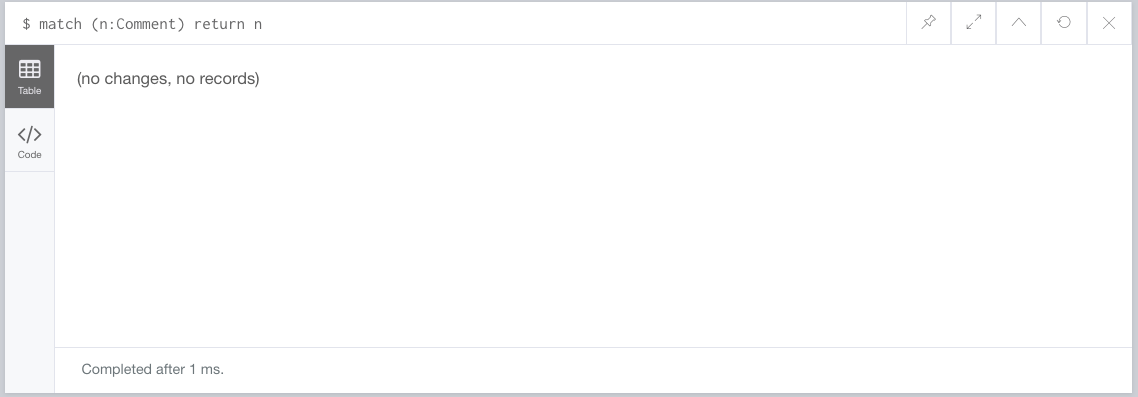 |
| :---: |
| __No Comments up my Sleeve__ |

## Redis $-$ HW4 Part 2

### Concept

- One of the most common uses of Redis is as a web response or API cache.

| 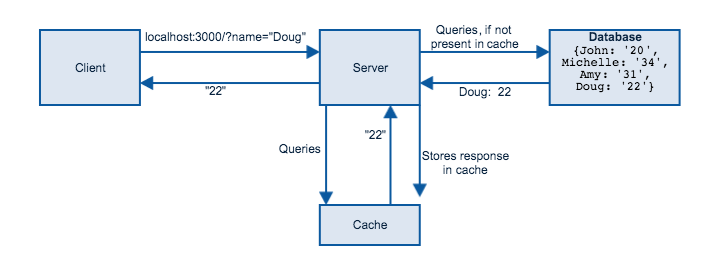 |
| :---: |
| SQL Result Cache |

|  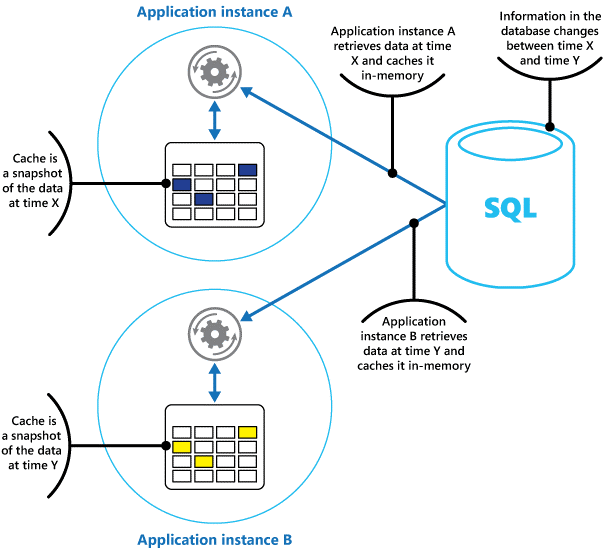|
| :---: |
| DB Cache in Web Application Flow |

- HW4 will use Redis to implement a simple result cache in front of $retrieve\_by\_template().$

### Starting Code

In [778]:
import redis
from operator import itemgetter
import json

"""
Connect to local Redis server. StrictRedis complies more closely with standard than
simple Redis client in this package. decode_responses specifies whether or not to convert
bytes to UTF8 character string or treat as raw bytes, e.g. an image, audio stream, etc.
"""
r = redis.StrictRedis(
    host='localhost',
    port=6379,
    charset="utf-8", decode_responses=True)


def add_to_cache(key, value):
    """

    :param key: A valid Redis key string.
    :param value: A Python dictionary to add to cache.
    :return: None
    """
    k = key
    #ut.debug_message("Adding key = ", k)
    #ut.debug_message("Adding data", value)
#     print("k in add_to cache",k)
    r.set(k, value)


def get_from_cache(key):
    """

    :param key: A valid Redis key.
    :return: The "map object" associated with the key.
    """
    result = r.get(key)
#     print("key in get_from_cache",key,"result after get key",result)
    return result

def get_keys():
    result = r.keys()
    return result

def save_dict(k, d):
    result = r.hmset(k, d)
    return result

def get_dict(k):
    result = r.hgetall(k)
    return result


- Tests

In [781]:
# Note, you will get different keys. This is what is in my Redis DB.
get_keys()

['{"table": "Batting", "template": {"teamID": "BOS", "yearID": "2004"}, "fields": " playerID,H,AB,HR ", "limit": 10, "offset": null, "orderBy": null}',
 '{"table": "Batting", "template": {"teamID": "BOS", "yearID": "2004"}, "fields": " playerID,H,AB,HR ", "limit": 5, "offset": null, "orderBy": null}',
 '{"table": "Batting", "template": {"teamID": "BOS", "yearID": "2004"}, "fields": " playerID,H,AB,HR ", "limit": 3, "offset": null, "orderBy": null}',
 'bob',
 '{"table": "People", "template": {"nameLast": "Williams", "birthCity": "San Diego"}, "fields": " * ", "limit": null, "offset": null, "orderBy": null}',
 'teamID=BOS&yearID=2005',
 'teamID=BOS&yearID=2008',
 'teamID=BOS&yearID=2004',
 '{"table": "Batting", "template": {"teamID": "BOS", "yearID": "2004"}, "fields": " playerID,H,AB,HR ", "limit": null, "offset": null, "orderBy": null}',
 'teamID=BOS&yearID=2007',
 '2cool']

In [782]:
d = {"playerID": "cool", "title": "Imaginary"}

In [783]:
save_dict("2cool", d)

True

In [784]:
rr = get_dict("2cool")
print(rr)

{'playerID': 'cool', 'title': 'Imaginary'}


In [785]:
result = [{"id":10,"uni":"dff9"},{"iq":"202","uni":"foo"}]

In [786]:
print(json.dumps(result,indent=2))
# result = json.dumps(result,indent=2)
type(result)

[
  {
    "id": 10,
    "uni": "dff9"
  },
  {
    "iq": "202",
    "uni": "foo"
  }
]


list

In [787]:
save_dict("2cool", result)  # this give an error because it can't save a list or a string

AttributeError: 'list' object has no attribute 'items'

In [788]:
s = json.dumps(result)
s  # a string

'[{"id": 10, "uni": "dff9"}, {"iq": "202", "uni": "foo"}]'

In [789]:
add_to_cache("bob",s)

In [790]:
rrr = get_from_cache("bob")

In [791]:
rrr

'[{"id": 10, "uni": "dff9"}, {"iq": "202", "uni": "foo"}]'

In [792]:
type(rrr)

str

In [793]:
real_r = json.loads(rrr)   #decode JSON
print(real_r)
type(real_r)

[{'id': 10, 'uni': 'dff9'}, {'iq': '202', 'uni': 'foo'}]


list

### Homework



- HW4 will add checking the Redis cache to a simple, standalone $retrieve\_by\_template()$ function.
    1. Write a function $add\_to\_cache()$ that adds a retrieve result to the cache.
    2. Write a function $retrieve\_from\_cache()$ that checks the cache and returns the value if present.
    3. Modify $retrieve\_by\_template()$ to use the cache.
        1. Check and return if cached.
        2. Call DB and add to cache if not cached.
        

### Some Helper Code


- Some helper code

In [794]:
import pymysql.cursors
import json
import copy
import urllib.parse

db_schema = None                                # Schema containing accessed data
cnx = None                                      # DB connection to use for accessing the data.
key_delimiter = '_'                             # This should probably be a config option.


default_db_params = {
    "dbhost": "localhost",                    # Changeable defaults in constructor
    "port": 3306,
    "dbname": "lahman2017",
    "dbuser": "dbuser",
    "dbpw": "dbuserdbuser",
    "cursorClass": pymysql.cursors.DictCursor,        # Default setting for DB connections
    "charset":  'utf8mb4'                             # Do not change
}

def get_new_connection(params=default_db_params):
    cnx = pymysql.connect(
        host=params["dbhost"],
        port=params["port"],
        user=params["dbuser"],
        password=params["dbpw"],
        db=params["dbname"],
        charset=params["charset"],
        cursorclass=params["cursorClass"])
    return cnx

def set_config():
    """
    Creates the DB connection and sets the global variables.

    :param cfg: Application configuration data.
    :return: None
    """
    global db_schema
    global cnx

    db_params = {
        "dbhost": "localhost",
        "port": 3306,
        "dbname": "lahman2017",
        "dbuser": "dbuser",
        "dbpw": "dbuserdbuser",
        "cursorClass": pymysql.cursors.DictCursor,
        "charset": 'utf8mb4'
    }

    db_schema = "lahman2017"

    cnx = get_new_connection(db_params)


# Given one of our magic templates, forms a WHERE clause.
# { a: b, c: d } --> WHERE a=b and c=d. Currently treats everything as a string.
# We can fix this by using PyMySQL connector query templates.
def templateToWhereClause(t):
    s = ""
    for k,v in t.items():
        if s != "":
            s += " AND "
        s += k + "='" + v + "'"

    if s != "":
        s = "WHERE " + s;

    return s

In [795]:
def run_q(cnx, q, args, fetch=False, commit=True):
    """
    :param cnx: The database connection to use.
    :param q: The query string to run.
    :param args: Parameters to insert into query template if q is a template.
    :param fetch: True if this query produces a result and the function should perform and return fetchall()
    :return:
    """
    #debug_message("run_q: q = " + q)
    #ut.debug_message("Q = " + q)
    #ut.debug_message("Args = ", args)

    result = None

    try:
        cursor = cnx.cursor()
        result = cursor.execute(q, args)
        if fetch:
            result = cursor.fetchall()
        if commit:
            cnx.commit()
    except pymysql_exceptions as original_e:
        #print("dffutils.run_q got exception = ", original_e)
        raise(original_e)

    return result

In [796]:
def compute_cache_key(table, tmp, fields, limit, offset, orderBy):
    k = {
        "table":table,
        "template":tmp,
        "fields":fields,
        "limit":limit,
        "offset":offset,
        "orderBy":orderBy
    }
    k = json.dumps(k, default=str)
    k.replace(":","_")
    return k

def check_cache(table, tmp, fields, limit, offset, orderBy):
    cache_k = compute_cache_key(table,tmp,fields,limit,offset,orderBy)
#     print("Key = ", cache_k)
#     print("Type of key = ", type(cache_k))
    cache_k = urllib.parse.urlencode(tmp)
    print("cache_k in check_cache =",cache_k)
    res = get_from_cache(cache_k)
#     print('res in check_cache= ',res)
    return res


def save_to_cache(table, tmp, fields, limit, offset, orderBy, q_result):
    cache_k = compute_cache_key(table,tmp,fields,limit,offset,orderBy)
    val = json.dumps(q_result, default=str)
    cache_k = urllib.parse.urlencode(tmp)
    add_to_cache(cache_k, val)
    return cache_k
#     print("cache_k =",cache_k,"val =",val)

def retrieve_from_cache(key):
    return get_from_cache(key)

In [797]:
cnx = get_new_connection()  # connect to MySQL

def retrieve_by_template(table, t, fields=None, limit=None, offset=None, orderBy=None, use_cache=False):

    global cnx
    original_fields = fields
    
    
    if use_cache:
        result = check_cache(table,t,fields,limit,offset,orderBy)
        print("use_cache = ", use_cache)
#         print(result)
        if result is None or len(result) == 0:
            print("Cache Miss!")
        else:
            print("Cache Hit!")
            return json.loads(result)

    if t is not None:
        w = templateToWhereClause(t)
    else:
        w = ""

    if orderBy is not None:
        o = "order by " + ",".join(orderBy['fields']) + " " + orderBy['direction'] + " "
    else:
        o = ""

    if limit is not None:
        w += " LIMIT " + str(limit)
    if offset is not None:
        w += " OFFSET " + str(offset)

    if fields is None:
        fields = " * "
    else:
        fields = " " + ",".join(fields) + " "

    cursor=cnx.cursor()
    q = "SELECT " + fields + " FROM " + table + " " + w + ";"

    r = run_q(cnx, q, None, fetch=True, commit=True)
#     print("run_q",r)
    if use_cache and r is not None and len(r) > 0:
        print("Cache Saved")
        save_to_cache(table,t,fields,limit,offset,orderBy, r)
#     print("r = ",r)
    return r

In [798]:
tmp = {"nameLast":"Williams", "birthCity":"San Diego"}
r3 = retrieve_by_template("People",tmp)

In [799]:
r3

[{'playerID': 'willite01',
  'birthYear': 1918,
  'birthMonth': 8,
  'birthDay': 30,
  'birthCountry': 'USA',
  'birthState': 'CA',
  'birthCity': 'San Diego',
  'deathYear': 2002,
  'deathMonth': 7,
  'deathDay': 5,
  'deathCountry': 'USA',
  'deathState': 'FL',
  'deathCity': 'Inverness',
  'nameFirst': 'Ted',
  'nameLast': 'Williams',
  'nameGiven': 'Theodore Samuel',
  'weight': '205',
  'height': '75',
  'bats': 'L',
  'throws': 'R',
  'debut': '1939-04-20',
  'finalGame': '1960-09-28',
  'retroID': 'willt103',
  'bbrefID': 'willite01',
  'DOD': datetime.date(2002, 7, 5),
  'DOB': datetime.date(1918, 8, 30)},
 {'playerID': 'willitr01',
  'birthYear': 1992,
  'birthMonth': 4,
  'birthDay': 25,
  'birthCountry': 'USA',
  'birthState': 'CA',
  'birthCity': 'San Diego',
  'deathYear': None,
  'deathMonth': None,
  'deathDay': None,
  'deathCountry': '',
  'deathState': '',
  'deathCity': '',
  'nameFirst': 'Trevor',
  'nameLast': 'Williams',
  'nameGiven': 'Trevor Anthony',
  'weight'

## Tests (Note that here I use "save_to_cache()" instead of "add_to_cache()")

In [800]:
def test1():  # test retrieve by template
    tmp = {"teamID":"BOS","yearID":"2009"}
    fields = ["playerID", "H","AB"]
    resource = "Batting"
    
    for i in range(0,3):
        result = retrieve_by_template(resource, tmp, fields,limit=3,use_cache=True)
        print("test1: result[", i, "]=", json.dumps(result, indent=2))
test1()

cache_k in check_cache = teamID=BOS&yearID=2009
use_cache =  True
Cache Miss!
Cache Saved
test1: result[ 0 ]= [
  {
    "playerID": "anderbr03",
    "H": "5",
    "AB": "17"
  },
  {
    "playerID": "baileje01",
    "H": "16",
    "AB": "77"
  },
  {
    "playerID": "baldero01",
    "H": "38",
    "AB": "150"
  }
]
cache_k in check_cache = teamID=BOS&yearID=2009
use_cache =  True
Cache Hit!
test1: result[ 1 ]= [
  {
    "playerID": "anderbr03",
    "H": "5",
    "AB": "17"
  },
  {
    "playerID": "baileje01",
    "H": "16",
    "AB": "77"
  },
  {
    "playerID": "baldero01",
    "H": "38",
    "AB": "150"
  }
]
cache_k in check_cache = teamID=BOS&yearID=2009
use_cache =  True
Cache Hit!
test1: result[ 2 ]= [
  {
    "playerID": "anderbr03",
    "H": "5",
    "AB": "17"
  },
  {
    "playerID": "baileje01",
    "H": "16",
    "AB": "77"
  },
  {
    "playerID": "baldero01",
    "H": "38",
    "AB": "150"
  }
]


![from_cache](get_from_cache.jpg)

In [802]:
def test0():  # test retrieve from cache
    tmp = {"teamID":"BOS","yearID":"2005"}
    limit = 5
    br = retrieve_by_template("Batting",tmp,fields=['H','AB','playerID','teamID','yearID'],limit=limit)
    print(json.dumps(br,indent=2))
    key = save_to_cache("Batting",tmp,fields=['H','AB','playerID','teamID','yearID'],limit=limit, offset=None, orderBy=None,q_result=br)
    print("key=",key)
    d = retrieve_from_cache(key)
    print("cache=",d)
test0()

[
  {
    "H": "0",
    "AB": "0",
    "playerID": "alvarab01",
    "teamID": "BOS",
    "yearID": "2005"
  },
  {
    "H": "0",
    "AB": "1",
    "playerID": "arroybr01",
    "teamID": "BOS",
    "yearID": "2005"
  },
  {
    "H": "61",
    "AB": "283",
    "playerID": "bellhma01",
    "teamID": "BOS",
    "yearID": "2005"
  },
  {
    "H": "0",
    "AB": "0",
    "playerID": "bradfch01",
    "teamID": "BOS",
    "yearID": "2005"
  },
  {
    "H": "0",
    "AB": "0",
    "playerID": "cassisc01",
    "teamID": "BOS",
    "yearID": "2005"
  }
]
key= teamID=BOS&yearID=2005
cache= [{"H": "0", "AB": "0", "playerID": "alvarab01", "teamID": "BOS", "yearID": "2005"}, {"H": "0", "AB": "1", "playerID": "arroybr01", "teamID": "BOS", "yearID": "2005"}, {"H": "61", "AB": "283", "playerID": "bellhma01", "teamID": "BOS", "yearID": "2005"}, {"H": "0", "AB": "0", "playerID": "bradfch01", "teamID": "BOS", "yearID": "2005"}, {"H": "0", "AB": "0", "playerID": "cassisc01", "teamID": "BOS", "yearID": "200